In [1]:
from networkx.generators.random_graphs import connected_watts_strogatz_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from scipy.stats import poisson, uniform
from collections import defaultdict, Counter
from itertools import product
import matplotlib.pyplot as plt
from scipy.special import expit
from dotmap import DotMap
from math import floor, isnan
import networkx as nx
import numpy as np
import random
import copy

In [2]:
s = 342423
random.seed(s)
np.random.seed(s)

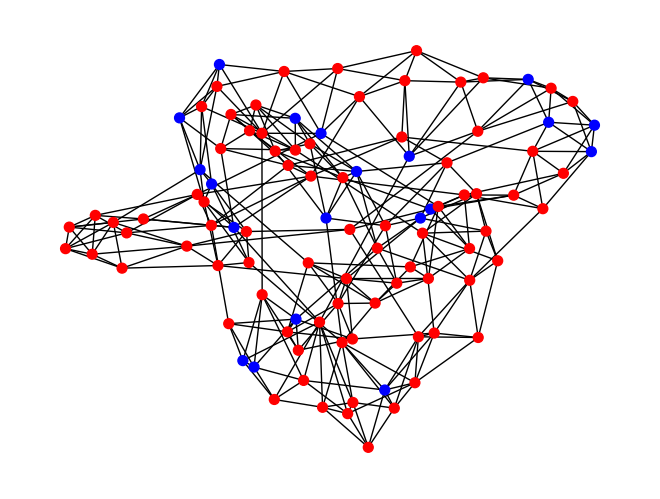

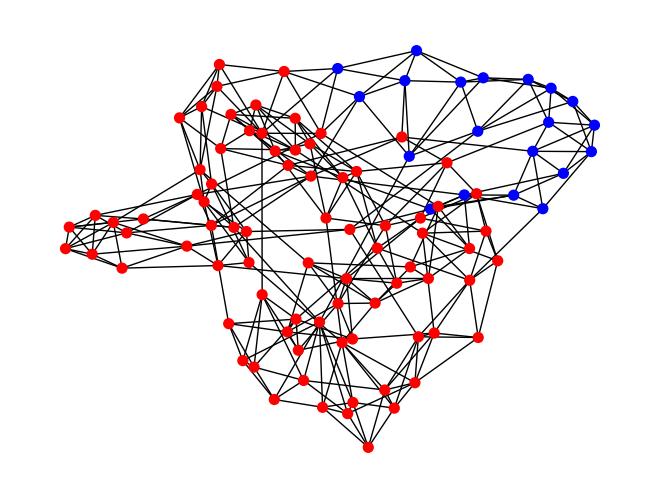

In [3]:
g = connected_watts_strogatz_graph(n=100, k=6, p=0.1)
N = 20
treatment = set(random.sample(list(g.nodes), N))
color_map = []
for node in g:
    if node in treatment:
        color_map.append('blue')
    else: 
        color_map.append('red')      
pos = nx.spring_layout(g)
nx.draw(g, pos, node_color=color_map, node_size=50)
plt.show()

treatment = set(list(g.nodes)[:N])
color_map = []
for node in g:
    if node in treatment:
        color_map.append('blue')
    else: 
        color_map.append('red')      
nx.draw(g, pos, node_color=color_map, node_size=50)
plt.show()

In [4]:
def step_posts(yesterday_posts, model, t):
    today_posts = defaultdict(int)
    for i in model.g.nodes:
        neighbour_posts = [yesterday_posts[j] for j in model.g.neighbors(i)]
        λ = model.λ_int(i) + model.ν(neighbour_posts)
        today_posts[i] = model.post_production(i, λ)
    return today_posts

def simulate_network(model, steady_state_cut=5, plot_ymax=None):
    posts_series = []
    for t in range(model.T):
        if t % 10 == 0:
            print(f'Simulation at t = {t}')
        posts = step_posts(
            [0]*len(model.g.nodes) if len(posts_series) == 0 else posts_series[-1],
            model, t)
        posts_series.append(posts)
    li = posts_series[steady_state_cut:]
    y = np.array([np.mean(list(posts.values())) for posts in li])
    s = np.array([np.std(list(posts.values()))  for posts in li])
    lo = y - s
    hi = y + s
    x = np.array(range(steady_state_cut, model.T))
    plt.figure(figsize=(10, 5))
    plt.xlabel('t')
    plt.ylabel('mean content production')
    plt.plot(x, y)
    plt.fill_between(x, lo, hi, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    if plot_ymax is not None: plt.ylim((0, plot_ymax))
    plt.show()
    return y, li

def group_post_productions(model, posts_series, plot_mova_window=None):
    everything = []
    treatment = []
    control = []
    neighbours = []
    rest = []
    for posts in posts_series:
        everything.append(np.mean(list(posts.values())))
        treatment.append(np.mean([v for (k, v) in posts.items() if k in model.nodes_treatment]))
        control.append(np.mean([v for (k, v) in posts.items() if k not in model.nodes_treatment]))
        neighbours.append(np.mean([v for (k, v) in posts.items() if k in model.nodes_treatment_neighbours]))
        rest.append(np.mean([v for (k, v) in posts.items() if k in model.nodes_rest]))
    plt.figure(figsize=(10,5))
    plt.xlabel('t')
    plt.ylabel('mean content production')
    if plot_mova_window is None:
        plt.plot(treatment)
        plt.plot(neighbours)
        plt.plot(rest)
    else:
        plt.plot(mova(treatment, window=plot_mova_window))
        plt.plot(mova(neighbours, window=plot_mova_window))
        plt.plot(mova(rest, window=plot_mova_window))
    plt.legend([
       'treatment',
       'neighbours',
       'rest',
    ], loc='upper right')
    plt.show()
    return everything, treatment, control, neighbours, rest

def model_stats(model, treatment, neighbours, rest):
    k = len(model.g.edges)/len(model.g.nodes)
    c_base = model.λ_int(0)/(1 - k * model.ν_damp)
    c_base_prime = c_base_map[(model.p, model.k, model.ν_damp)]
    t = len(model.nodes_treatment)
    n = len(model.nodes_treatment_neighbours)
    r = len(model.nodes_rest)
    c = n + r
    c_treatment = treatment[-1]
    c_neighbours = neighbours[-1]
    c_rest = rest[-1]
    if isnan(c_rest): c_rest = 0
    c_graph = (t * c_treatment + n * c_neighbours + r * c_rest) / (t+n+r)
    c_control = (n * c_neighbours + r * c_rest) / (n + r)
    e_spillover = c_control/c_base_prime - 1
    e_treatment = c_treatment/c_control - 1
    e_dampening = e_treatment/model.Δλ
    e_intrinsic = c_treatment/c_base_prime - 1
    print(f'Total nodes: {len(model.g.nodes)}')
    print(f'Treatment:   {t}')
    print(f'Control:     {c}')
    print(f'Neighbours:  {n}')
    print(f'Rest:        {r}')
    print(f'---------------------------------')
    print(f'c_base:       {c_base}')
    print(f'c_base_prime: {c_base_prime}')
    print(f'c_graph:      {c_graph}')
    print(f'c_treatment:  {c_treatment}')
    print(f'c_control:    {c_control}')
    print(f'c_neighbours: {c_neighbours}')
    print(f'c_rest:       {c_rest}')
    print(f'---------------------------------')
    print(f'c_graph_prime:      {c_graph/c_base_prime}')
    print(f'c_treatment_prime:  {c_treatment/c_base_prime}')
    print(f'c_control_prime:    {c_control/c_base_prime}')
    print(f'c_neighbours_prime: {c_neighbours/c_base_prime}')
    print(f'c_rest_prime:       {c_rest/c_base_prime}')
    print(f'---------------------------------')
    print(f'e_spillover = {e_spillover}')
    print(f'e_treatment = {e_treatment}')
    print(f'e_dampening = {e_dampening}')
    print(f'e_intrinsic = {e_intrinsic}')
    return c_base_prime, c_graph, c_treatment, c_control, c_neighbours, c_rest, e_spillover, e_treatment, e_dampening, e_intrinsic

def mova(li, window=9):
    if window % 2 == 0: raise Exception("window must be odd")
    mli = []
    n = len(li)
    hw = floor(window/2)
    for i in range(hw, n - hw):
        mli.append(np.mean(li[i-hw:i+hw+1]))
    return mli

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


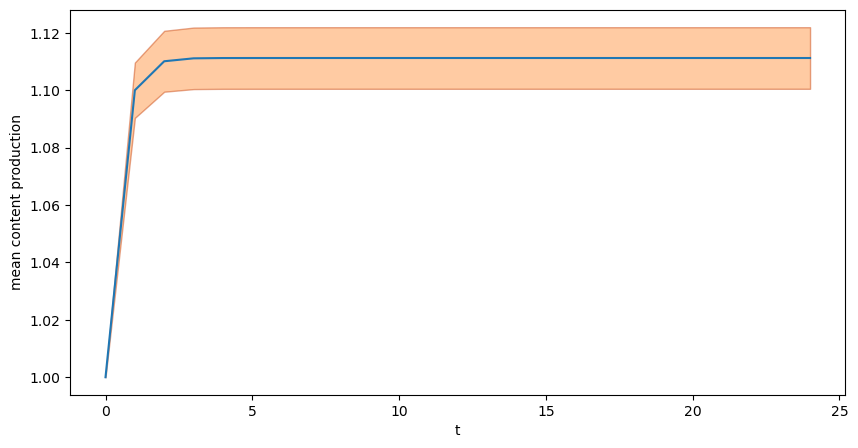

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


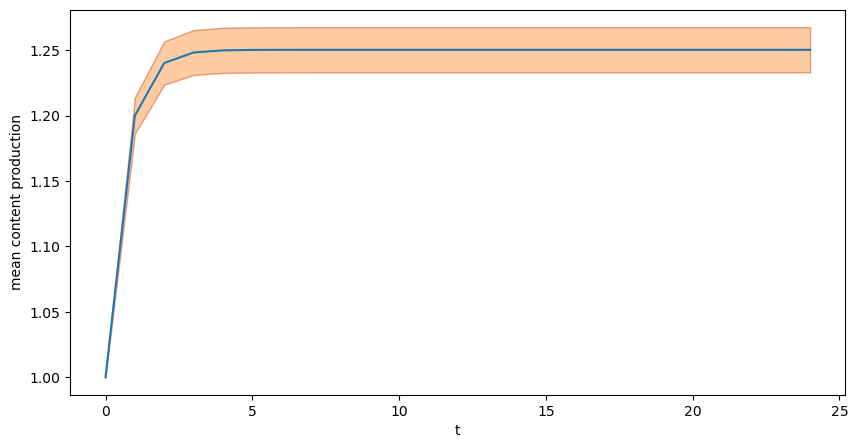

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


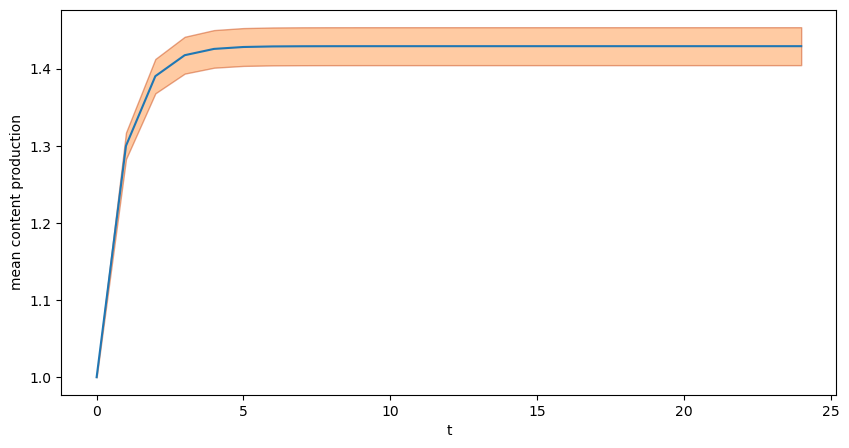

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


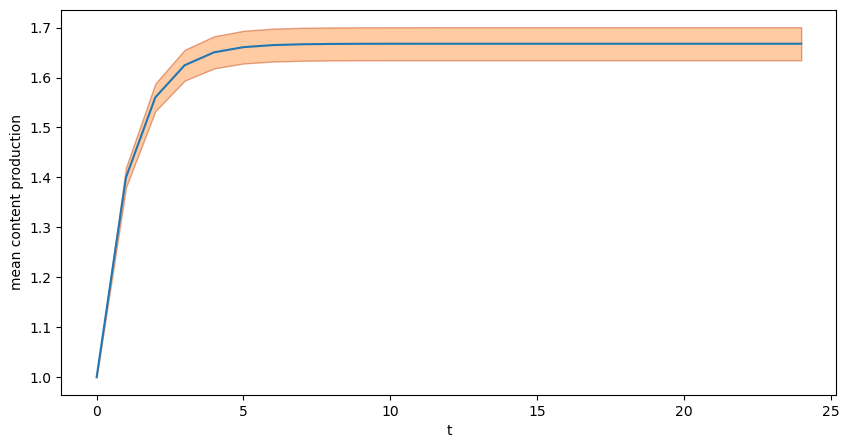

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


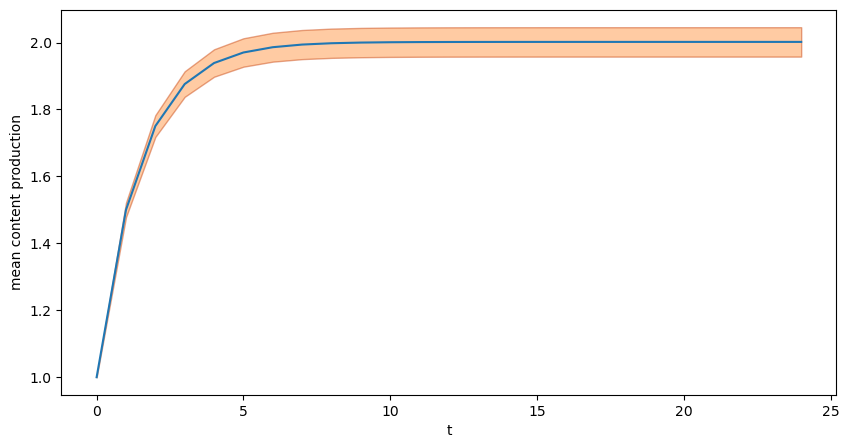

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


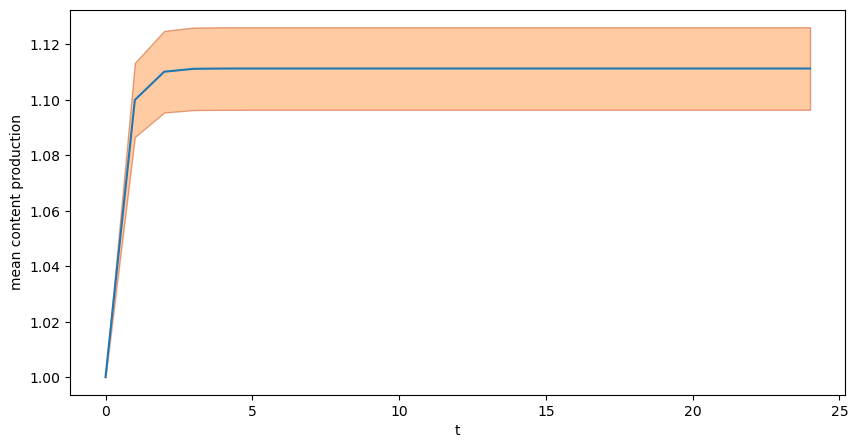

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


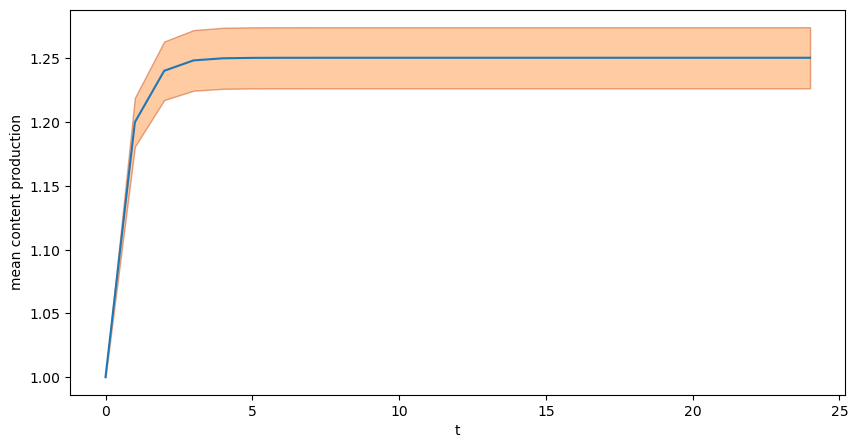

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


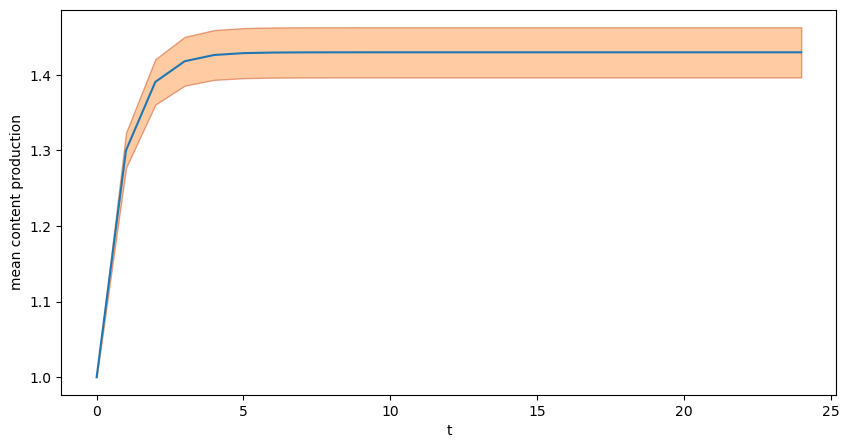

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


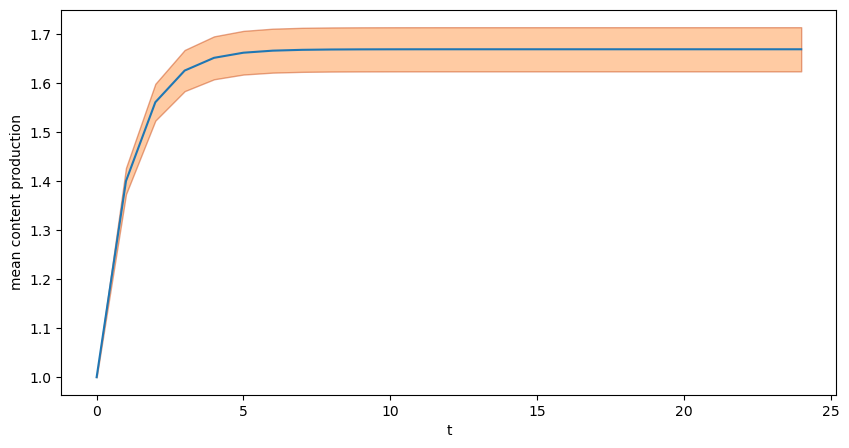

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


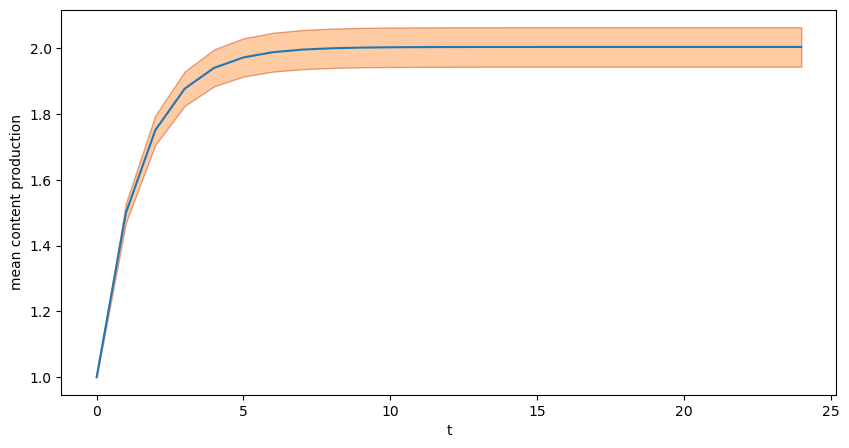

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


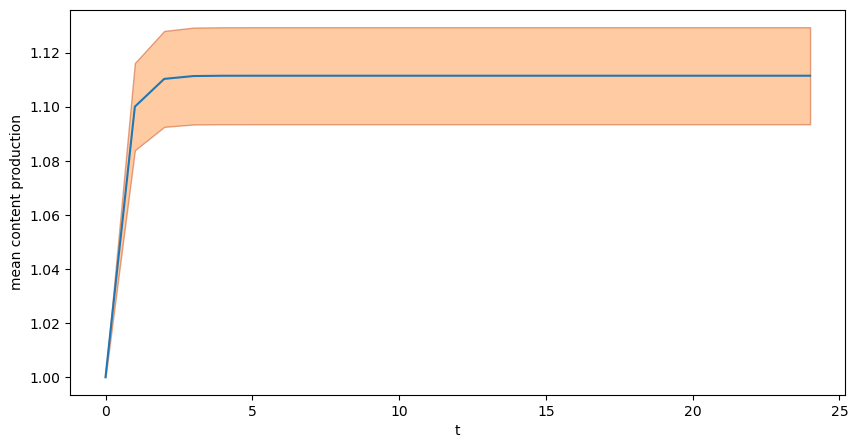

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


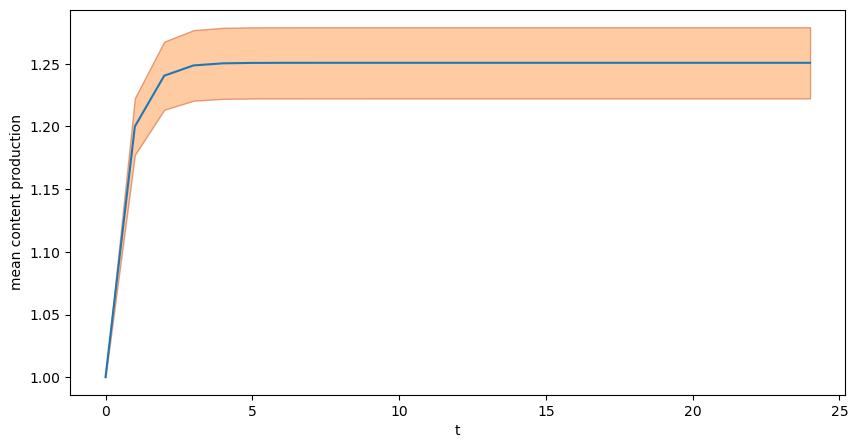

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


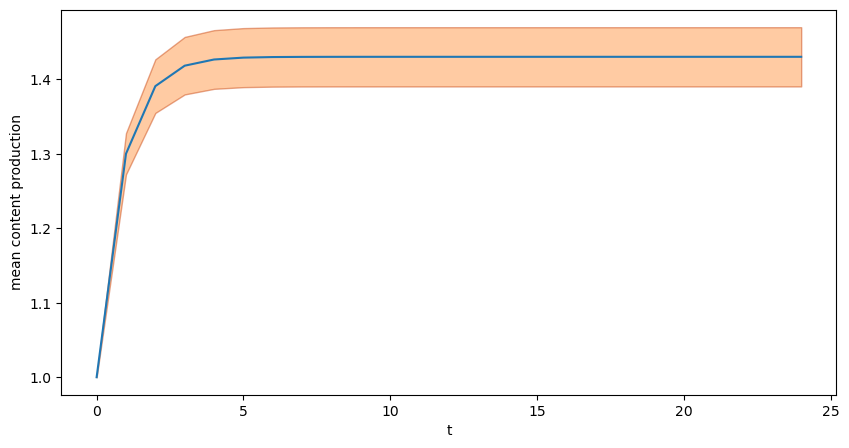

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


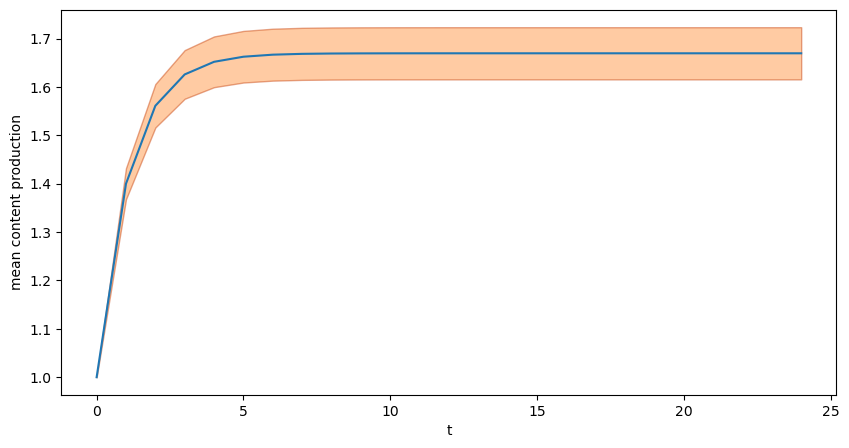

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


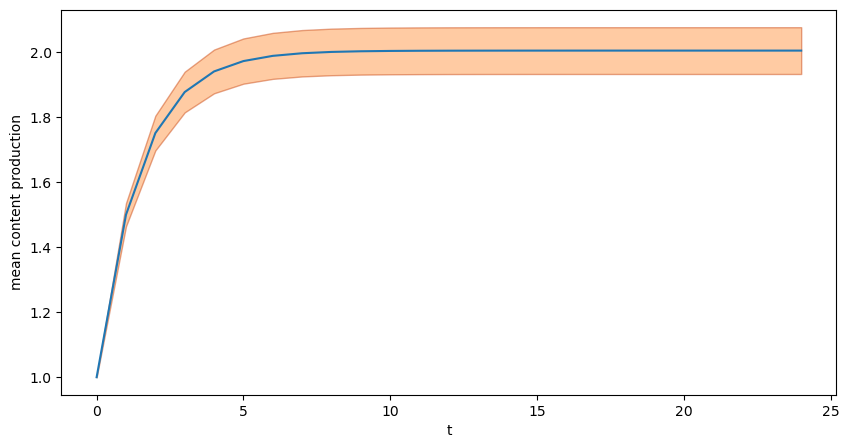

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


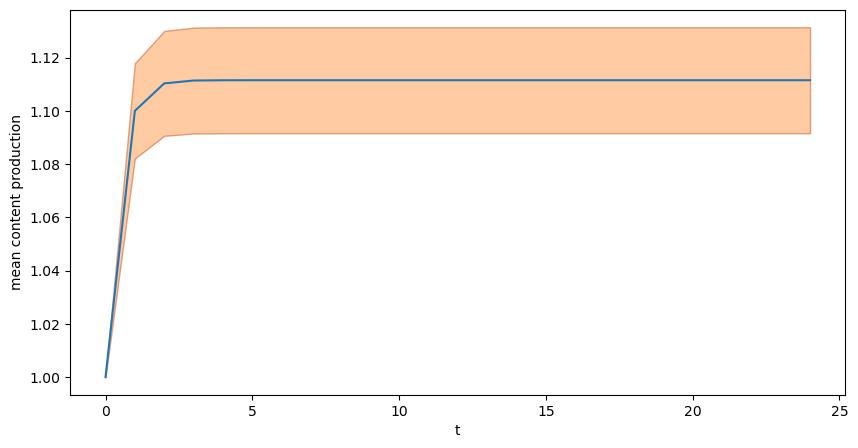

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


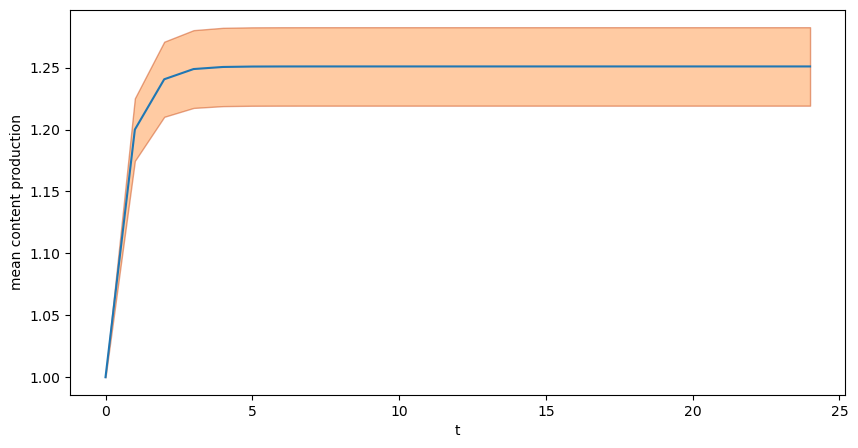

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


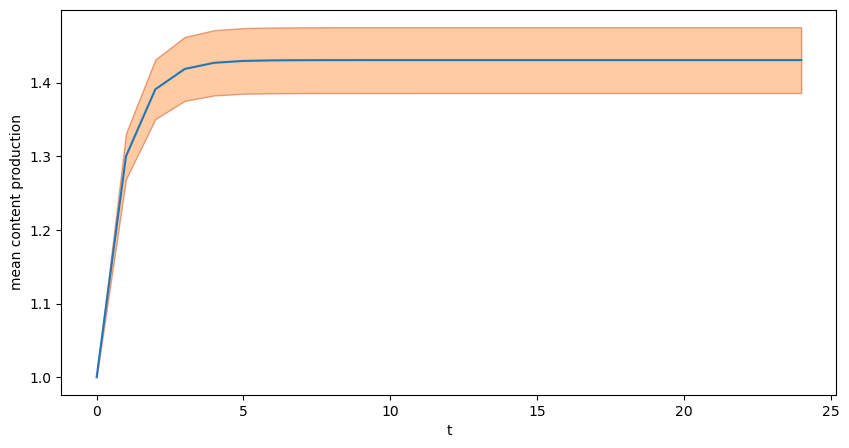

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


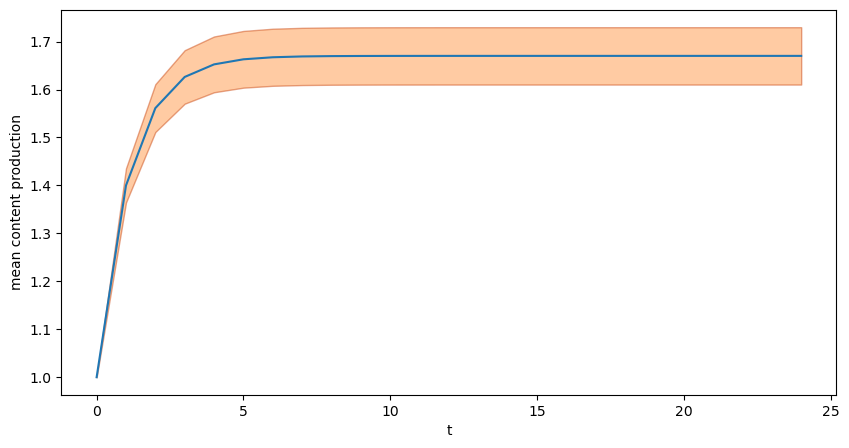

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


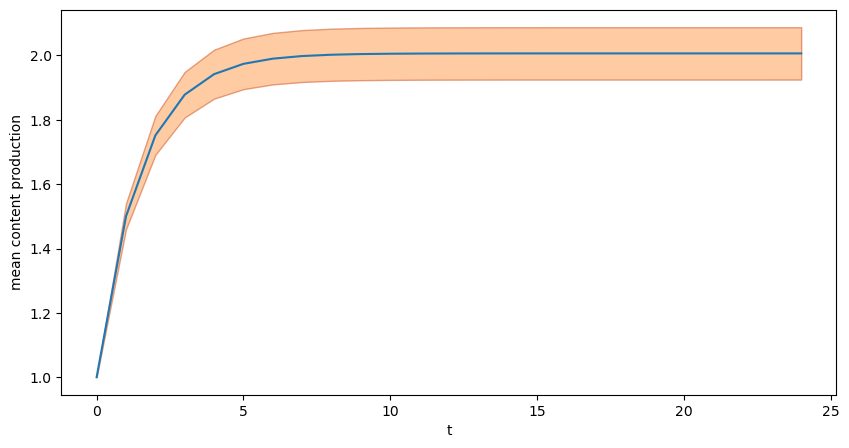

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


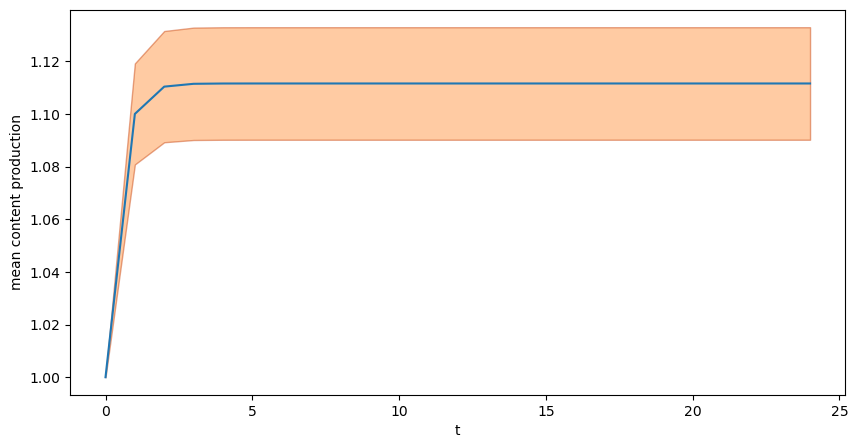

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


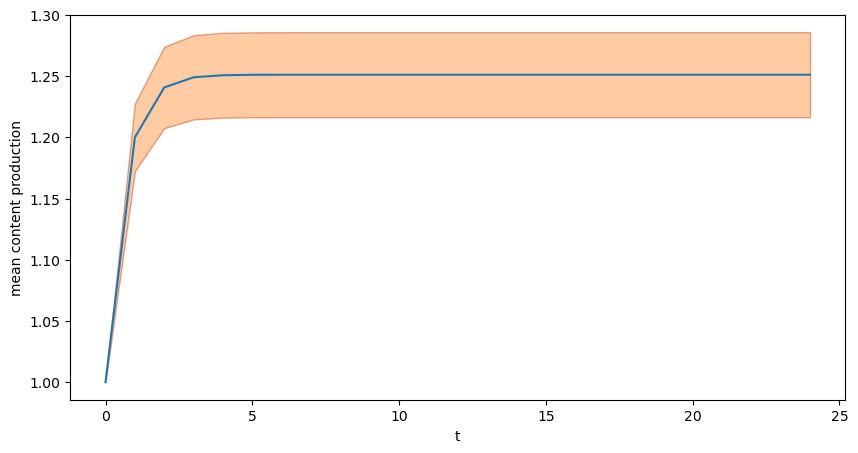

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


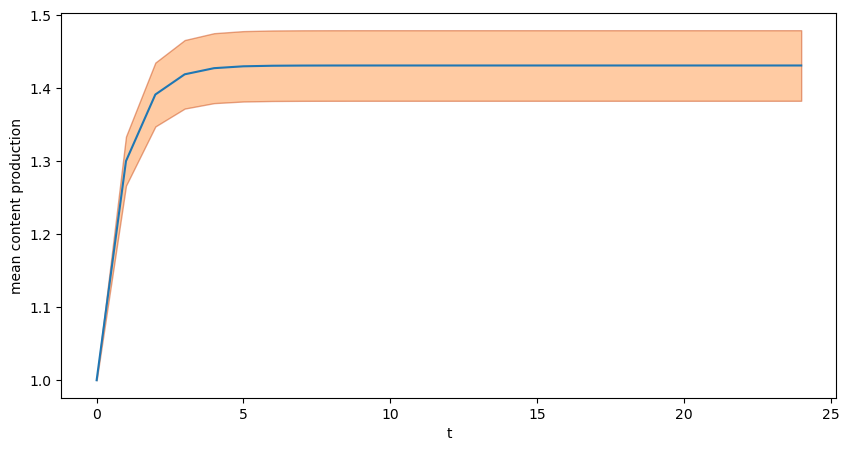

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


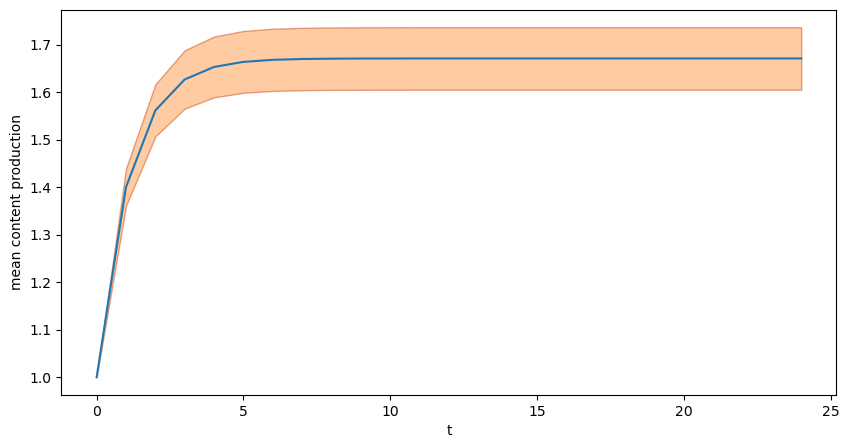

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


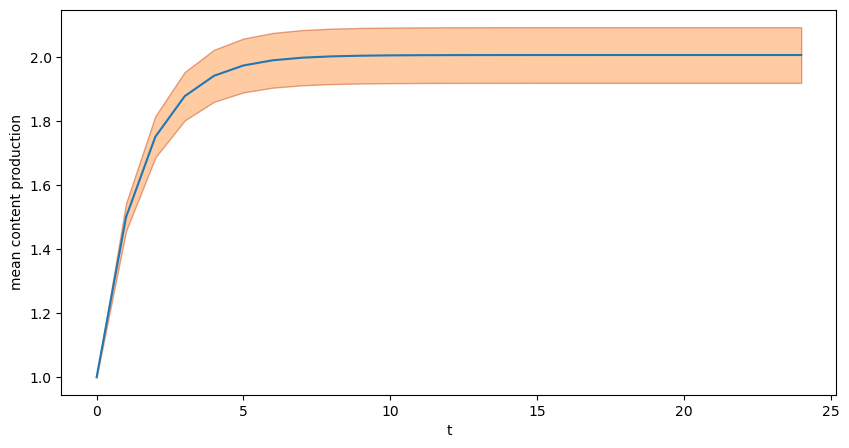

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


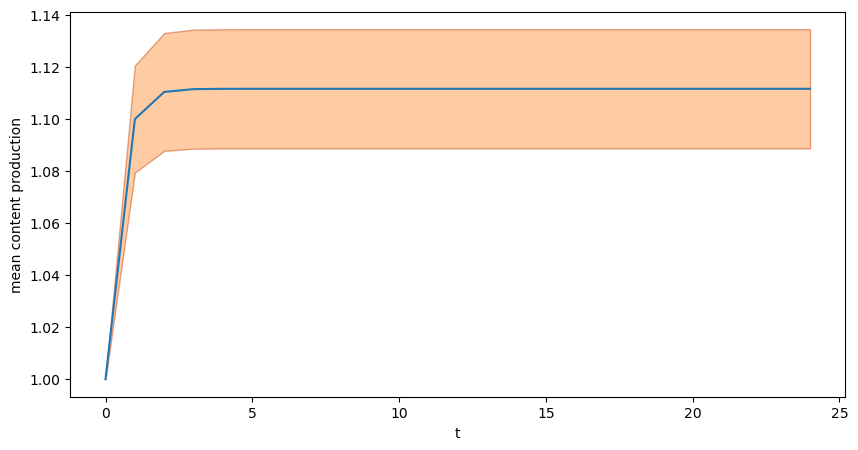

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


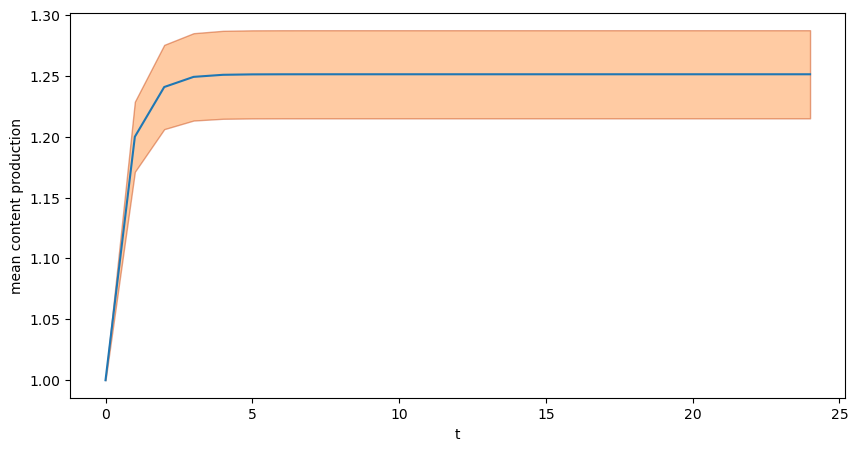

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


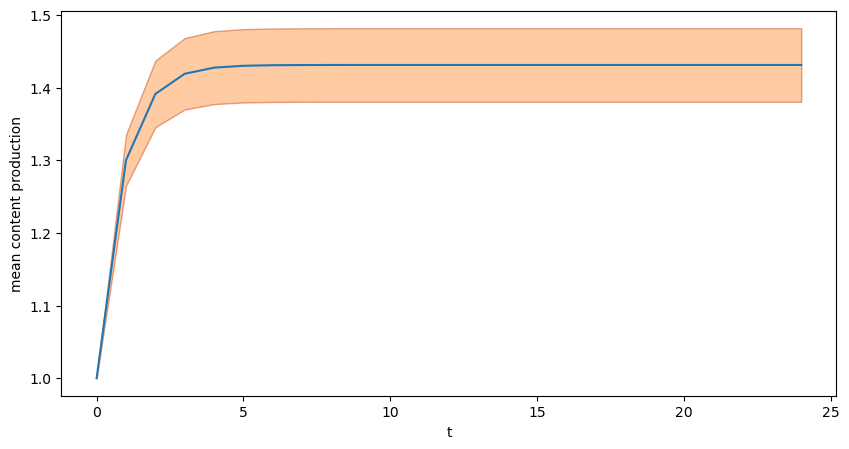

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


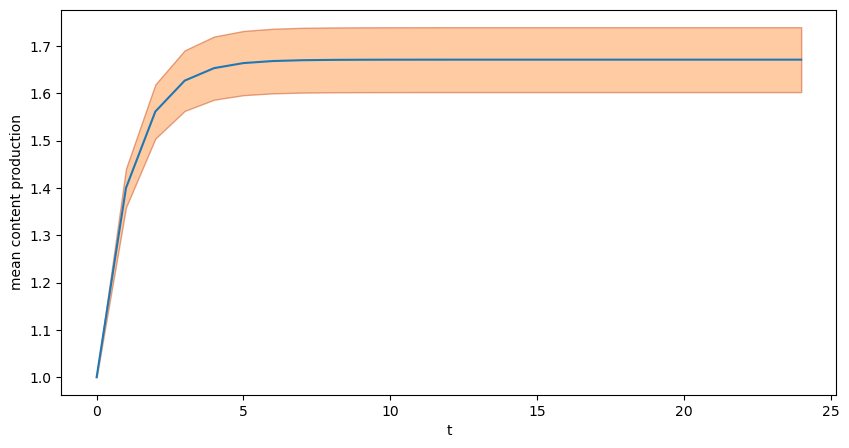

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


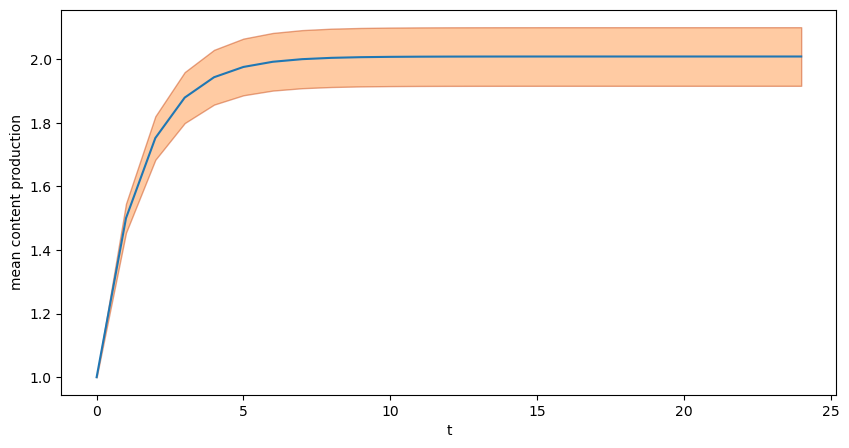

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


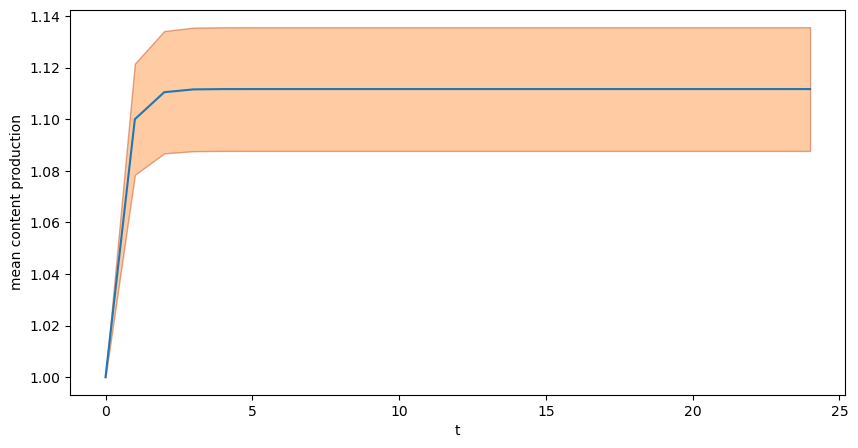

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


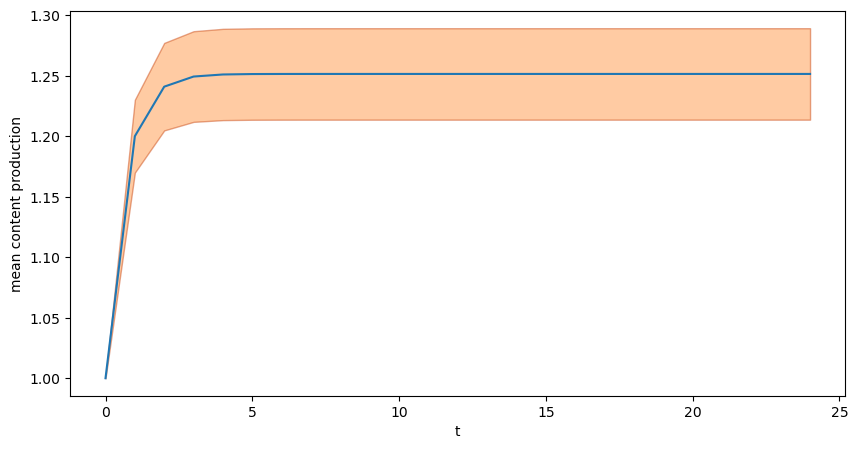

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


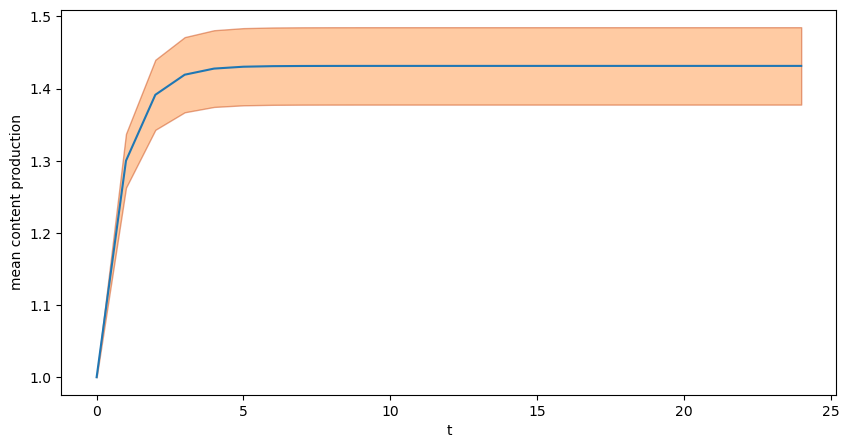

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


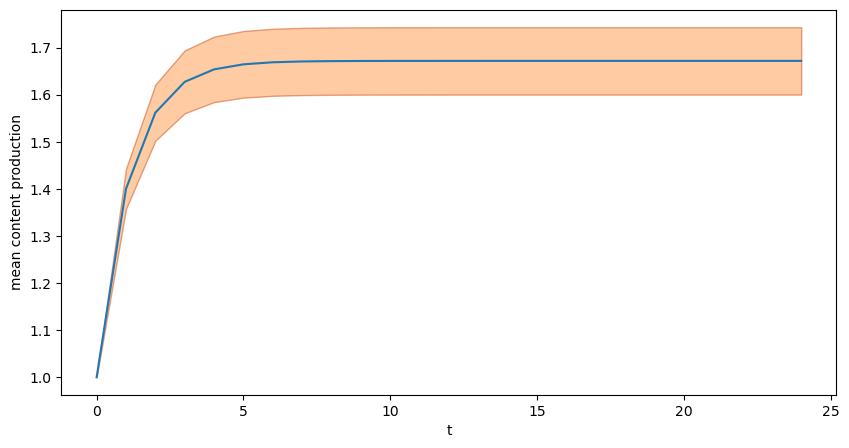

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


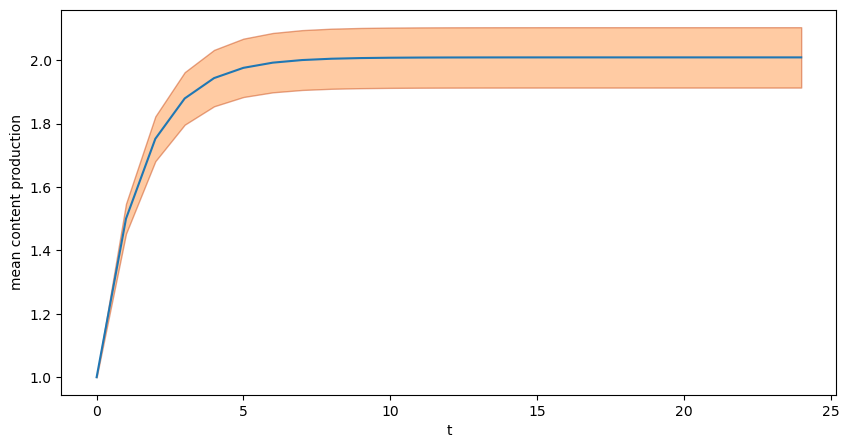

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


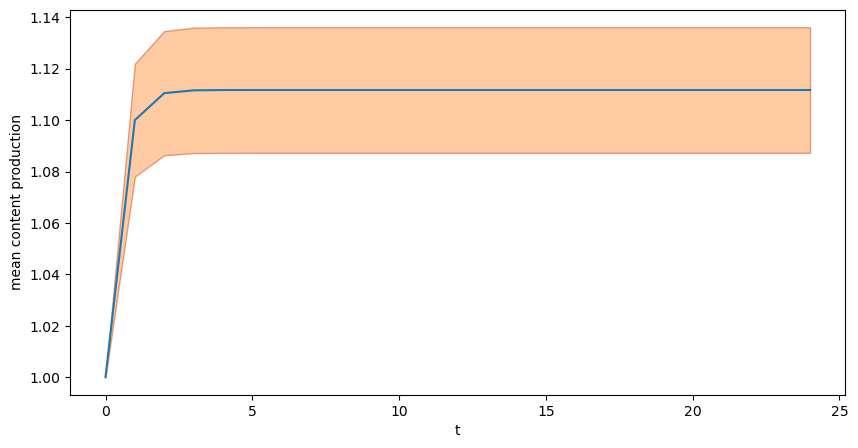

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


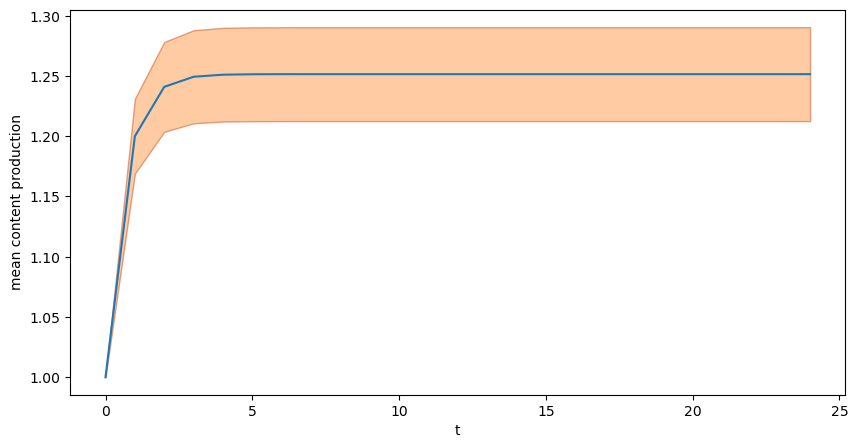

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


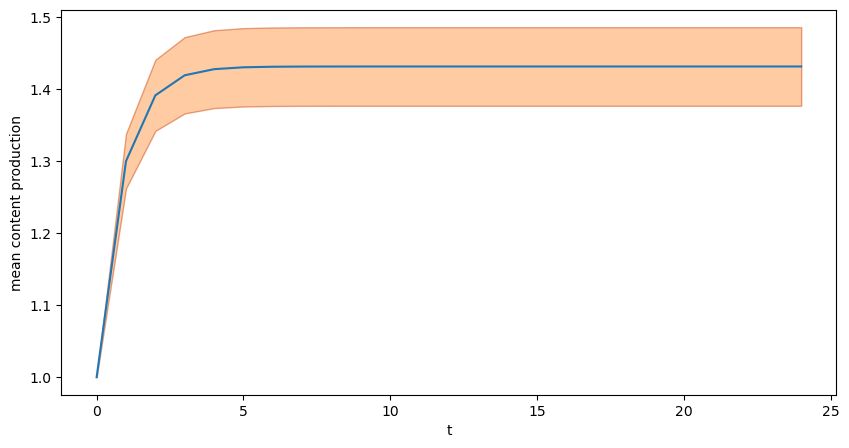

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


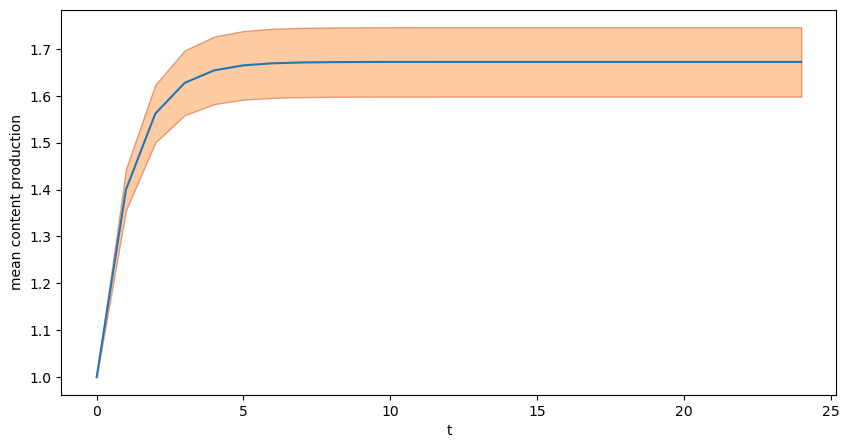

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


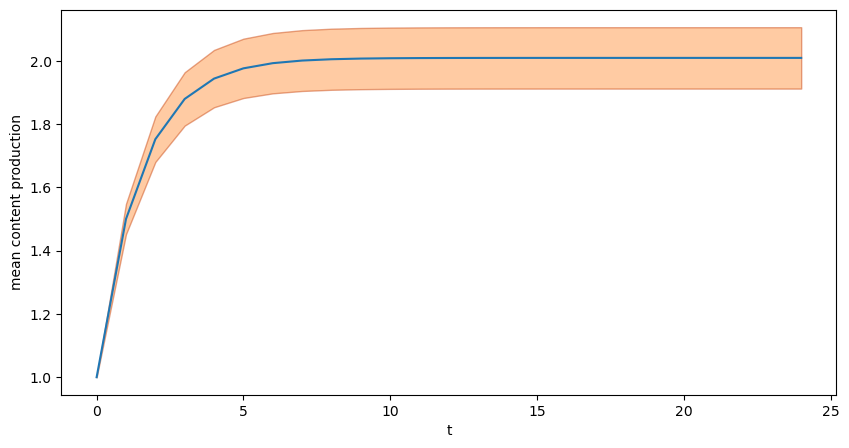

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


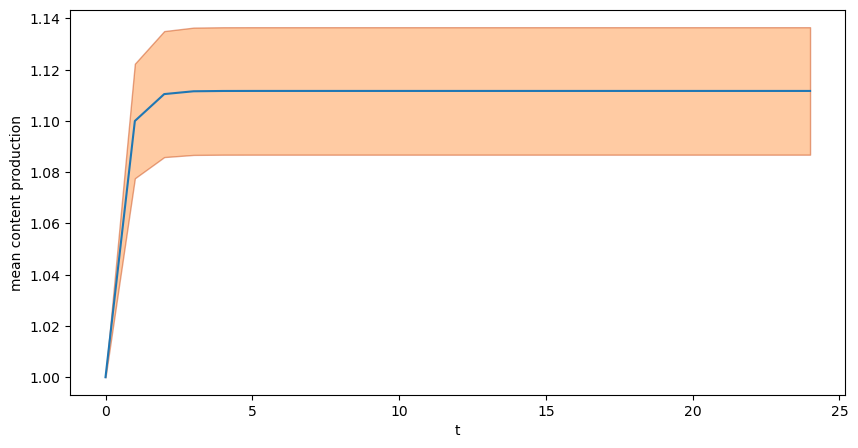

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


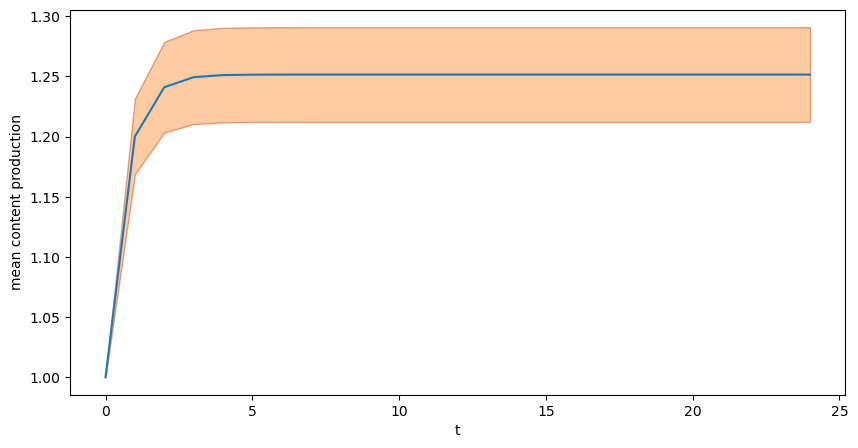

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


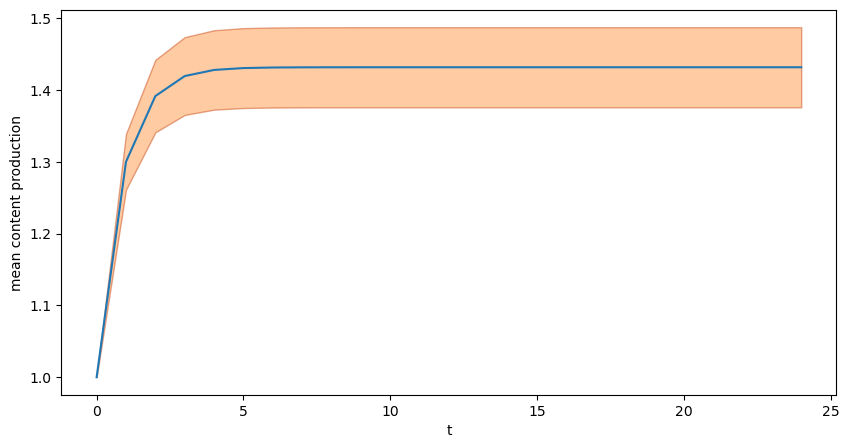

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


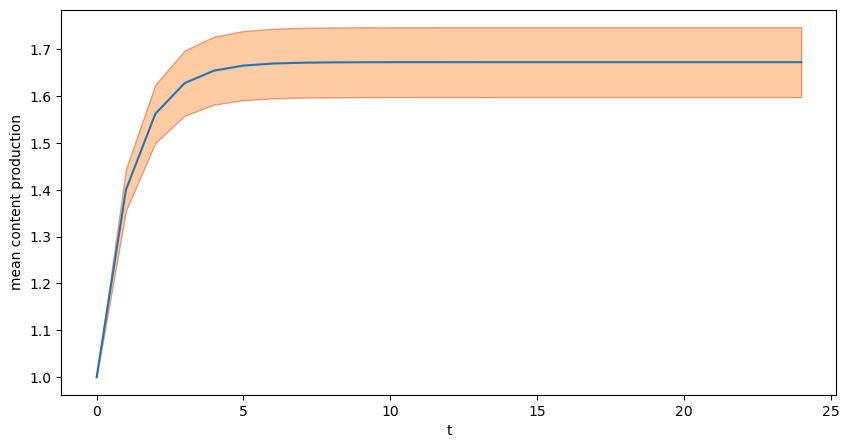

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


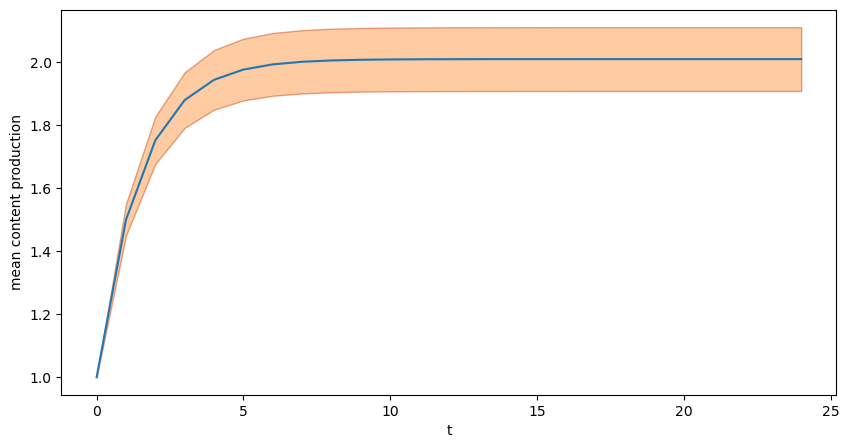

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


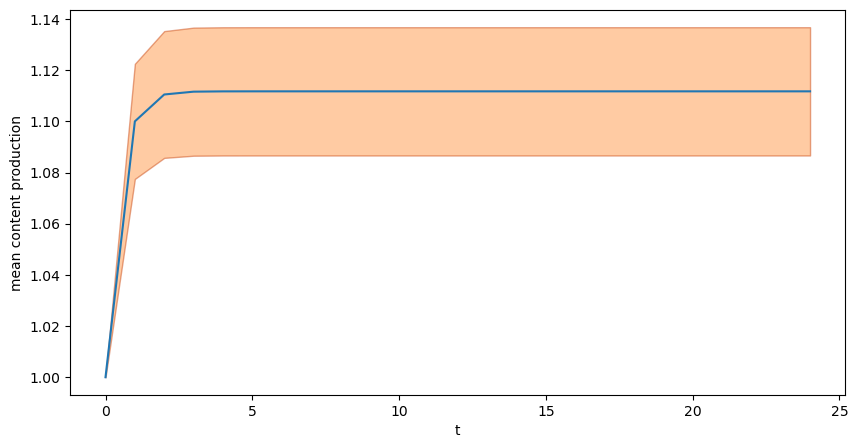

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


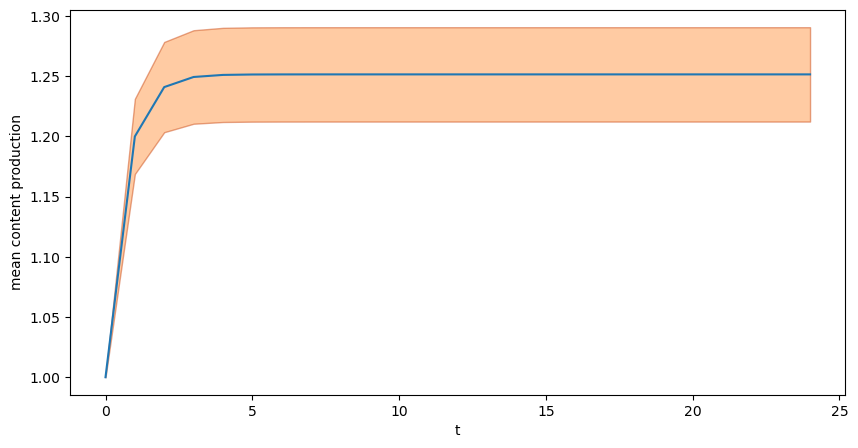

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


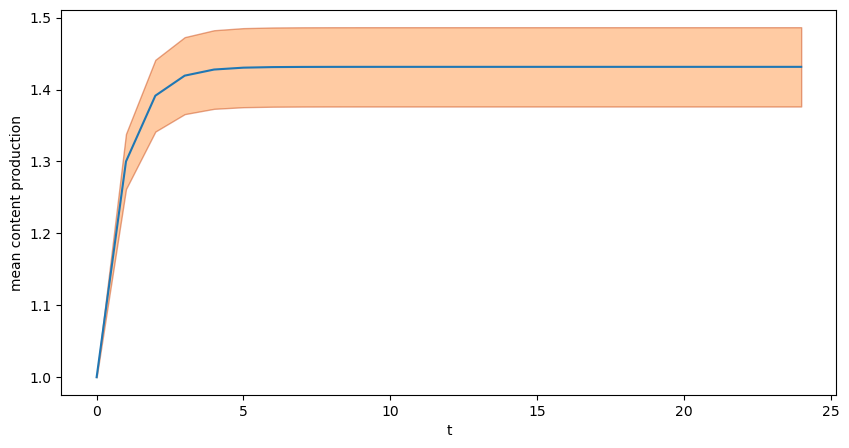

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


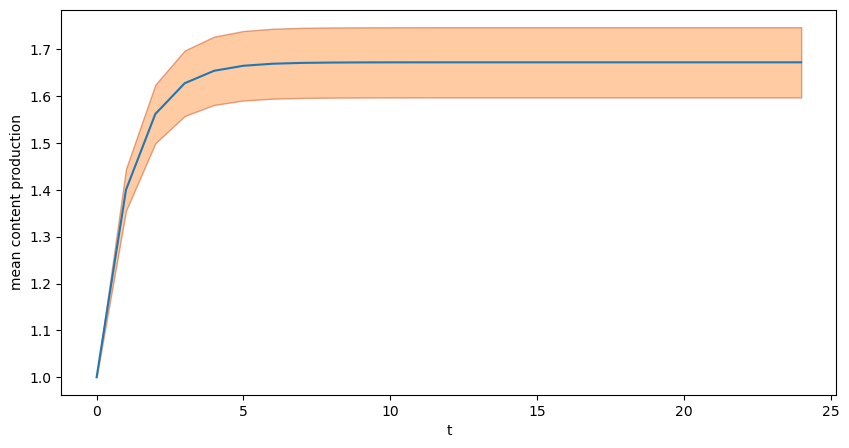

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


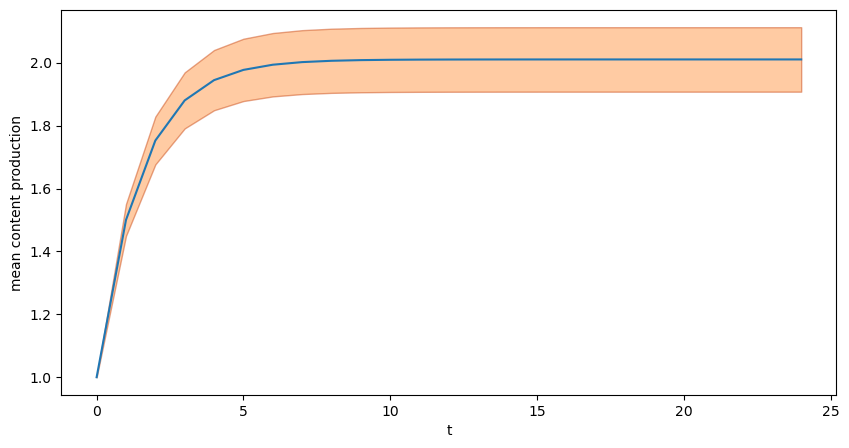

In [5]:
ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ks = [10, 20, 30, 40, 50]
νs = [0.01]
c_base_map = {}
for p, k, ν in product(ps, ks, νs):
    model = DotMap()
    model.g = connected_watts_strogatz_graph(n=10_000, k=k, p=p).to_directed()
    model.ν_damp = ν
    model.ν = lambda posts: model.ν_damp * sum(posts)
    model.λ_int = lambda i: 1
    model.T = 25
    model.post_production = lambda i, λ: λ
    avg_posts, _ = simulate_network(model, steady_state_cut=0)
    c_base_map[(p, k, ν)] = avg_posts[-1]

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


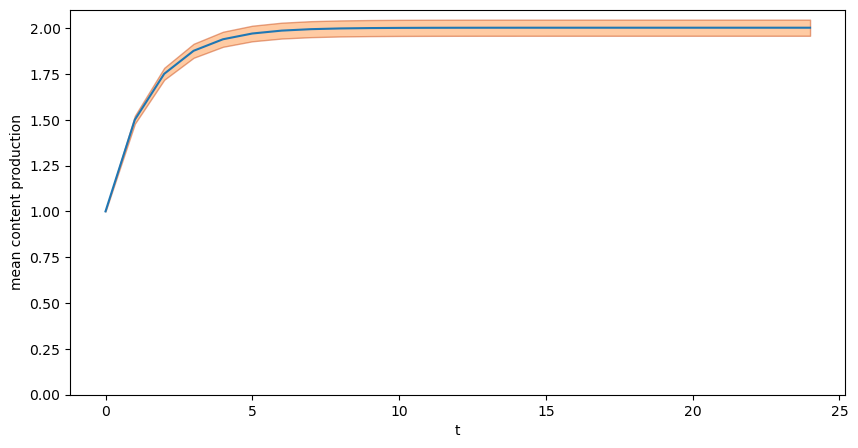

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


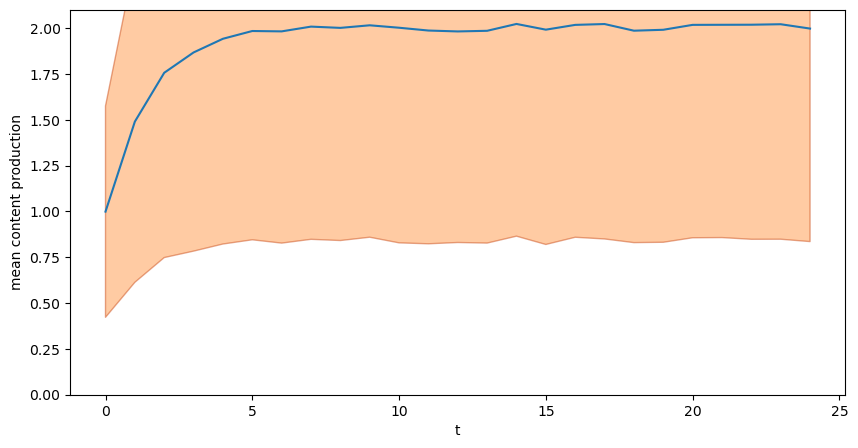

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


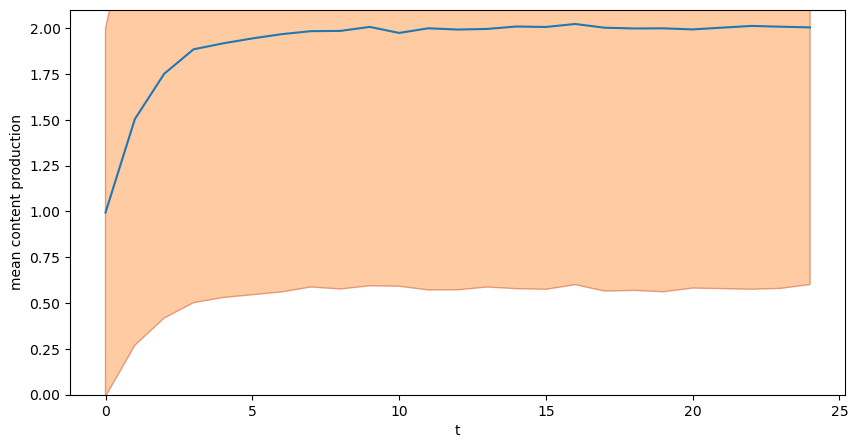

In [6]:
model = DotMap()
model.g = connected_watts_strogatz_graph(n=10_000, k=50, p=0.1).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25

model.post_production = lambda i, λ: λ
avg_posts_norand, posts_series_norand = simulate_network(model, steady_state_cut=0, plot_ymax=2.1)

model.post_production = lambda i, λ: uniform.rvs(0, 2 * λ) # multiply by 2 so the mean is λ
avg_posts_uniform, posts_series_uniform = simulate_network(model, steady_state_cut=0, plot_ymax=2.1)

model.post_production = lambda i, λ: poisson.rvs(λ)
avg_posts_poisson, posts_series_poisson = simulate_network(model, steady_state_cut=0, plot_ymax=2.1)

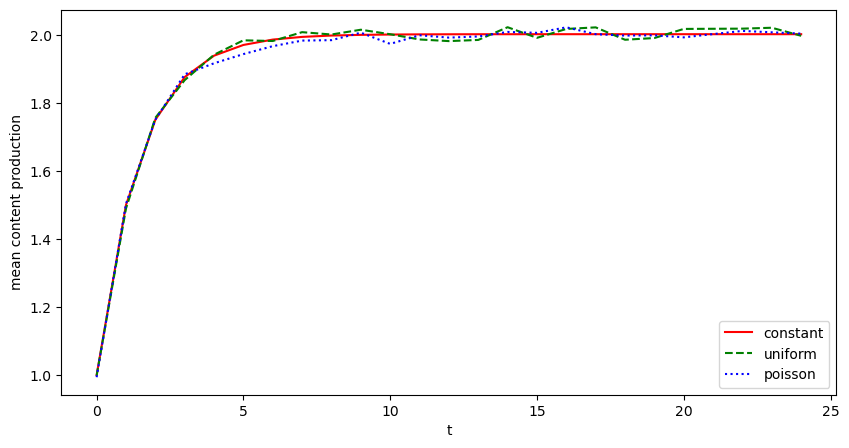

In [7]:
x = np.array(range(0, model.T))
plt.figure(figsize=(10, 5))
plt.xlabel('t')
plt.ylabel('mean content production')
plt.plot(x, avg_posts_norand,  'r-')
plt.plot(x, avg_posts_uniform, 'g--')
plt.plot(x, avg_posts_poisson, 'b:')
plt.legend([
    'constant',
    'uniform',
    'poisson',
], loc='lower right')
plt.show()

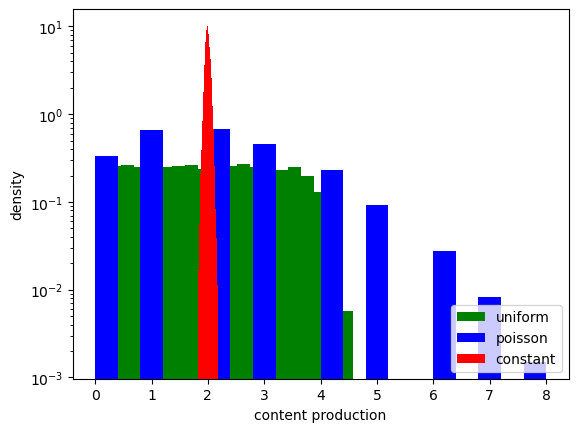

In [8]:
plt.yscale('log')
plt.hist(list(posts_series_uniform[24].values()), bins=20, density=1, color='g')
plt.hist(list(posts_series_poisson[24].values()), bins=20, density=1, color='b')
plt.hist(list(posts_series_norand[24].values()),  bins=20, density=1, color='r')
plt.xlabel('content production')
plt.ylabel('density')
plt.legend([
    'uniform',
    'poisson',
    'constant',
], loc='lower right')
plt.show()

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


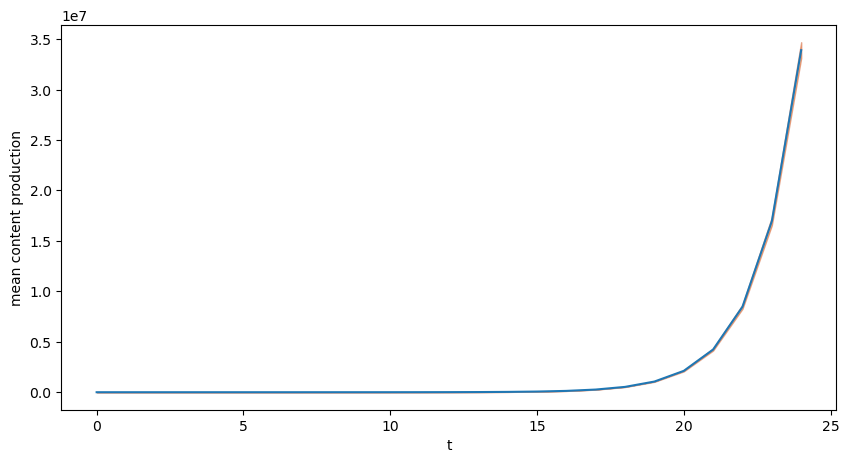

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


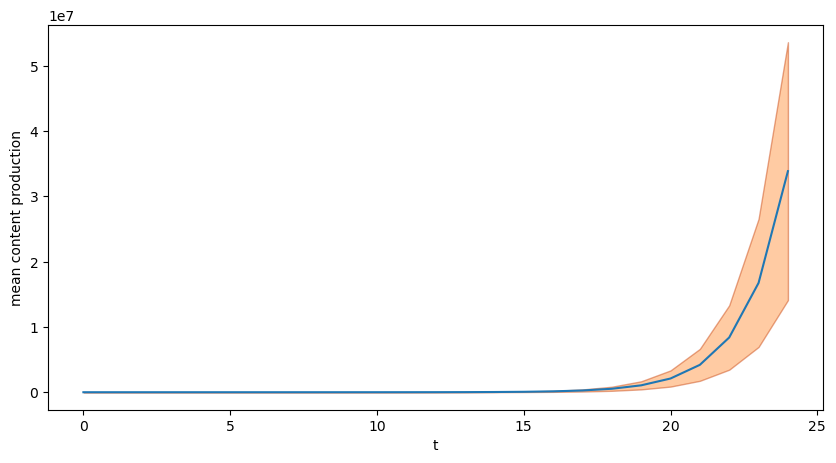

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


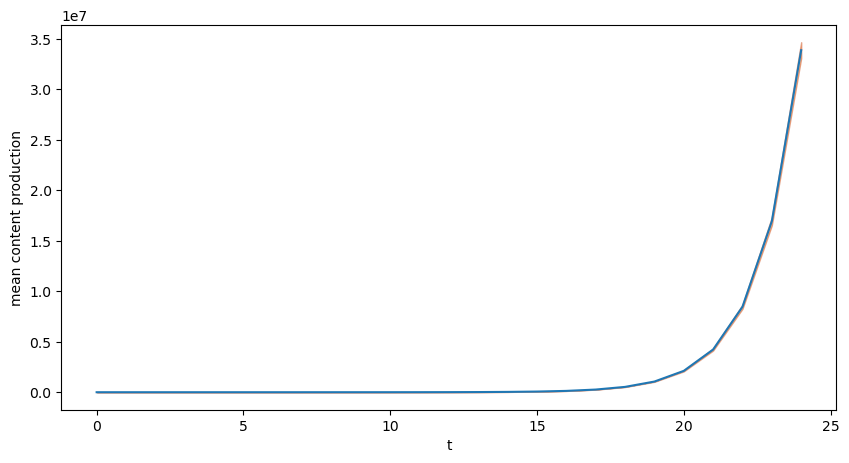

In [9]:
model = DotMap()
model.g = connected_watts_strogatz_graph(n=10_000, k=200, p=0.1).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25

model.post_production = lambda i, λ: λ
avg_posts_norand, posts_series_norand = simulate_network(model, steady_state_cut=0)

model.post_production = lambda i, λ: uniform.rvs(0, 2 * λ) # multiply by 2 so the mean is λ
avg_posts_uniform, posts_series_uniform = simulate_network(model, steady_state_cut=0)

model.post_production = lambda i, λ: poisson.rvs(λ)
avg_posts_poisson, posts_series_poisson = simulate_network(model, steady_state_cut=0)

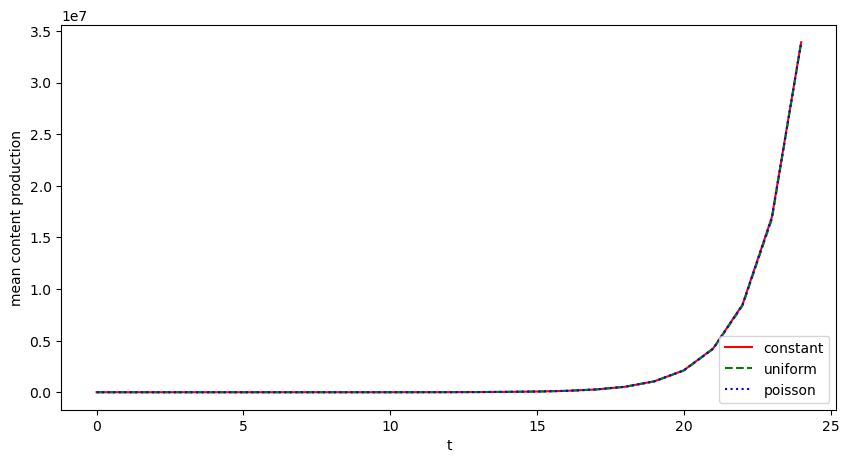

In [10]:
x = np.array(range(0, model.T))
plt.figure(figsize=(10, 5))
plt.xlabel('t')
plt.ylabel('mean content production')
plt.plot(x, avg_posts_norand,  'r-')
plt.plot(x, avg_posts_uniform, 'g--')
plt.plot(x, avg_posts_poisson, 'b:')
plt.legend([
    'constant',
    'uniform',
    'poisson',
], loc='lower right')
plt.show()

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


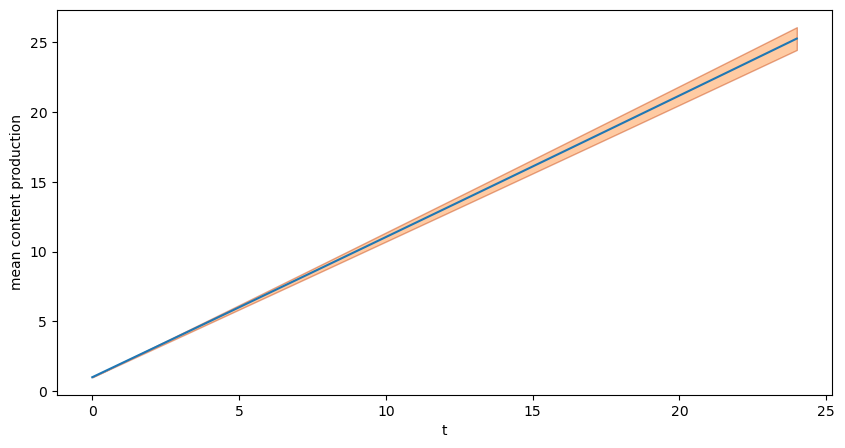

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


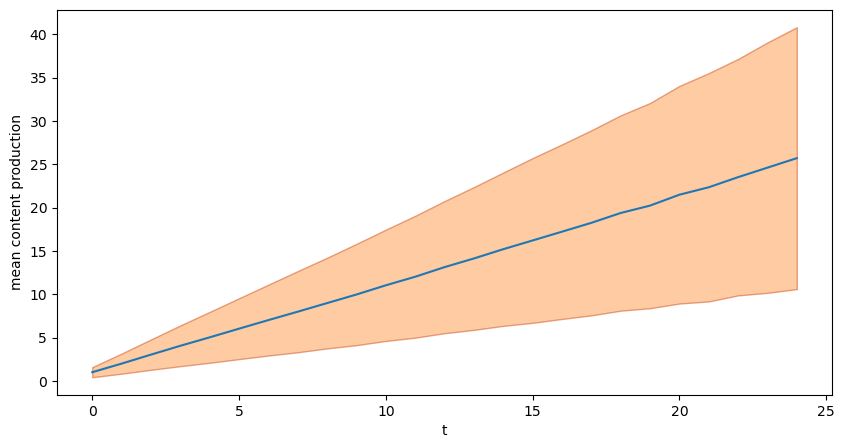

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


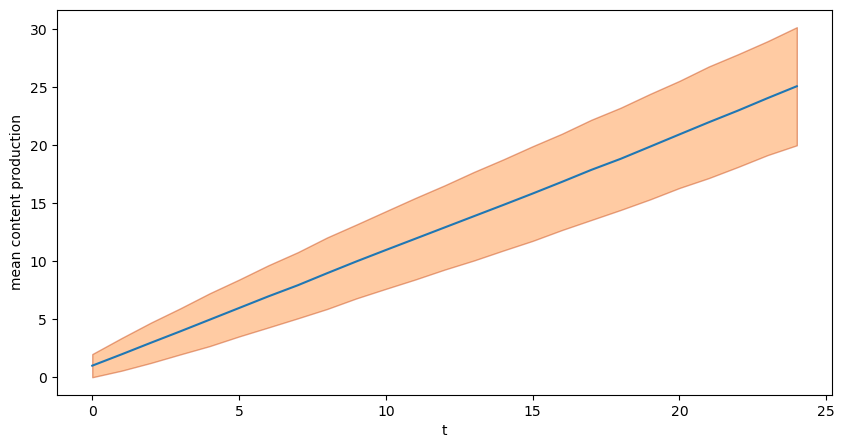

In [11]:
model = DotMap()
model.g = connected_watts_strogatz_graph(n=10_000, k=100, p=0.1).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25

model.post_production = lambda i, λ: λ
avg_posts_norand, posts_series_norand = simulate_network(model, steady_state_cut=0)

model.post_production = lambda i, λ: uniform.rvs(0, 2 * λ) # multiply by 2 so the mean is λ
avg_posts_uniform, posts_series_uniform = simulate_network(model, steady_state_cut=0)

model.post_production = lambda i, λ: poisson.rvs(λ)
avg_posts_poisson, posts_series_poisson = simulate_network(model, steady_state_cut=0)

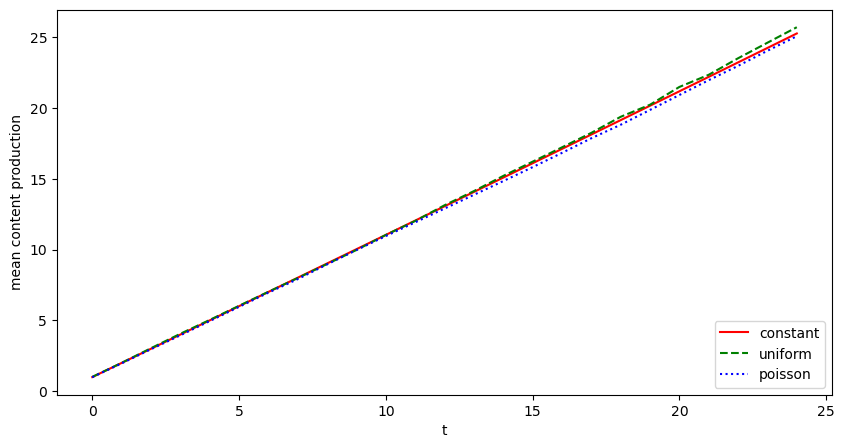

In [12]:
x = np.array(range(0, model.T))
plt.figure(figsize=(10, 5))
plt.xlabel('t')
plt.ylabel('mean content production')
plt.plot(x, avg_posts_norand,  'r-')
plt.plot(x, avg_posts_uniform, 'g--')
plt.plot(x, avg_posts_poisson, 'b:')
plt.legend([
    'constant',
    'uniform',
    'poisson',
], loc='lower right')
plt.show()

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


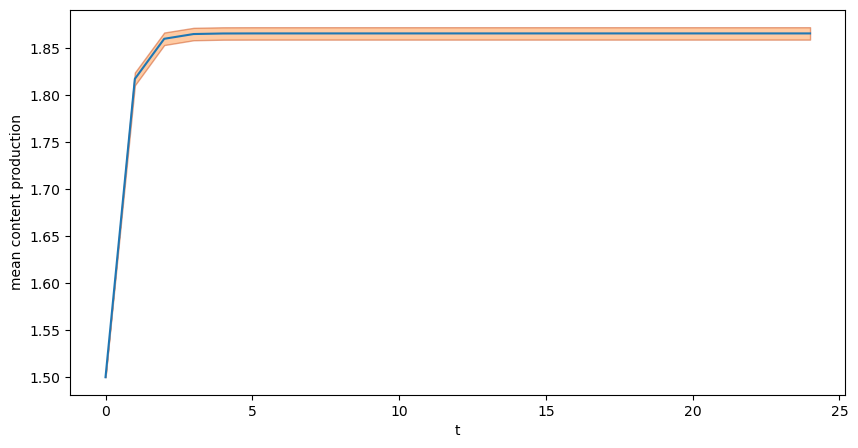

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


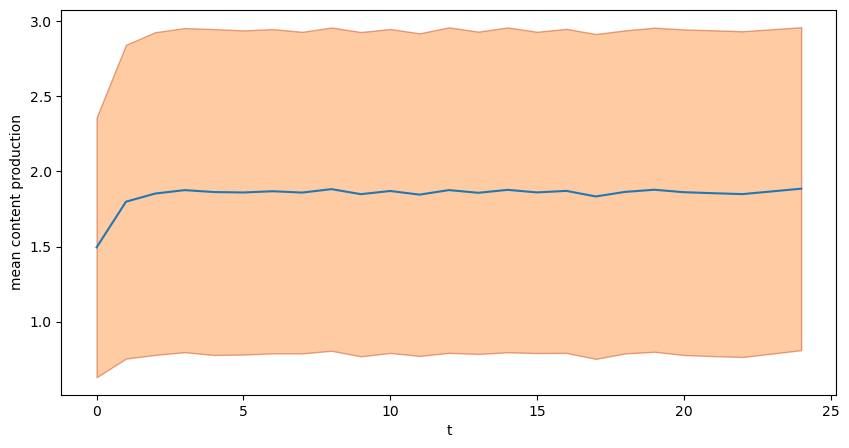

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


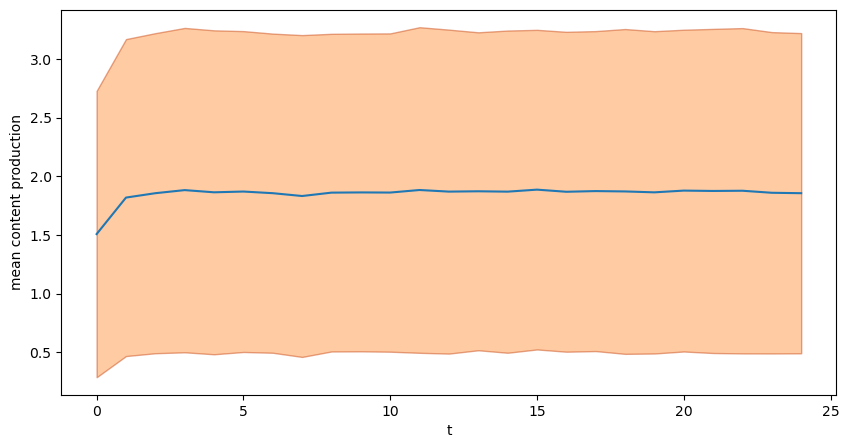

In [13]:
model = DotMap()
model.g = connected_watts_strogatz_graph(n=10_000, k=100, p=0.1).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: expit(model.ν_damp * sum(posts))
model.λ_int = lambda i: 1
model.T = 25

model.post_production = lambda i, λ: λ
avg_posts_norand, posts_series_norand = simulate_network(model, steady_state_cut=0)

model.post_production = lambda i, λ: uniform.rvs(0, 2 * λ) # multiply by 2 so the mean is λ
avg_posts_uniform, posts_series_uniform = simulate_network(model, steady_state_cut=0)

model.post_production = lambda i, λ: poisson.rvs(λ)
avg_posts_poisson, posts_series_poisson = simulate_network(model, steady_state_cut=0)

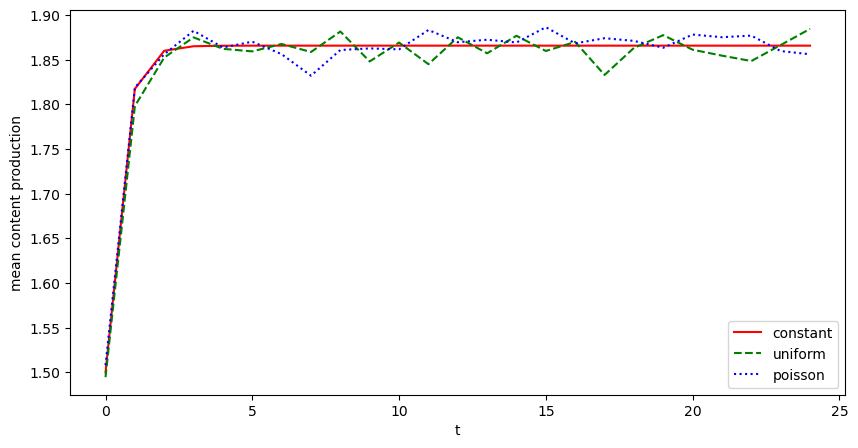

In [14]:
x = np.array(range(0, model.T))
plt.figure(figsize=(10, 5))
plt.xlabel('t')
plt.ylabel('mean content production')
plt.plot(x, avg_posts_norand,  'r-')
plt.plot(x, avg_posts_uniform, 'g--')
plt.plot(x, avg_posts_poisson, 'b:')
plt.legend([
    'constant',
    'uniform',
    'poisson',
], loc='lower right')
plt.show()

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


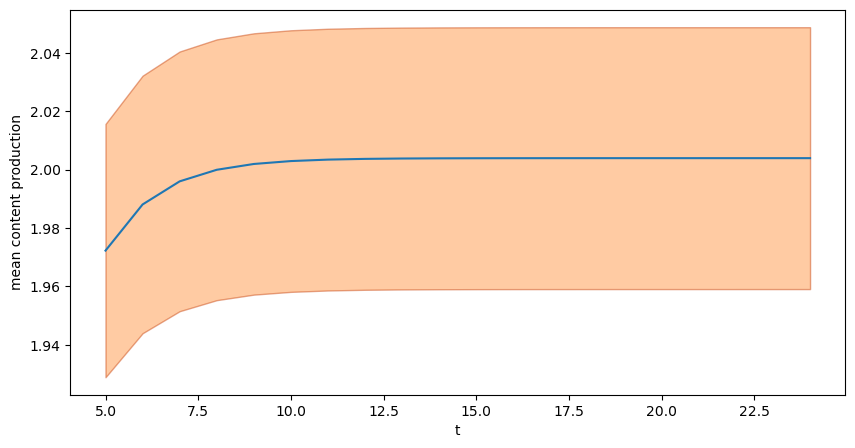

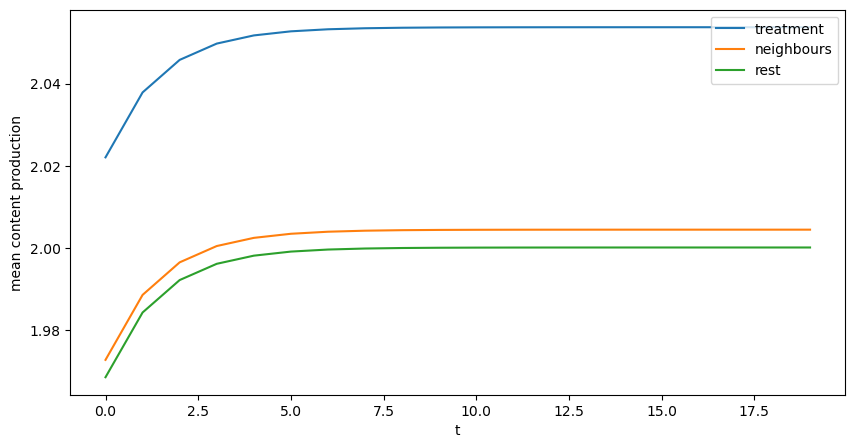

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


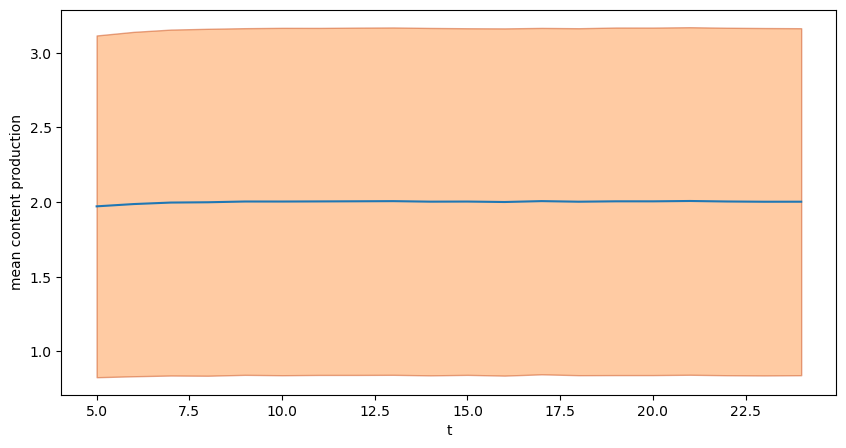

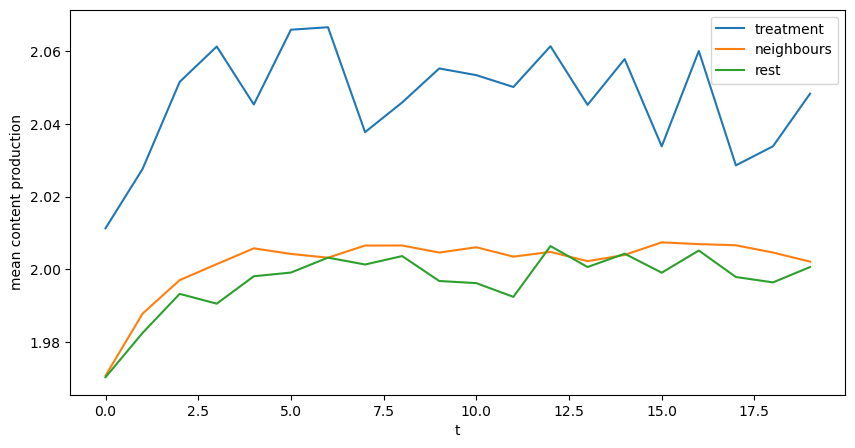

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


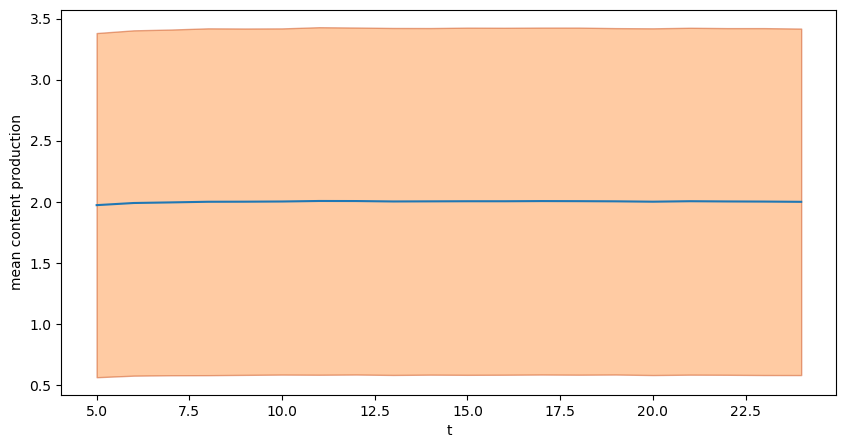

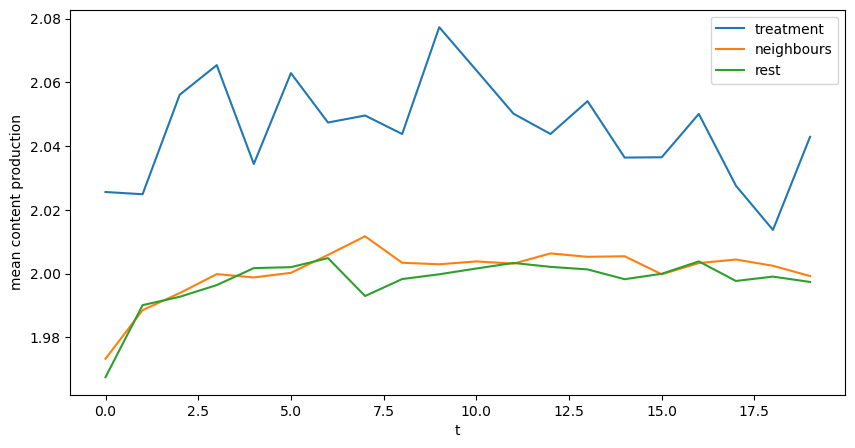

In [15]:
model = DotMap()
model.k = 50
model.p = 0.1
model.g = connected_watts_strogatz_graph(n=500_000, k=model.k, p=model.p).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.treatment_N = int(len(model.g.nodes) * 0.02)
model.nodes_treatment = set(random.sample(list(model.g.nodes), model.treatment_N))
model.nodes_treatment_neighbours = set([
    v2 for (v1, v2) in model.g.edges if v1 in model.nodes_treatment and v2 not in model.nodes_treatment])
model.nodes_rest = set(set(model.g.nodes) - (model.nodes_treatment | model.nodes_treatment_neighbours))
model.Δλ = 0.05

model.post_production = lambda i, λ: λ + model.Δλ * (1 if i in model.nodes_treatment else 0)
_, posts_series = simulate_network(model, steady_state_cut=5)
_, norand_treatment, _, norand_neighbours, norand_rest = group_post_productions(model, posts_series)

model.post_production = lambda i, λ: uniform.rvs(0, 2 * (λ + model.Δλ * (1 if i in model.nodes_treatment else 0)))
_, posts_series = simulate_network(model, steady_state_cut=5)
_, uniform_treatment, _, uniform_neighbours, uniform_rest = group_post_productions(model, posts_series)

model.post_production = lambda i, λ: poisson.rvs(λ + model.Δλ * (1 if i in model.nodes_treatment else 0))
_, posts_series = simulate_network(model, steady_state_cut=5)
_, poisson_treatment, _, poisson_neighbours, poisson_rest = group_post_productions(model, posts_series)

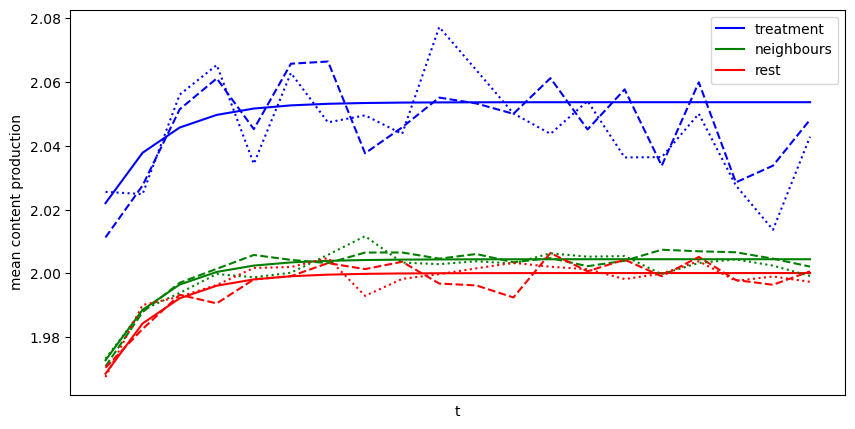

In [16]:
plt.figure(figsize=(10,5))
plt.xlabel('t')
plt.ylabel('mean content production')
plt.plot(norand_treatment,   'b-')
plt.plot(norand_neighbours,  'g-')
plt.plot(norand_rest,        'r-')
plt.plot(uniform_treatment,  'b--')
plt.plot(uniform_neighbours, 'g--')
plt.plot(uniform_rest,       'r--')
plt.plot(poisson_treatment,  'b:')
plt.plot(poisson_neighbours, 'g:')
plt.plot(poisson_rest,       'r:')
plt.legend([
   'treatment',
   'neighbours',
   'rest',
], loc='upper right')
plt.xticks([])
plt.show()

In [17]:
model_stats(model, norand_treatment, norand_neighbours, norand_rest)

Total nodes: 500000
Treatment:   10000
Control:     490000
Neighbours:  313507
Rest:        176493
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      2.0039208686908423
c_treatment:  2.0537340386692793
c_control:    2.00290427338516
c_neighbours: 2.0044669159108106
c_rest:       2.0001285294729985
---------------------------------
c_graph_prime:      1.0010143560525013
c_treatment_prime:  1.0258974235667764
c_control_prime:    1.0005065383481284
c_neighbours_prime: 1.0012871218661674
c_rest_prime:       0.9991199768584952
---------------------------------
e_spillover = 0.0005065383481284158
e_treatment = 0.025378030273114804
e_dampening = 0.5075606054622961
e_intrinsic = 0.02589742356677638


(2.001890239210256,
 2.0039208686908423,
 2.0537340386692793,
 2.00290427338516,
 2.0044669159108106,
 2.0001285294729985,
 0.0005065383481284158,
 0.025378030273114804,
 0.5075606054622961,
 0.02589742356677638)

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


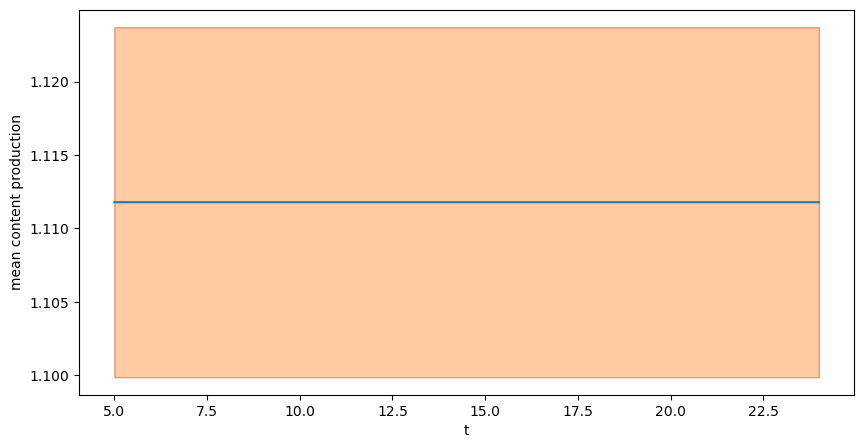

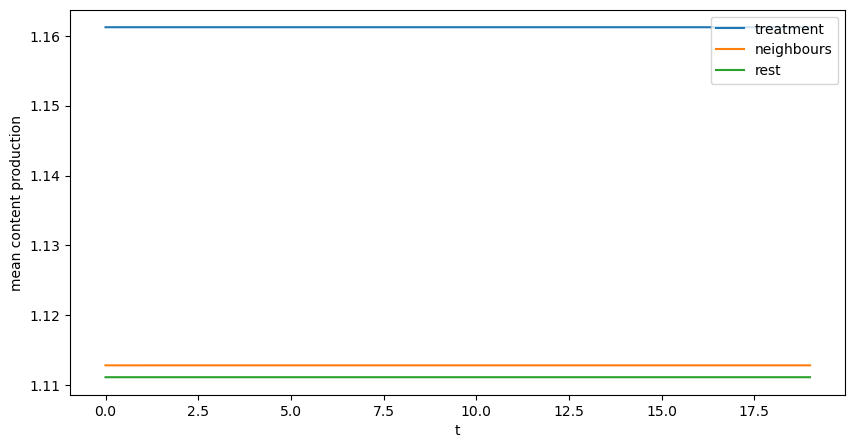

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


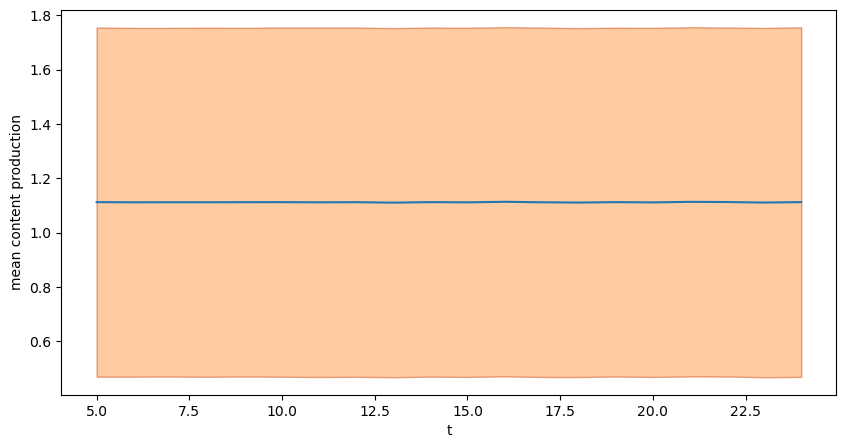

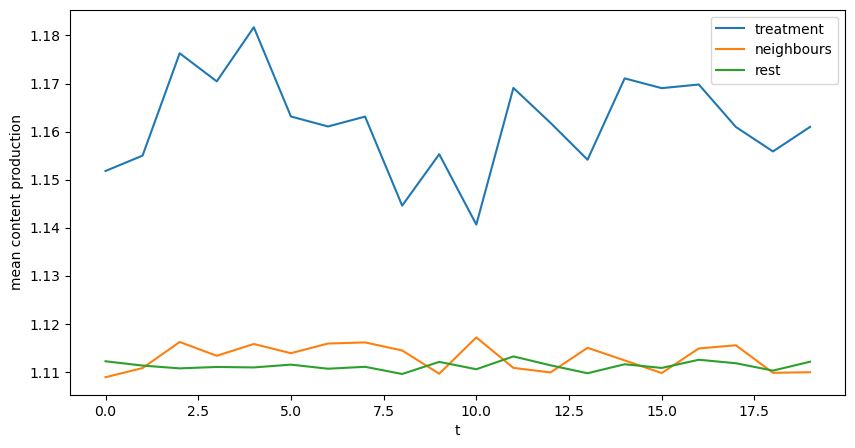

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


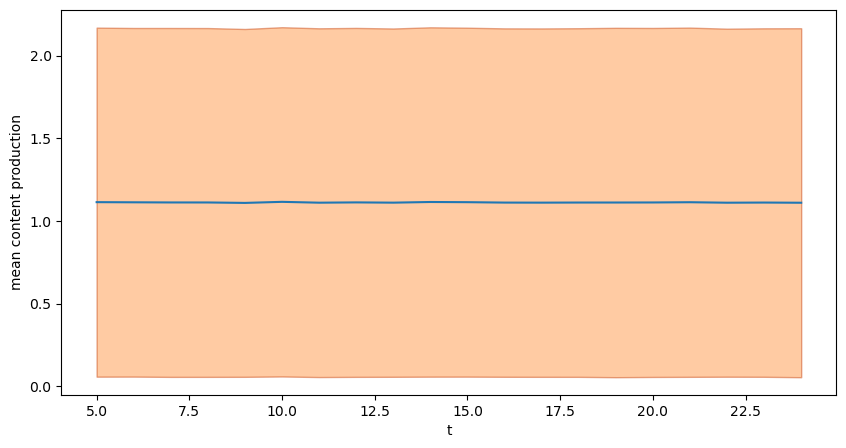

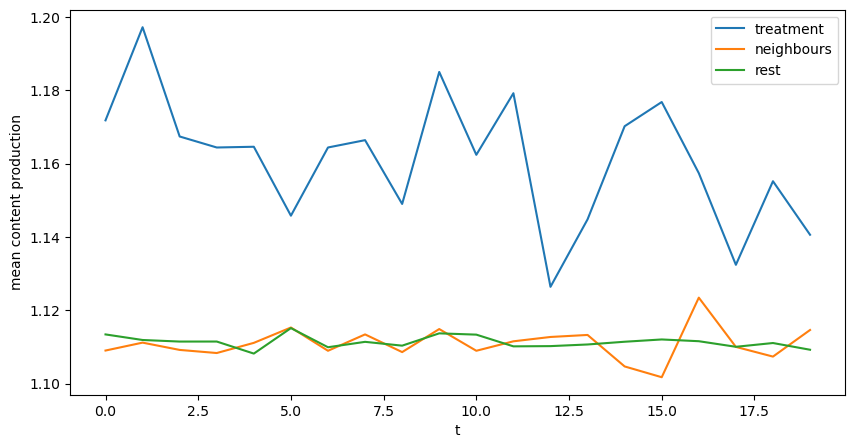

In [18]:
model = DotMap()
model.k = 10
model.p = 0.1
model.g = connected_watts_strogatz_graph(n=500_000, k=model.k, p=model.p).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.treatment_N = int(len(model.g.nodes) * 0.01)
model.nodes_treatment = set(random.sample(list(model.g.nodes), model.treatment_N))
model.nodes_treatment_neighbours = set([
    v2 for (v1, v2) in model.g.edges if v1 in model.nodes_treatment and v2 not in model.nodes_treatment])
model.nodes_rest = set(set(model.g.nodes) - (model.nodes_treatment | model.nodes_treatment_neighbours))
model.Δλ = 0.05

model.post_production = lambda i, λ: λ + model.Δλ * (1 if i in model.nodes_treatment else 0)
_, posts_series = simulate_network(model, steady_state_cut=5)
_, norand_treatment, _, norand_neighbours, norand_rest = group_post_productions(model, posts_series)

model.post_production = lambda i, λ: uniform.rvs(0, 2 * (λ + model.Δλ * (1 if i in model.nodes_treatment else 0)))
_, posts_series = simulate_network(model, steady_state_cut=5)
_, uniform_treatment, _, uniform_neighbours, uniform_rest = group_post_productions(model, posts_series)

model.post_production = lambda i, λ: poisson.rvs(λ + model.Δλ * (1 if i in model.nodes_treatment else 0))
_, posts_series = simulate_network(model, steady_state_cut=5)
_, poisson_treatment, _, poisson_neighbours, poisson_rest = group_post_productions(model, posts_series)

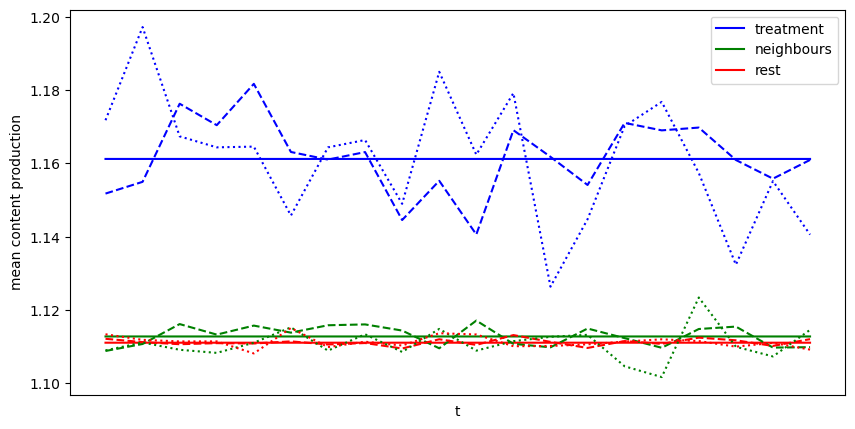

In [19]:
plt.figure(figsize=(10,5))
plt.xlabel('t')
plt.ylabel('mean content production')
plt.plot(norand_treatment,   'b-')
plt.plot(norand_neighbours,  'g-')
plt.plot(norand_rest,        'r-')
plt.plot(uniform_treatment,  'b--')
plt.plot(uniform_neighbours, 'g--')
plt.plot(uniform_rest,       'r--')
plt.plot(poisson_treatment,  'b:')
plt.plot(poisson_neighbours, 'g:')
plt.plot(poisson_rest,       'r:')
plt.legend([
   'treatment',
   'neighbours',
   'rest',
], loc='upper right')
plt.xticks([])
plt.show()

In [20]:
model_stats(model, norand_treatment, norand_neighbours, norand_rest)

Total nodes: 500000
Treatment:   5000
Control:     495000
Neighbours:  47275
Rest:        447725
---------------------------------
c_base:       1.1111111111111112
c_base_prime: 1.1112259188416231
c_graph:      1.111783659784667
c_treatment:  1.1612387235843473
c_control:    1.1112841136856804
c_neighbours: 1.1128220260429325
c_rest:       1.11112172649111
---------------------------------
c_graph_prime:      1.000501914987391
c_treatment_prime:  1.0450068738451126
c_control_prime:    1.000052369948424
c_neighbours_prime: 1.0014363480677027
c_rest_prime:       0.9999062365728278
---------------------------------
e_spillover = 5.2369948424058066e-05
e_treatment = 0.04495214975492434
e_dampening = 0.8990429950984868
e_intrinsic = 0.045006873845112594


(1.1112259188416231,
 1.111783659784667,
 1.1612387235843473,
 1.1112841136856804,
 1.1128220260429325,
 1.11112172649111,
 5.2369948424058066e-05,
 0.04495214975492434,
 0.8990429950984868,
 0.045006873845112594)

In [21]:
0.0014552330386814472/0.00015449433654746159

9.41932935020172

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


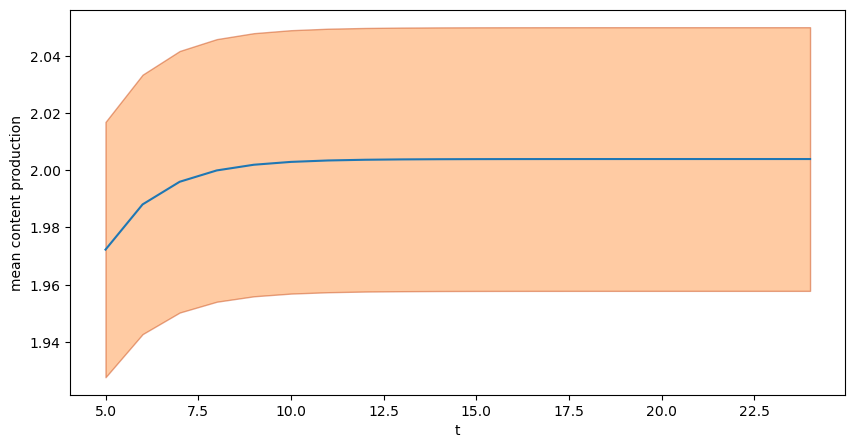

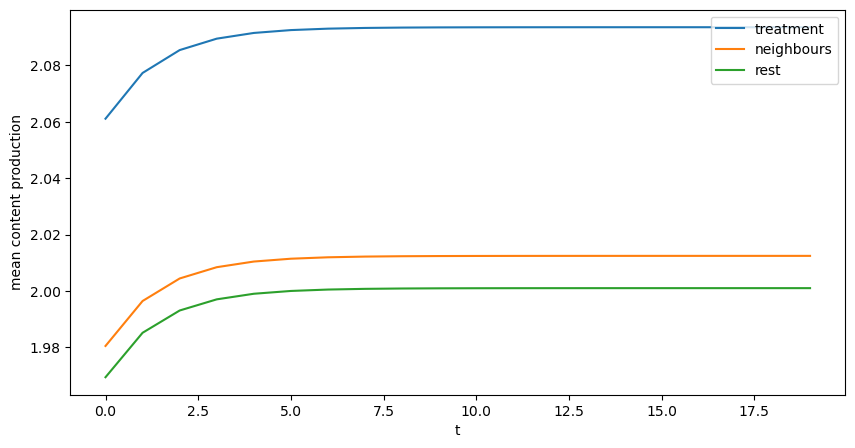

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


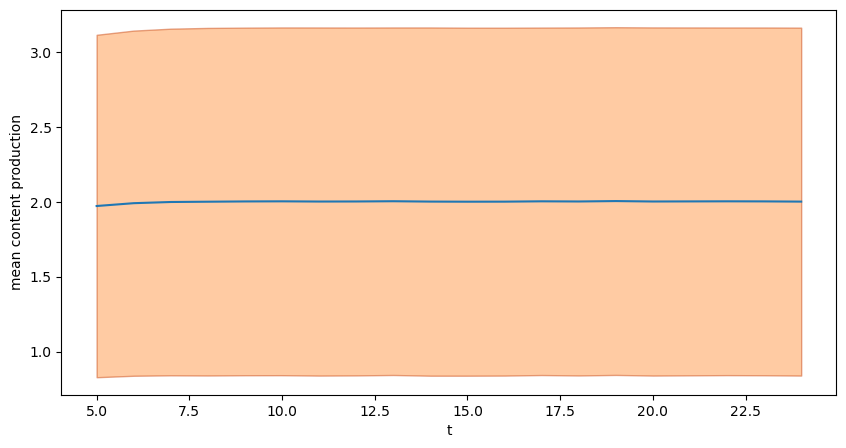

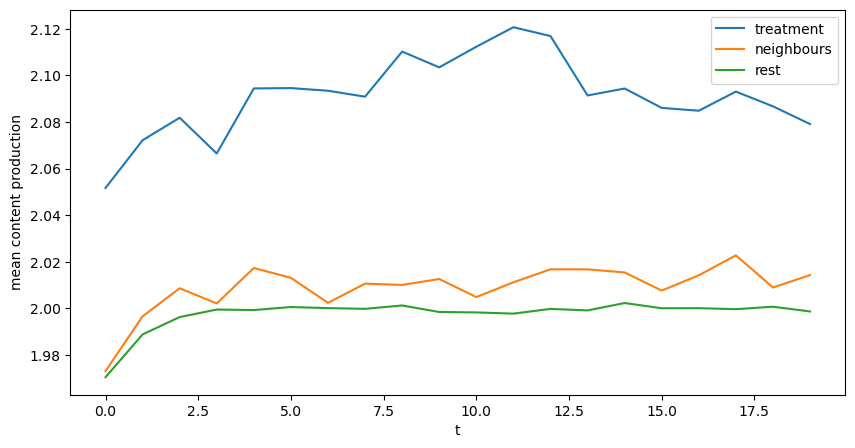

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


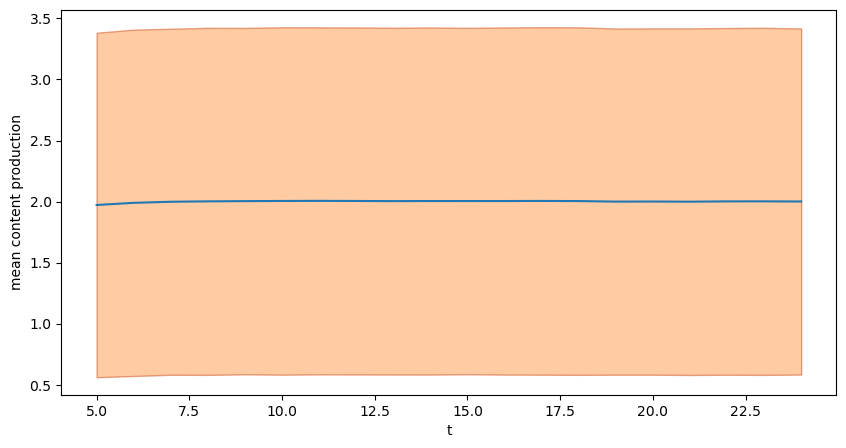

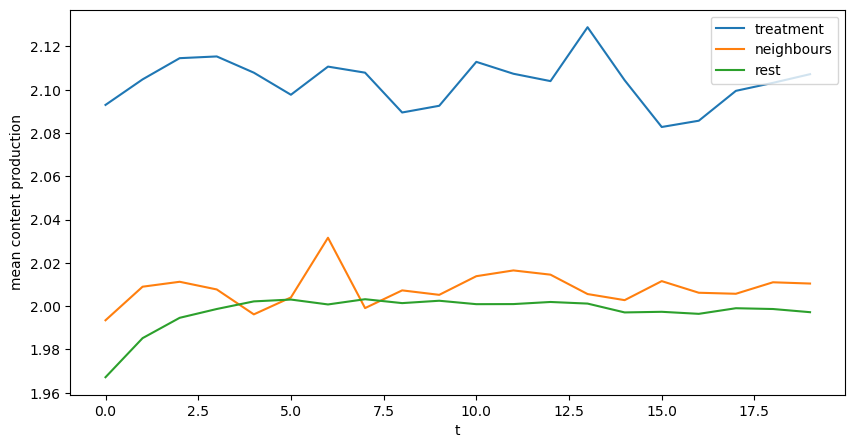

In [22]:
model = DotMap()
model.k = 50
model.p = 0.1
model.g = connected_watts_strogatz_graph(n=500_000, k=model.k, p=model.p).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.treatment_N = int(len(model.g.nodes) * 0.02)
model.nodes_treatment = set(list(model.g.nodes)[:model.treatment_N])
model.nodes_treatment_neighbours = set([
    v2 for (v1, v2) in model.g.edges if v1 in model.nodes_treatment and v2 not in model.nodes_treatment])
model.nodes_rest = set(set(model.g.nodes) - (model.nodes_treatment | model.nodes_treatment_neighbours))
model.Δλ = 0.05

model.post_production = lambda i, λ: λ + model.Δλ * (1 if i in model.nodes_treatment else 0)
_, posts_series = simulate_network(model, steady_state_cut=5)
_, norand_treatment, _, norand_neighbours, norand_rest = group_post_productions(model, posts_series)

model.post_production = lambda i, λ: uniform.rvs(0, 2 * (λ + model.Δλ * (1 if i in model.nodes_treatment else 0)))
_, posts_series = simulate_network(model, steady_state_cut=5)
_, uniform_treatment, _, uniform_neighbours, uniform_rest = group_post_productions(model, posts_series)

model.post_production = lambda i, λ: poisson.rvs(λ + model.Δλ * (1 if i in model.nodes_treatment else 0))
_, posts_series = simulate_network(model, steady_state_cut=5)
_, poisson_treatment, _, poisson_neighbours, poisson_rest = group_post_productions(model, posts_series)

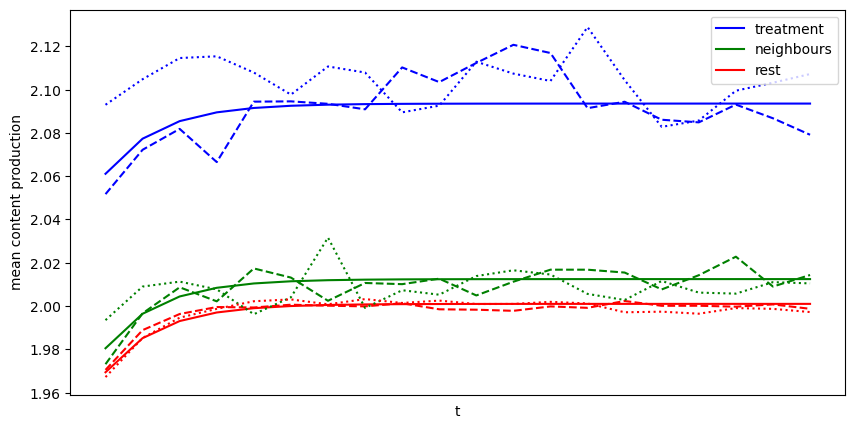

In [23]:
plt.figure(figsize=(10,5))
plt.xlabel('t')
plt.ylabel('mean content production')
plt.plot(norand_treatment,   'b-')
plt.plot(norand_neighbours,  'g-')
plt.plot(norand_rest,        'r-')
plt.plot(uniform_treatment,  'b--')
plt.plot(uniform_neighbours, 'g--')
plt.plot(uniform_rest,       'r--')
plt.plot(poisson_treatment,  'b:')
plt.plot(poisson_neighbours, 'g:')
plt.plot(poisson_rest,       'r:')
plt.legend([
   'treatment',
   'neighbours',
   'rest',
], loc='upper right')
plt.xticks([])
plt.show()

In [24]:
model_stats(model, norand_treatment, norand_neighbours, norand_rest)

Total nodes: 500000
Treatment:   10000
Control:     490000
Neighbours:  46545
Rest:        443455
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      2.003920295503557
c_treatment:  2.0935559892933524
c_control:    2.002090995630296
c_neighbours: 2.0124519315427216
c_rest:       2.001003512656727
---------------------------------
c_graph_prime:      1.0010140697294683
c_treatment_prime:  1.0457895983943948
c_control_prime:    1.000100283430184
c_neighbours_prime: 1.0052758598476568
c_rest_prime:       0.9995570553588998
---------------------------------
e_spillover = 0.00010028343018397834
e_treatment = 0.04568473354242397
e_dampening = 0.9136946708484794
e_intrinsic = 0.04578959839439478


(2.001890239210256,
 2.003920295503557,
 2.0935559892933524,
 2.002090995630296,
 2.0124519315427216,
 2.001003512656727,
 0.00010028343018397834,
 0.04568473354242397,
 0.9136946708484794,
 0.04578959839439478)

In [25]:
2.0927506951194204/2.0532346836685873-1

0.019245735407229958

In [26]:
0.00145/0.00015

9.666666666666666

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


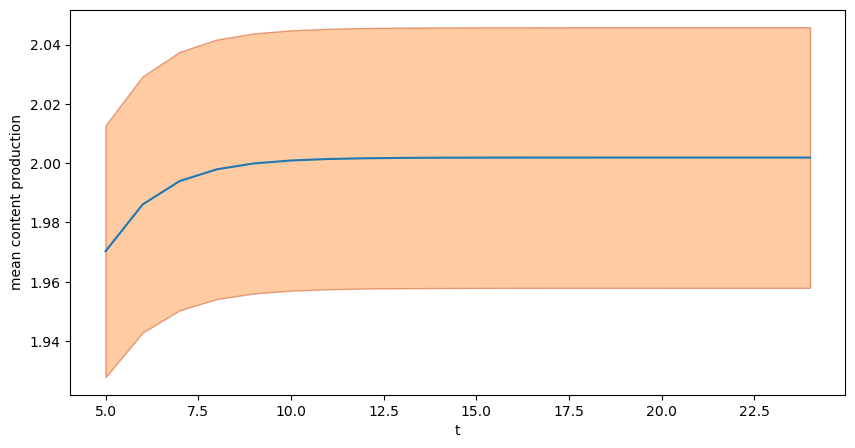

C:\Users\mtrencseni\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mtrencseni\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


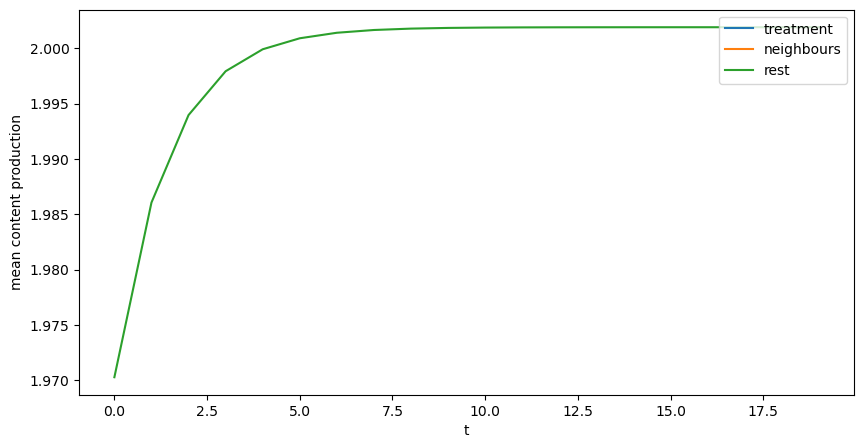

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.001897869225156
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       1.000003811405216
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


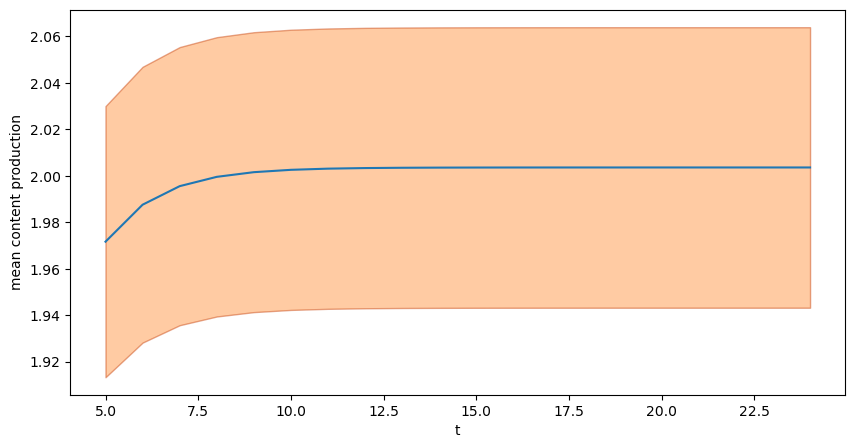

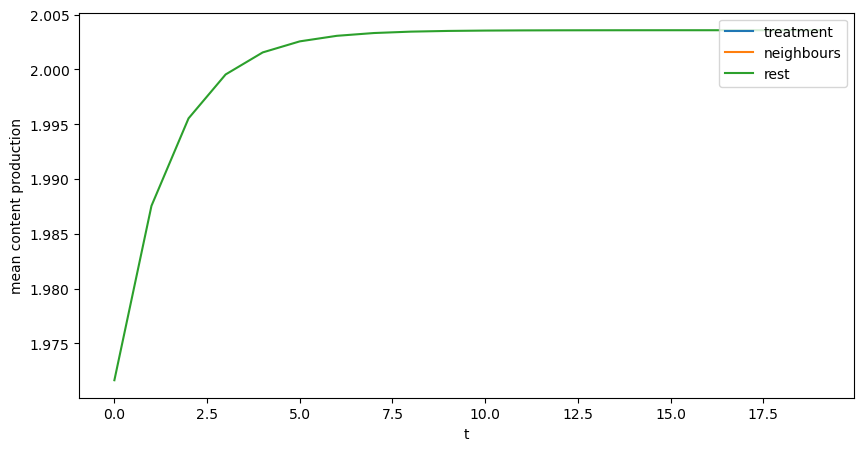

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.003543894433098
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.003570292857899
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       1.0000131758654625
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


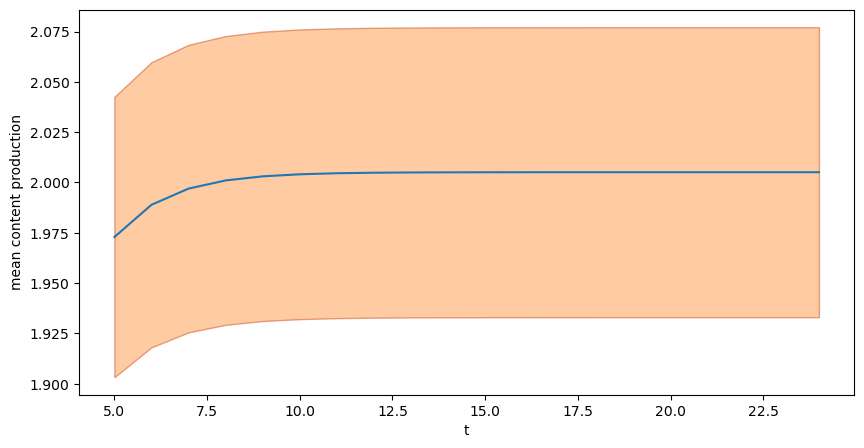

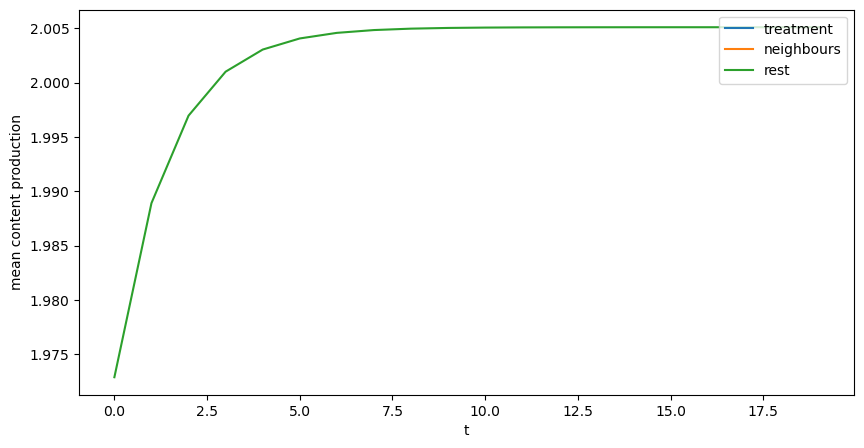

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.0050963467954226
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.005104844777985
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       1.000004238191634
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


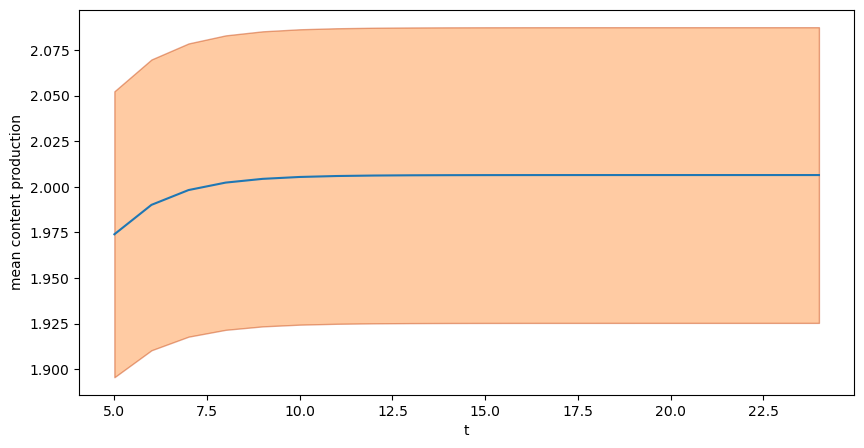

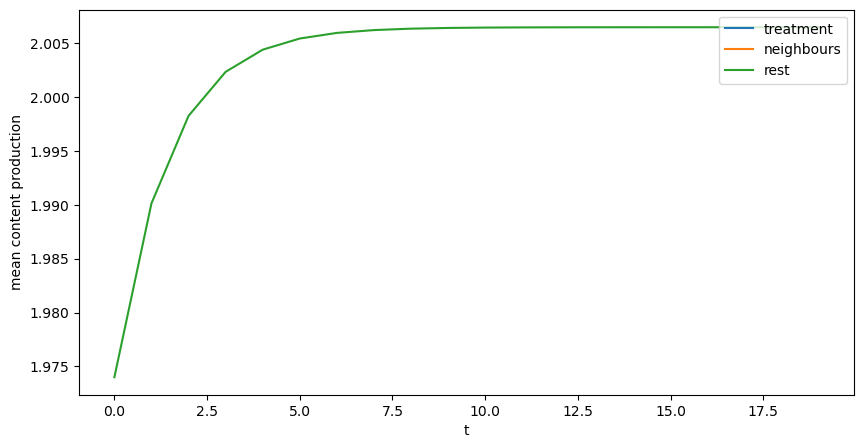

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.006508606637987
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.006480785546151
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       0.9999861345763761
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


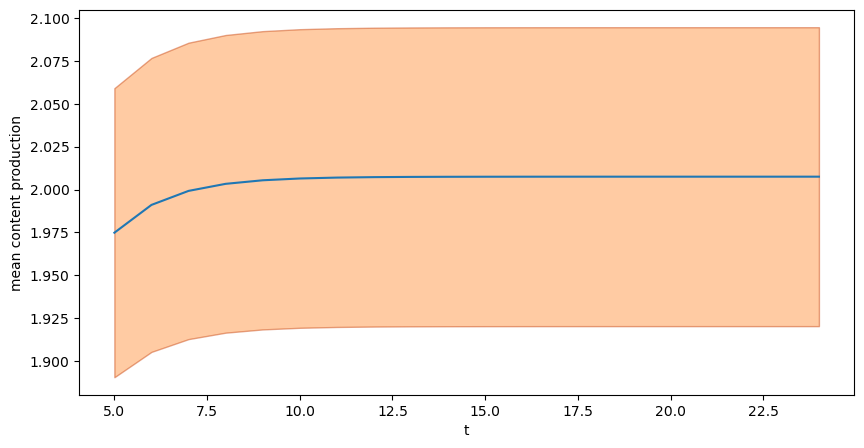

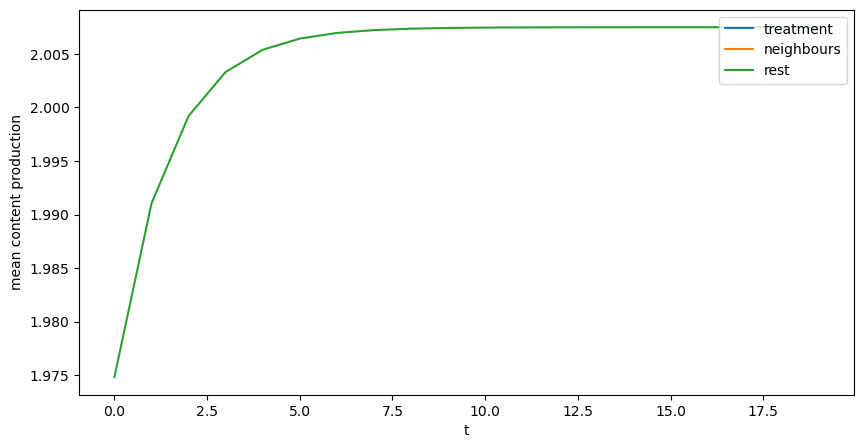

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.007454108030194
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.0074889557448676
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       1.0000173591588142
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


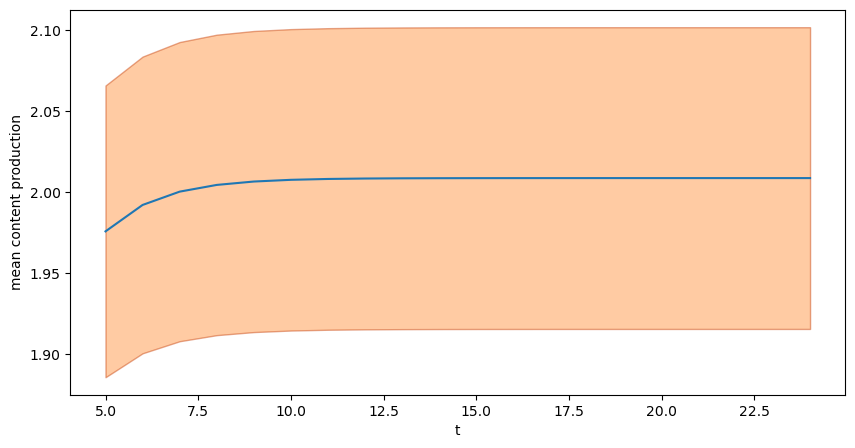

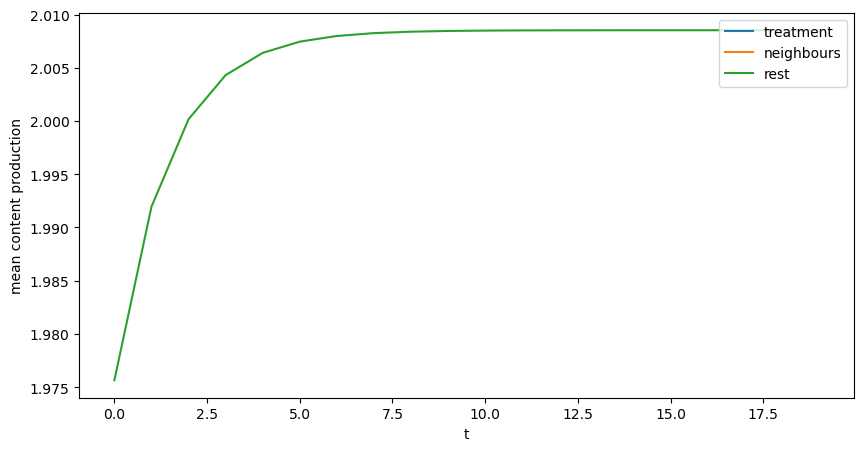

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.00835923669183
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.008531852781383
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       1.0000859488115468
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


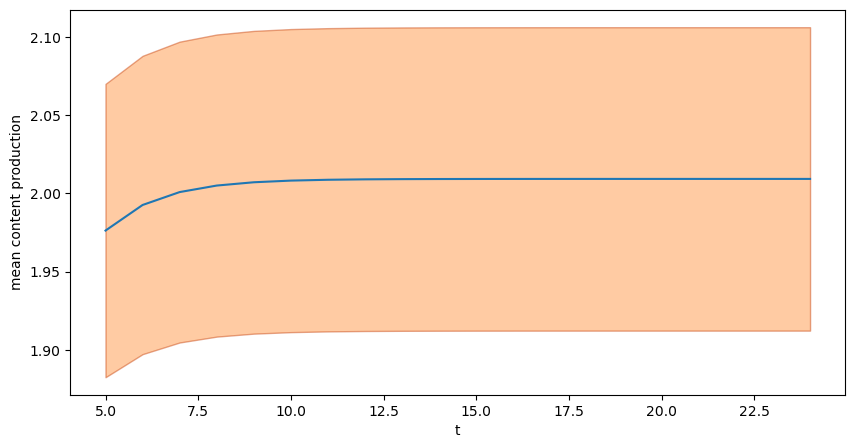

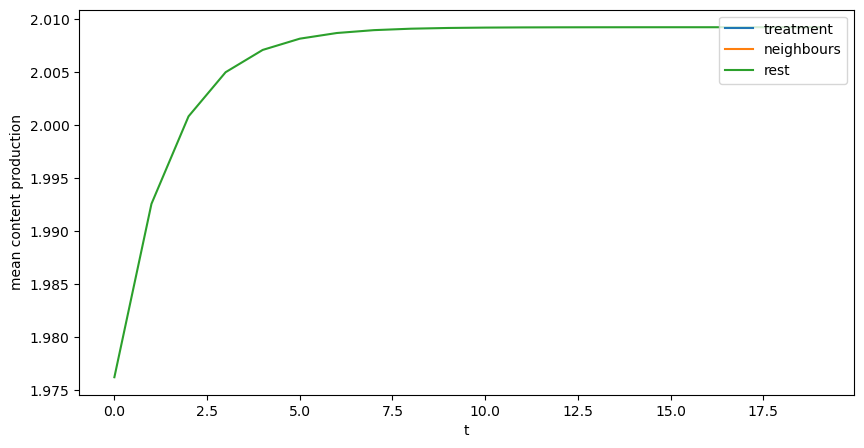

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.0089429524813407
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.0092688546832913
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       1.000162225712556
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


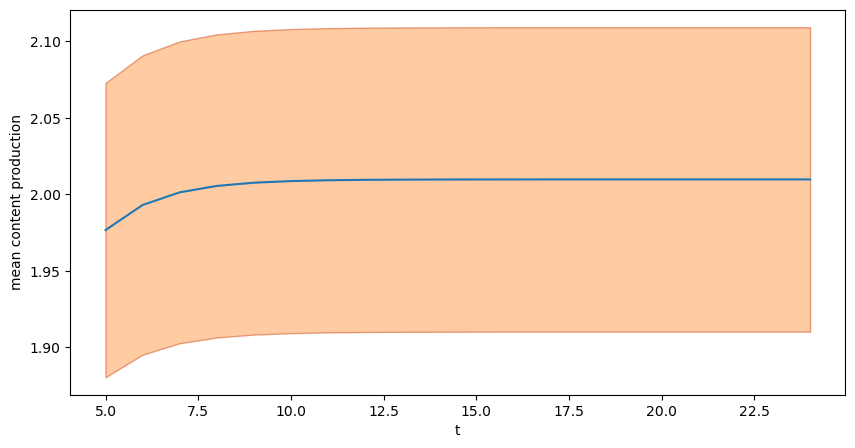

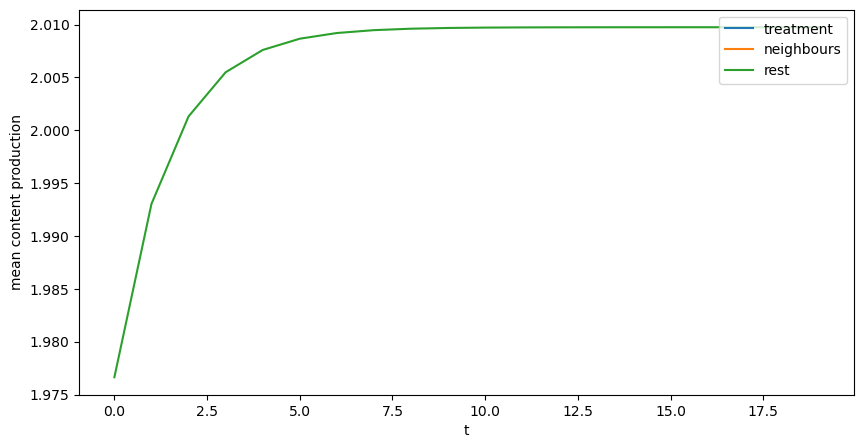

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.0092607324086473
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.0097537453197405
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       1.0002453703011964
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


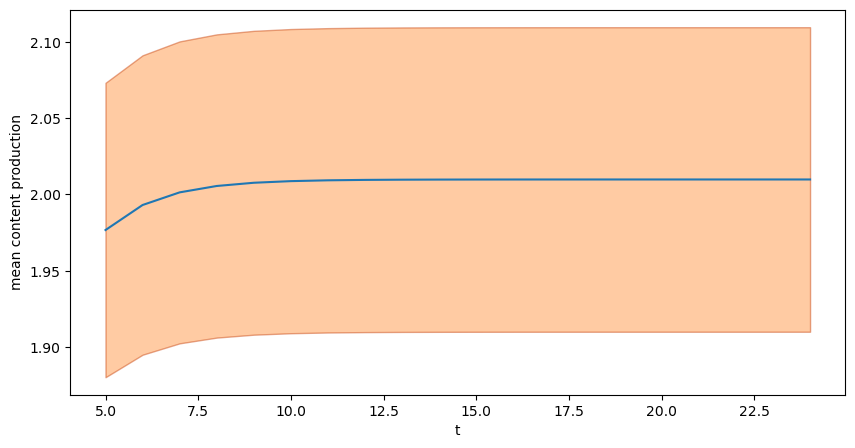

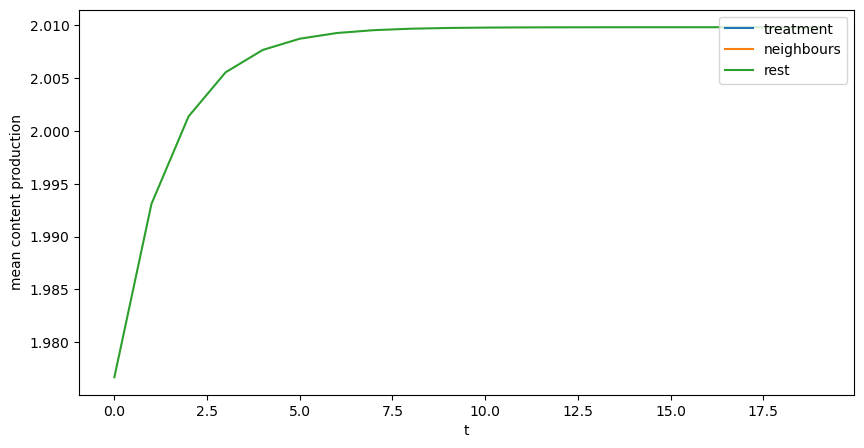

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.0100891609827283
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.0098161726493524
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       0.9998641909330817
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


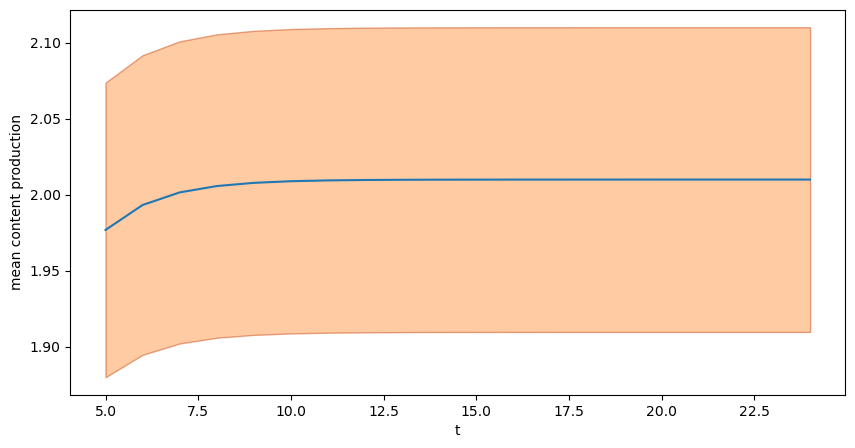

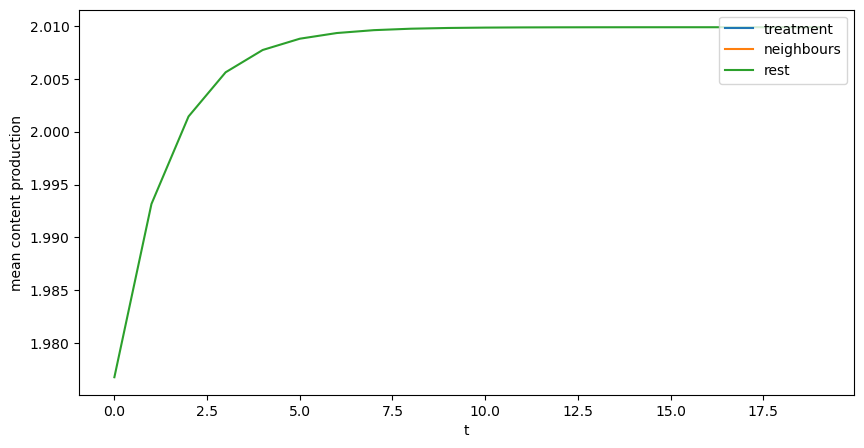

Total nodes: 10000
Treatment:   0
Control:     10000
Neighbours:  0
Rest:        10000
---------------------------------
c_base:       2.0
c_base_prime: 2.010342478975241
c_graph:      nan
c_treatment:  nan
c_control:    nan
c_neighbours: nan
c_rest:       2.0098944698396926
---------------------------------
c_graph_prime:      nan
c_treatment_prime:  nan
c_control_prime:    nan
c_neighbours_prime: nan
c_rest_prime:       0.9997771478540429
---------------------------------
e_spillover = nan
e_treatment = nan
e_dampening = nan
e_intrinsic = nan


In [27]:
def degree_distribution(g):
    ds = Counter(sorted([d for n, d in g.degree()], reverse=True))
    return [x for x in zip(*ds.items())]

def calculate_model_metrics(n, k, p):
    model = DotMap()
    model.k = k
    model.p = p
    model.g = connected_watts_strogatz_graph(n, model.k, model.p).to_directed()
    model.ν_damp = 0.01
    model.ν = lambda posts: model.ν_damp * sum(posts)
    model.λ_int = lambda i: 1
    model.T = 25
    model.treatment_N = 0
    model.nodes_treatment = set(random.sample(list(model.g.nodes), model.treatment_N))
    model.nodes_treatment_neighbours = set([
        v2 for (v1, v2) in model.g.edges if v1 in model.nodes_treatment and v2 not in model.nodes_treatment])
    model.nodes_rest = set(set(model.g.nodes) - (model.nodes_treatment | model.nodes_treatment_neighbours))
    model.Δλ = 0.05
    model.post_production = lambda i, λ: λ + model.Δλ * (1 if i in model.nodes_treatment else 0)
    _, posts_series = simulate_network(model, steady_state_cut=5)
    _, norand_treatment, _, norand_neighbours, norand_rest = group_post_productions(model, posts_series)
    return degree_distribution(model.g), model_stats(model, norand_treatment, norand_neighbours, norand_rest)

n = 10_000
k = 50
ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results = [(p, calculate_model_metrics(n, k, p)) for p in ps]

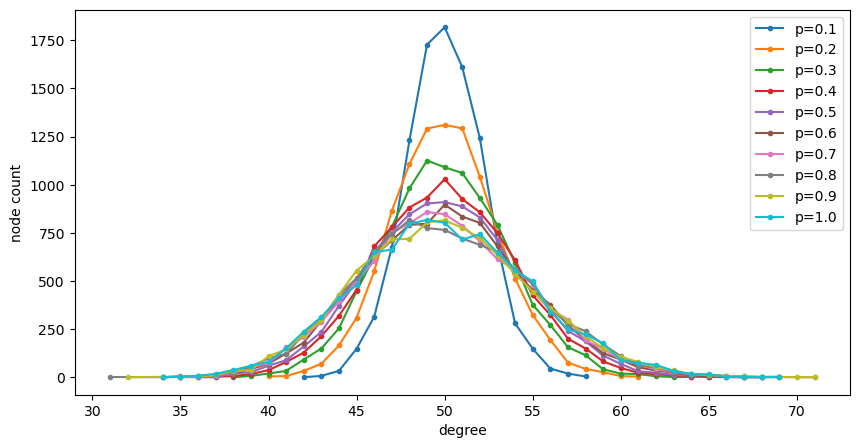

In [28]:
plt.figure(figsize=(10,5))
plt.xlabel('degree')
plt.ylabel('node count')
for x in results:
    plt.plot([d/2 for d in list(x[1][0][0])], list(x[1][0][1]), marker='.')
plt.legend(['p=%s' % x[0] for x in results])
plt.show() 

In [29]:
results

[(0.1,
  ([(116,
     114,
     112,
     110,
     108,
     106,
     104,
     102,
     100,
     98,
     96,
     94,
     92,
     90,
     88,
     86,
     84),
    (5,
     20,
     46,
     149,
     280,
     691,
     1241,
     1610,
     1818,
     1728,
     1230,
     675,
     315,
     149,
     34,
     8,
     1)],
   (2.001890239210256,
    nan,
    nan,
    nan,
    nan,
    2.001897869225156,
    nan,
    nan,
    nan,
    nan))),
 (0.2,
  ([(122,
     120,
     118,
     116,
     114,
     112,
     110,
     108,
     106,
     104,
     102,
     100,
     98,
     96,
     94,
     92,
     90,
     88,
     86,
     84,
     82,
     80),
    (4,
     7,
     27,
     44,
     77,
     195,
     324,
     513,
     756,
     1041,
     1293,
     1311,
     1292,
     1107,
     865,
     551,
     310,
     166,
     71,
     34,
     7,
     5)],
   (2.003543894433098,
    nan,
    nan,
    nan,
    nan,
    2.003570292857899,
    nan,
    nan,
    nan,


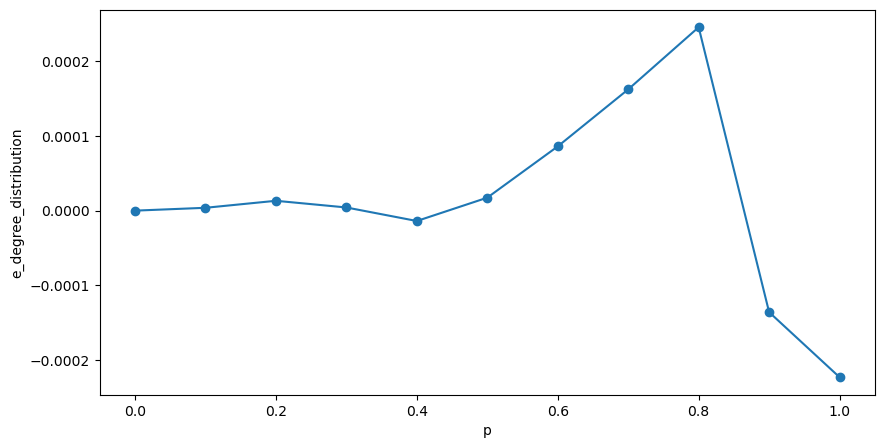

In [30]:
plt.figure(figsize=(10,5))
plt.xlabel('p')
plt.ylabel('e_degree_distribution')
plt.plot([0] + [x[0] for x in results], [0] + [x[1][1][5]/x[1][1][0]-1 for x in results], marker='o')
plt.show() 

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


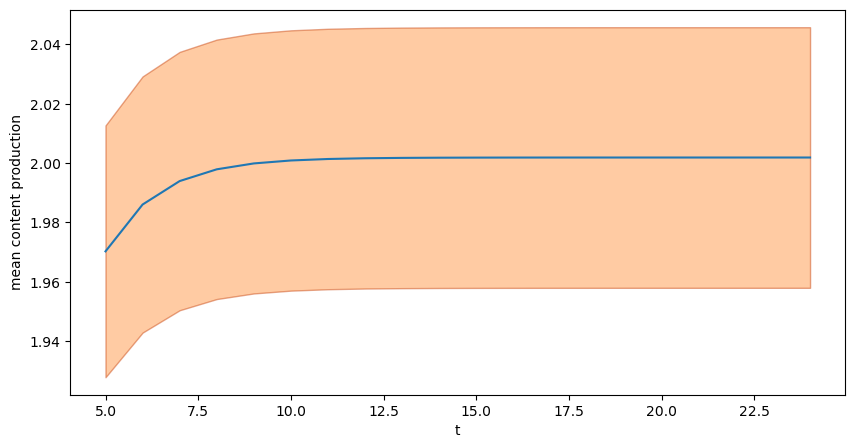

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


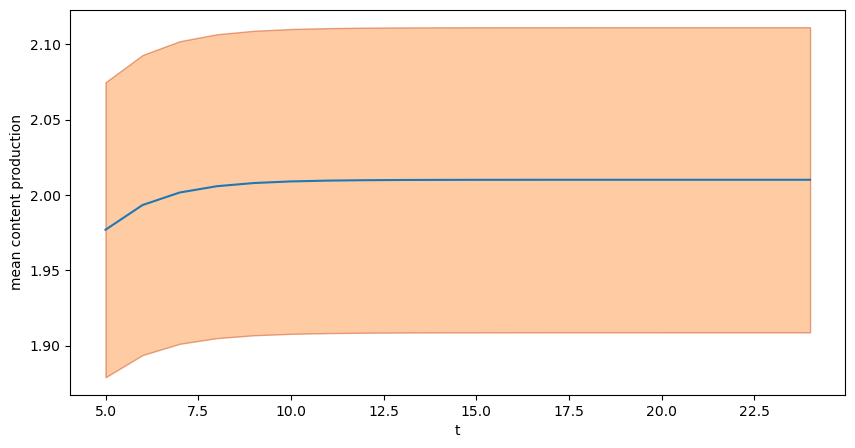

In [31]:
model = DotMap()
model.k = 50
model.p = 0.1
model.g = connected_watts_strogatz_graph(n=10_000, k=model.k, p=model.p).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.treatment_N = 0
model.nodes_treatment = set()
model.nodes_treatment_neighbours = set()
model.nodes_rest = set(set(model.g.nodes))
model.Δλ = 0.0
model.post_production = lambda i, λ: λ
_, posts_series01 = simulate_network(model, steady_state_cut=5)
model01 = copy.deepcopy(model)

model = DotMap()
model.k = 50
model.p = 0.9
model.g = connected_watts_strogatz_graph(n=10_000, k=model.k, p=model.p).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.treatment_N = 0
model.nodes_treatment = set()
model.nodes_treatment_neighbours = set()
model.nodes_rest = set(set(model.g.nodes))
model.Δλ = 0.0
model.post_production = lambda i, λ: λ
_, posts_series09 = simulate_network(model, steady_state_cut=5)
model09 = copy.deepcopy(model)

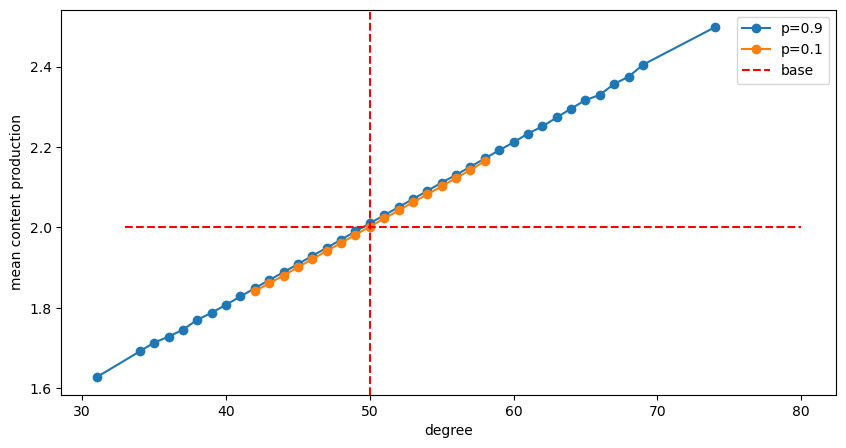

In [32]:
def compute_degree_to_cp(model, posts_series):
    degree_to_cp_list = defaultdict(lambda: [])
    for i in model.g.nodes:
        degree = len([n for n in model.g.neighbors(i)])
        cp = posts_series[-1][i]
        degree_to_cp_list[degree].append(cp)
    degree_to_cp = {}
    for degree, cp_list in degree_to_cp_list.items():
         mean_cp = np.mean(cp_list)
         degree_to_cp[degree] = mean_cp
    return degree_to_cp

degree_to_cp01 = compute_degree_to_cp(model01, posts_series01)
degree_to_cp09 = compute_degree_to_cp(model09, posts_series09)
plt.figure(figsize=(10, 5))
plt.xlabel('degree')
plt.ylabel('mean content production')
plt.plot([d for d in sorted(degree_to_cp09)], [degree_to_cp09[d] for d in sorted(degree_to_cp09)], marker='o')
plt.plot([d for d in sorted(degree_to_cp01)], [degree_to_cp01[d] for d in sorted(degree_to_cp01)], marker='o')
plt.plot([x for x in range(33, 81)], [2.0 for _ in range(33, 81)], 'r--')
plt.axvline(x=50, color='r', linestyle='--', label='mean degree')
plt.legend([
    'p=0.9',
    'p=0.1',
    'base'
    ])
plt.show() 

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


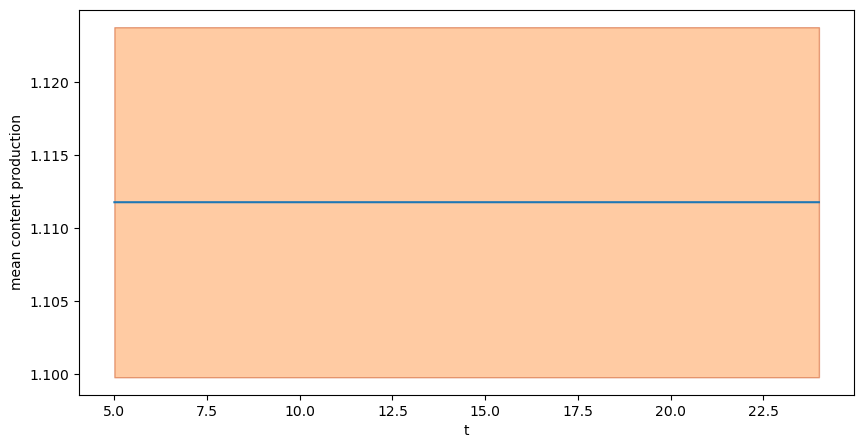

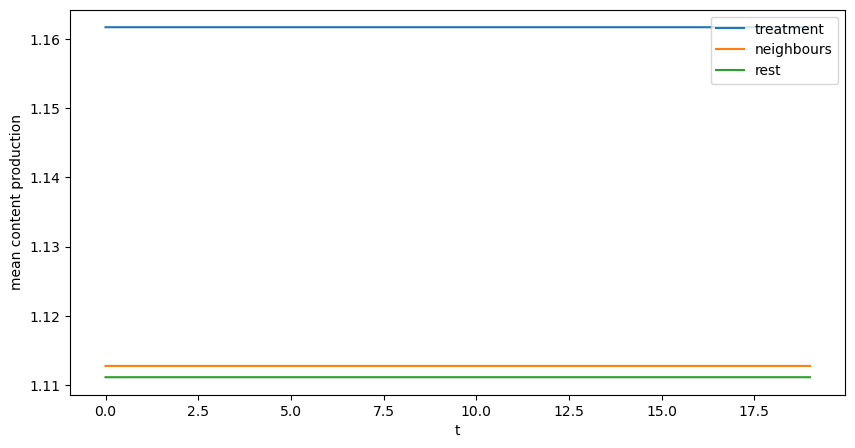

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  942
Rest:        8958
---------------------------------
c_base:       1.1111111111111112
c_base_prime: 1.1112259188416231
c_graph:      1.1117850279386319
c_treatment:  1.1616687643489312
c_control:    1.1112811518132752
c_neighbours: 1.112758335840128
c_rest:       1.111125814979909
---------------------------------
c_graph_prime:      1.000503146198742
c_treatment_prime:  1.0453938705460464
c_control_prime:    1.000049704538668
c_neighbours_prime: 1.0013790328073902
c_rest_prime:       0.9999099158325803
---------------------------------
e_spillover = 4.970453866803837e-05
e_treatment = 0.04534191230854456
e_dampening = 0.9068382461708913
e_intrinsic = 0.04539387054604638
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


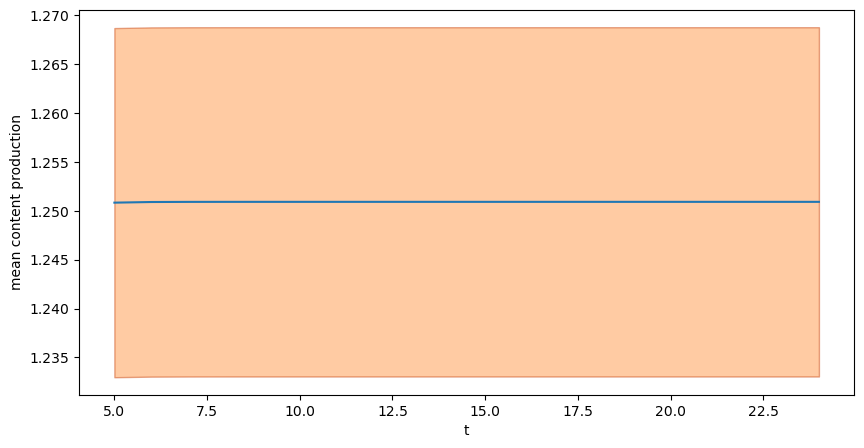

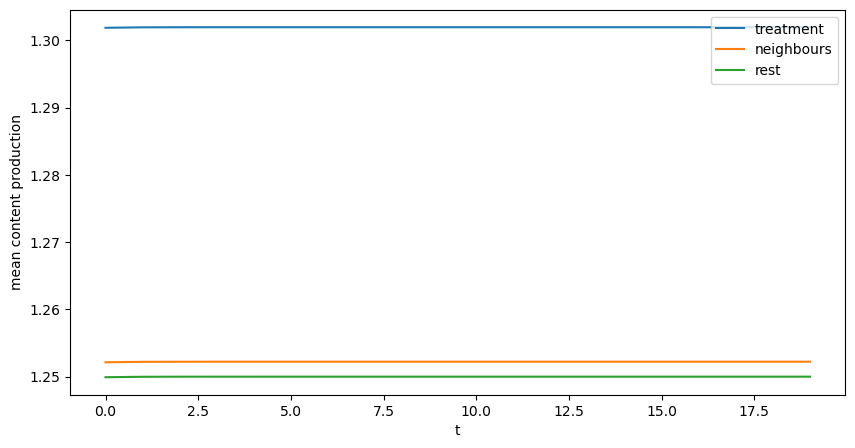

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  1813
Rest:        8087
---------------------------------
c_base:       1.25
c_base_prime: 1.2502972644386683
c_graph:      1.250916382659561
c_treatment:  1.3019736652174208
c_control:    1.2504006525327138
c_neighbours: 1.252218376131045
c_rest:       1.2499931425928381
---------------------------------
c_graph_prime:      1.000495176817947
c_treatment_prime:  1.0413312915644528
c_control_prime:    1.0000826908104066
c_neighbours_prime: 1.0015365239507577
c_rest_prime:       0.9997567603685299
---------------------------------
e_spillover = 8.269081040657156e-05
e_treatment = 0.041245190155847045
e_dampening = 0.8249038031169409
e_intrinsic = 0.04133129156445281
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


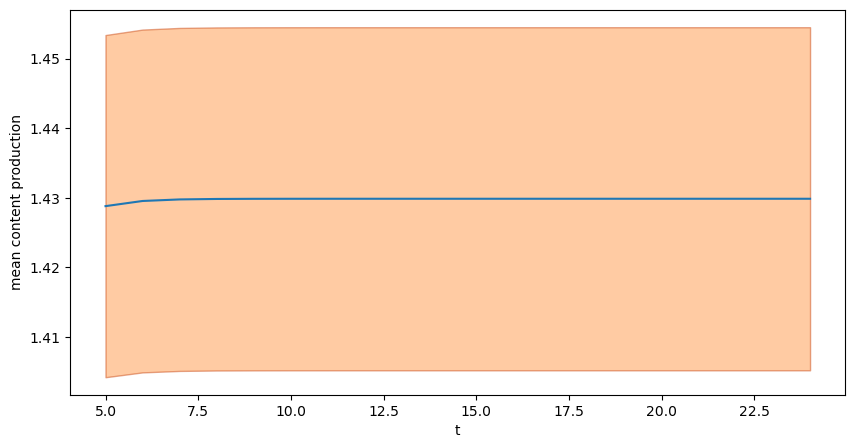

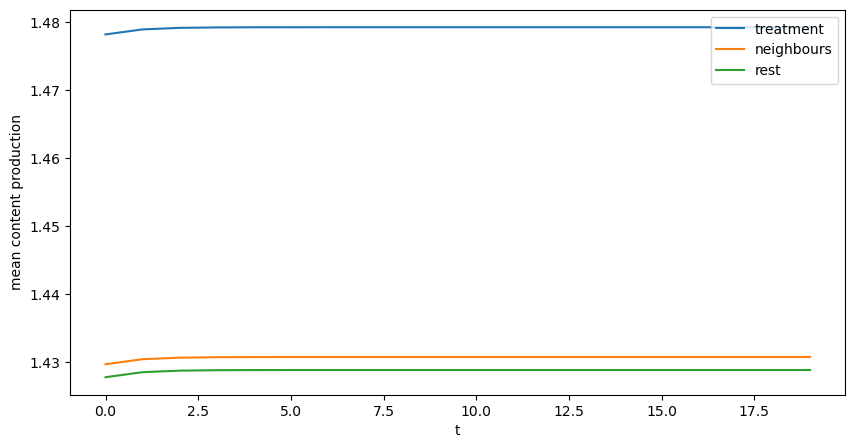

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  2572
Rest:        7328
---------------------------------
c_base:       1.4285714285714286
c_base_prime: 1.4291710498552475
c_graph:      1.4298635523559329
c_treatment:  1.4791974743800653
c_control:    1.429365229911245
c_neighbours: 1.430776986110435
c_rest:       1.428869728144826
---------------------------------
c_graph_prime:      1.0004845483686193
c_treatment_prime:  1.035003804848891
c_control_prime:    1.0001358690102329
c_neighbours_prime: 1.001123683729355
c_rest_prime:       0.9997891632982266
---------------------------------
e_spillover = 0.00013586901023288078
e_treatment = 0.03486319901031498
e_dampening = 0.6972639802062996
e_intrinsic = 0.035003804848890985
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


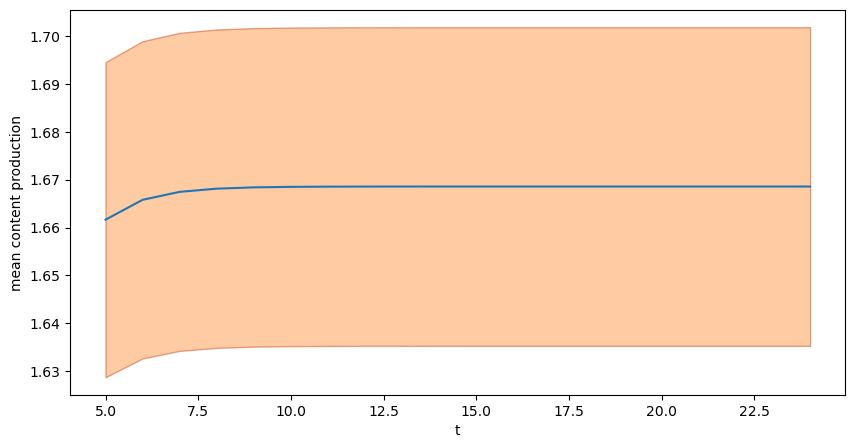

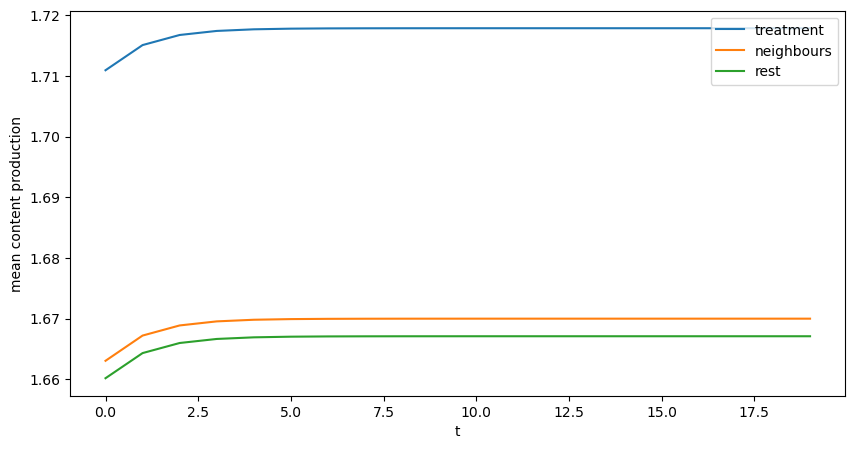

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  3343
Rest:        6557
---------------------------------
c_base:       1.6666666666666667
c_base_prime: 1.667744159742101
c_graph:      1.6685661213206906
c_treatment:  1.7178443344540275
c_control:    1.668068361592071
c_neighbours: 1.6699876154901914
c_rest:       1.6670898552962932
---------------------------------
c_graph_prime:      1.0004928583163
c_treatment_prime:  1.0300406836499874
c_control_prime:    1.0001943954341415
c_neighbours_prime: 1.0013452037801993
c_rest_prime:       0.9996076709716022
---------------------------------
e_spillover = 0.00019439543414145888
e_treatment = 0.029840487361350254
e_dampening = 0.5968097472270051
e_intrinsic = 0.030040683649987354
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


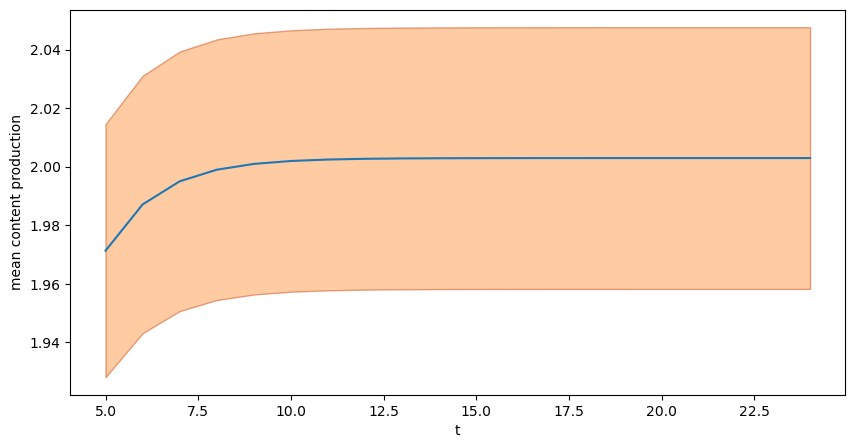

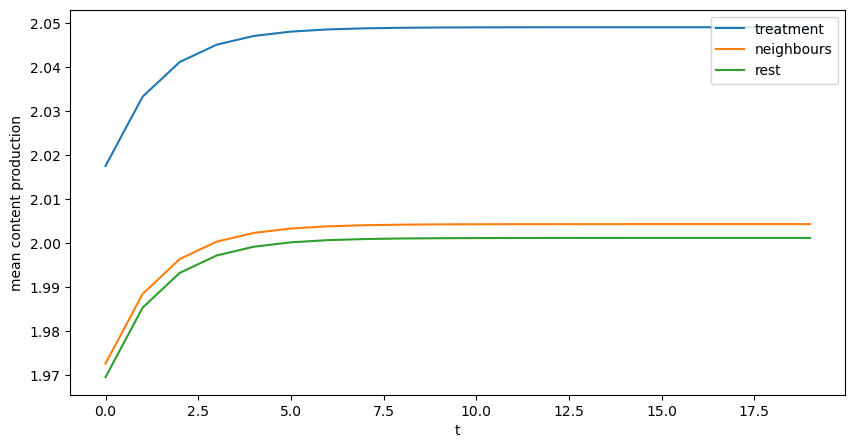

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  3935
Rest:        5965
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      2.0029397954595383
c_treatment:  2.0490580471364206
c_control:    2.0024739545335093
c_neighbours: 2.0043650265820023
c_rest:       2.001226449334713
---------------------------------
c_graph_prime:      1.0005242826148633
c_treatment_prime:  1.0235616353995374
c_control_prime:    1.0002915820816847
c_neighbours_prime: 1.001236225305101
c_rest_prime:       0.9996684184464554
---------------------------------
e_spillover = 0.0002915820816846715
e_treatment = 0.023263270165110983
e_dampening = 0.46526540330221966
e_intrinsic = 0.023561635399537373
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


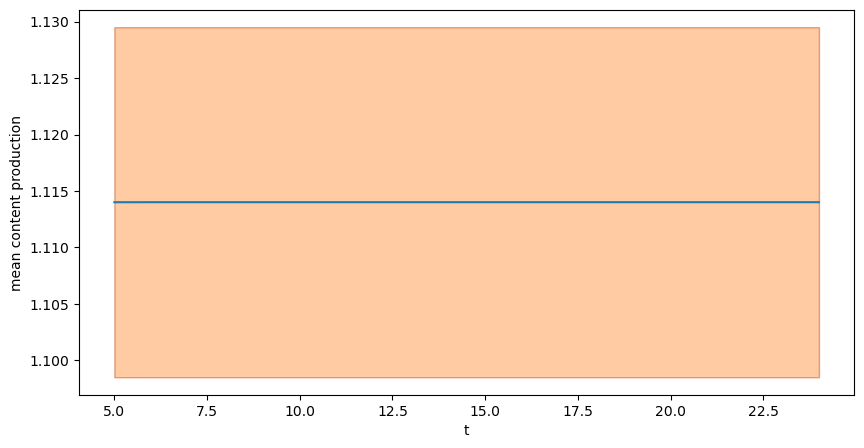

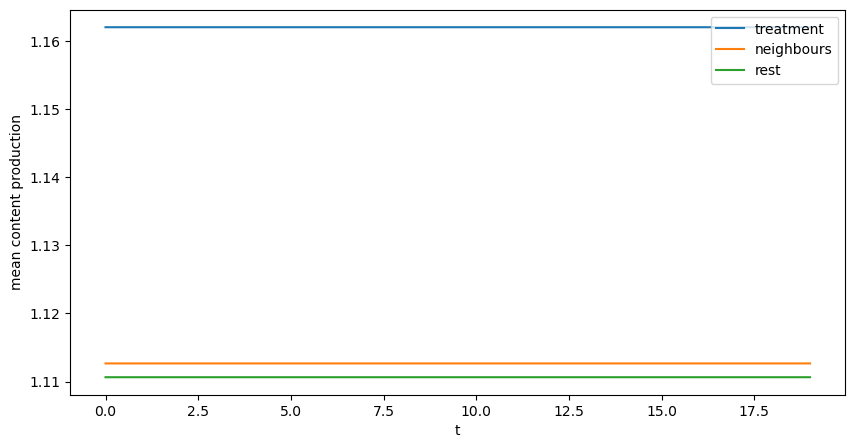

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  3916
Rest:        5584
---------------------------------
c_base:       1.1111111111111112
c_base_prime: 1.1112259188416231
c_graph:      1.1140081180227484
c_treatment:  1.1619903361270794
c_control:    1.1114827381225205
c_neighbours: 1.1126716371367462
c_rest:       1.1106489758482176
---------------------------------
c_graph_prime:      1.0025037205611849
c_treatment_prime:  1.0456832552451392
c_control_prime:    1.0002311134725557
c_neighbours_prime: 1.0013010120359955
c_rest_prime:       0.9994808049527796
---------------------------------
e_spillover = 0.00023111347255566628
e_treatment = 0.045441639597457506
e_dampening = 0.9088327919491501
e_intrinsic = 0.045683255245139165
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


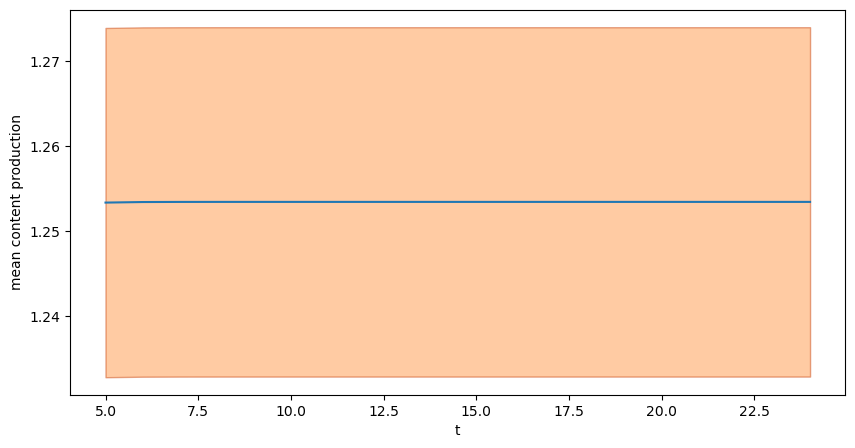

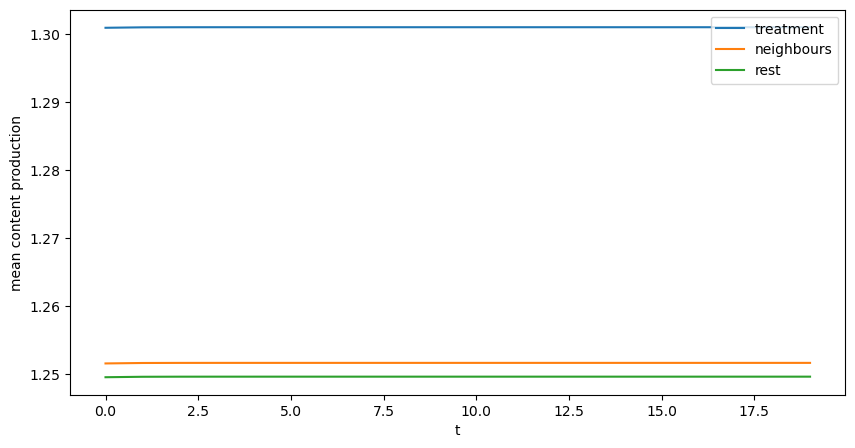

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  6155
Rest:        3345
---------------------------------
c_base:       1.25
c_base_prime: 1.2502972644386683
c_graph:      1.2534257571270477
c_treatment:  1.301052803172793
c_control:    1.2509190704930613
c_neighbours: 1.251633734509447
c_rest:       1.2496040459726268
---------------------------------
c_graph_prime:      1.0025021990988552
c_treatment_prime:  1.0405947770804025
c_control_prime:    1.0004973265735106
c_neighbours_prime: 1.001068921854659
c_rest_prime:       0.9994455570800974
---------------------------------
e_spillover = 0.000497326573510648
e_treatment = 0.0400775188917466
e_dampening = 0.801550377834932
e_intrinsic = 0.04059477708040249
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


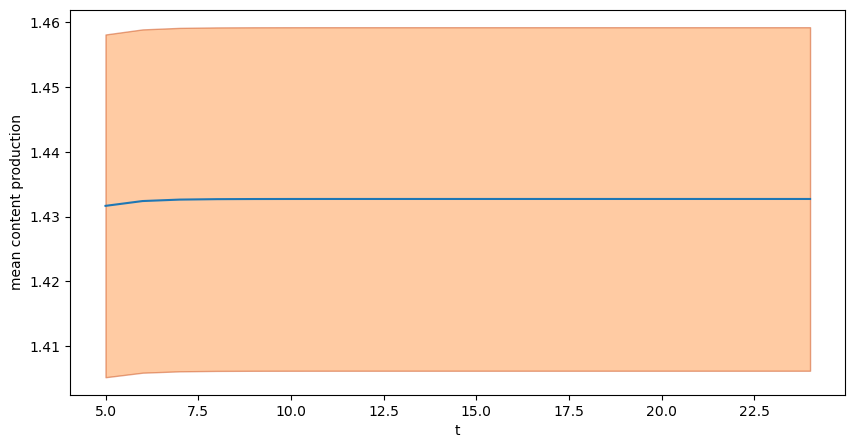

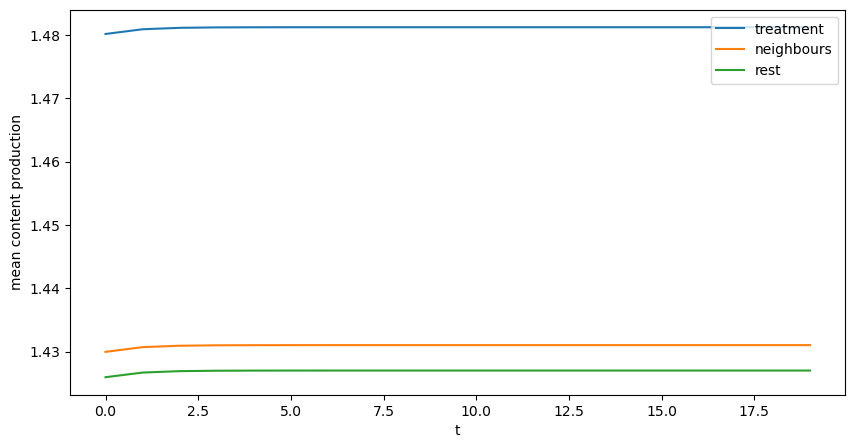

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  7471
Rest:        2029
---------------------------------
c_base:       1.4285714285714286
c_base_prime: 1.4291710498552475
c_graph:      1.4327162876555442
c_treatment:  1.4812382134024158
c_control:    1.4301625020899194
c_neighbours: 1.4310200749907633
c_rest:       1.4270048248389555
---------------------------------
c_graph_prime:      1.0024806252552176
c_treatment_prime:  1.0364317228175326
c_control_prime:    1.0006937253835169
c_neighbours_prime: 1.0012937745525303
c_rest_prime:       0.9984842786897262
---------------------------------
e_spillover = 0.0006937253835168633
e_treatment = 0.03571322226520324
e_dampening = 0.7142644453040647
e_intrinsic = 0.0364317228175326
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


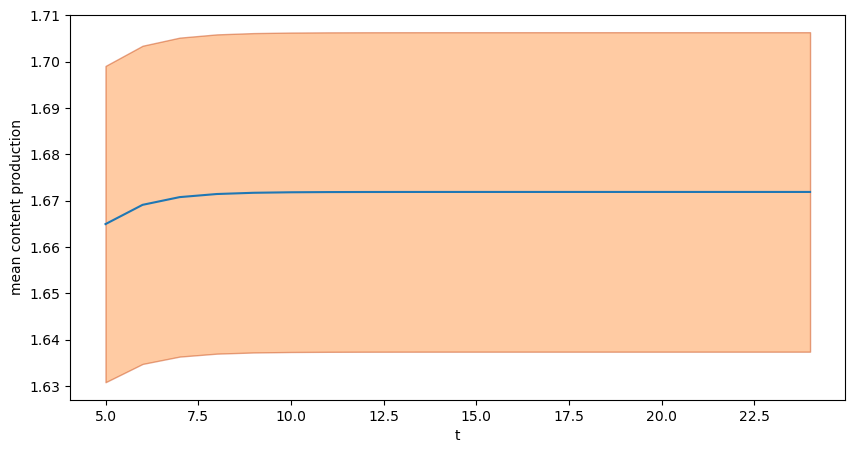

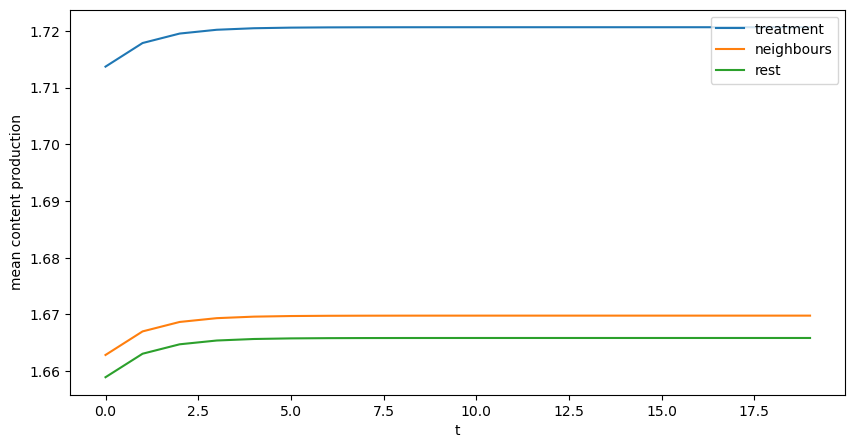

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  8334
Rest:        1166
---------------------------------
c_base:       1.6666666666666667
c_base_prime: 1.667744159742101
c_graph:      1.6718837011826109
c_treatment:  1.720659683805512
c_control:    1.6693165442024582
c_neighbours: 1.6698004463237976
c_rest:       1.665857847565029
---------------------------------
c_graph_prime:      1.0024821201839196
c_treatment_prime:  1.0317288018994435
c_control_prime:    1.0009428211462605
c_neighbours_prime: 1.0012329748359092
c_rest_prime:       0.9988689439168154
---------------------------------
e_spillover = 0.0009428211462605418
e_treatment = 0.030756982419762435
e_dampening = 0.6151396483952487
e_intrinsic = 0.03172880189944349
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


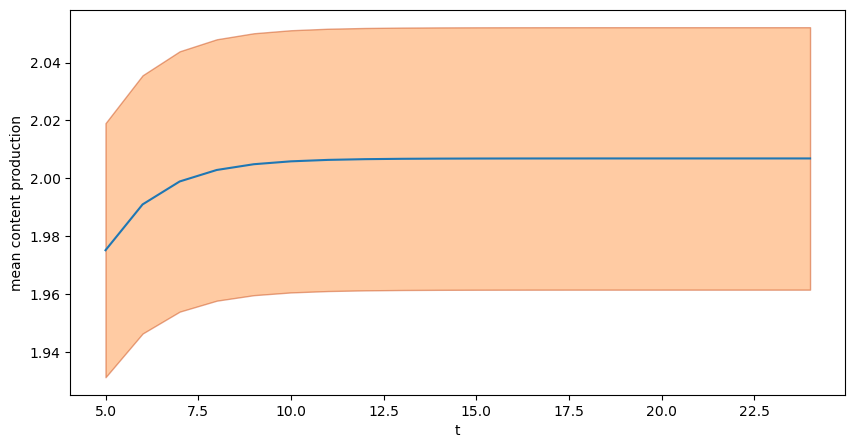

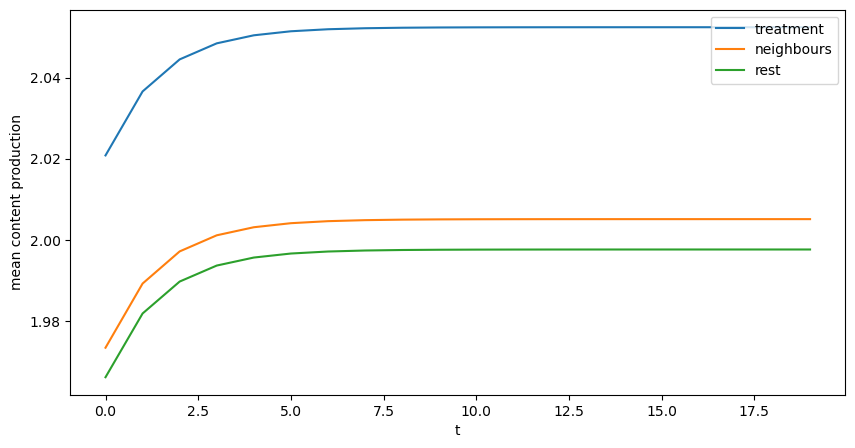

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  8764
Rest:        736
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      2.00689395612874
c_treatment:  2.0524101534840082
c_control:    2.004498366794252
c_neighbours: 2.0050784464846596
c_rest:       1.9975910048285832
---------------------------------
c_graph_prime:      1.0024994961364404
c_treatment_prime:  1.02523610599834
c_control_prime:    1.0013028324594984
c_neighbours_prime: 1.001592598441192
c_rest_prime:       0.9978524125361794
---------------------------------
e_spillover = 0.0013028324594983598
e_treatment = 0.023902133064034548
e_dampening = 0.47804266128069095
e_intrinsic = 0.02523610599833992
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


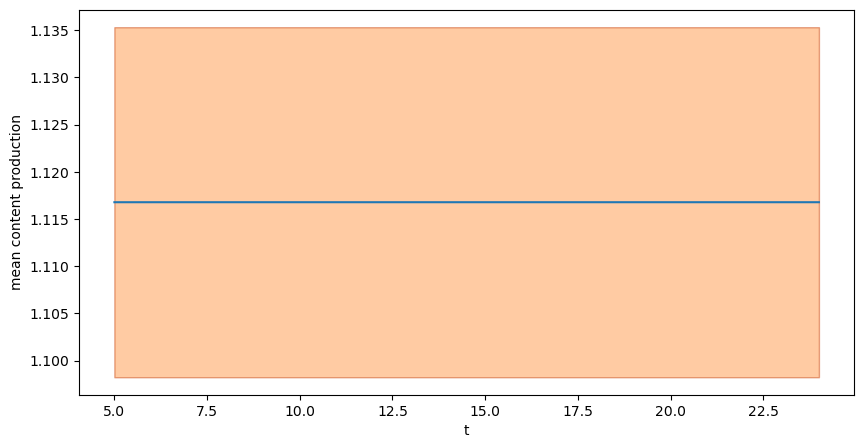

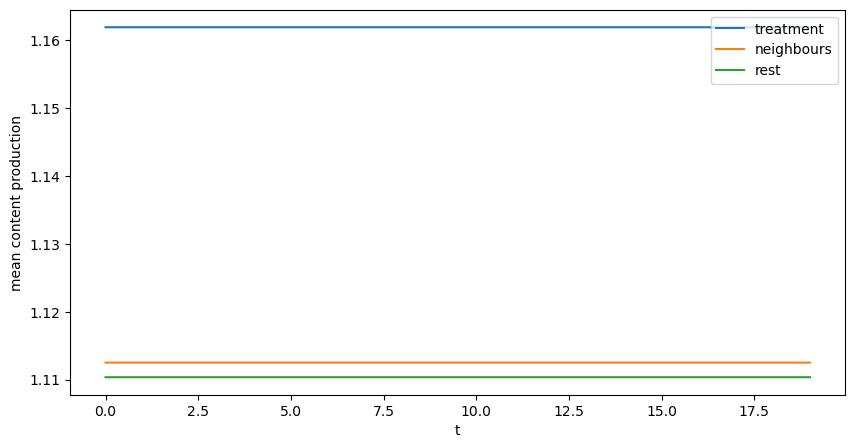

Total nodes: 10000
Treatment:   1000
Control:     9000
Neighbours:  5883
Rest:        3117
---------------------------------
c_base:       1.1111111111111112
c_base_prime: 1.1112259188416231
c_graph:      1.1167835059225684
c_treatment:  1.1618959590623912
c_control:    1.111771011129255
c_neighbours: 1.1125157893557875
c_rest:       1.1103653228691674
---------------------------------
c_graph_prime:      1.0050013116025396
c_treatment_prime:  1.0455983246625384
c_control_prime:    1.0004905323736508
c_neighbours_prime: 1.0011607635245847
c_rest_prime:       0.9992255436470086
---------------------------------
e_spillover = 0.0004905323736508205
e_treatment = 0.04508567630507199
e_dampening = 0.9017135261014397
e_intrinsic = 0.045598324662538436
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


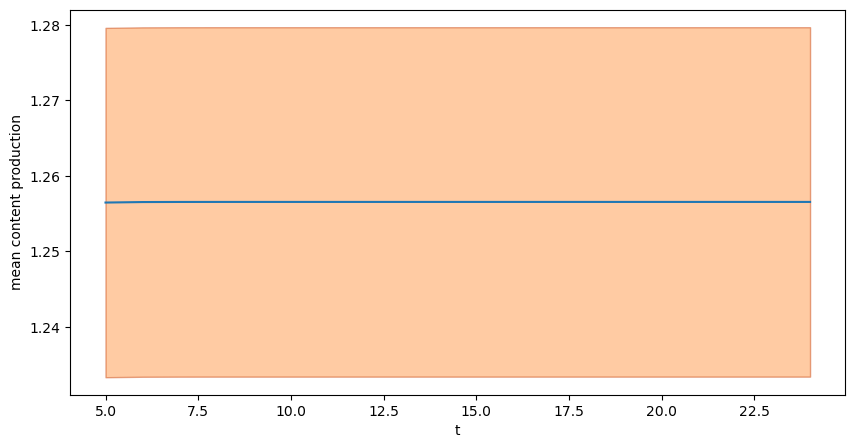

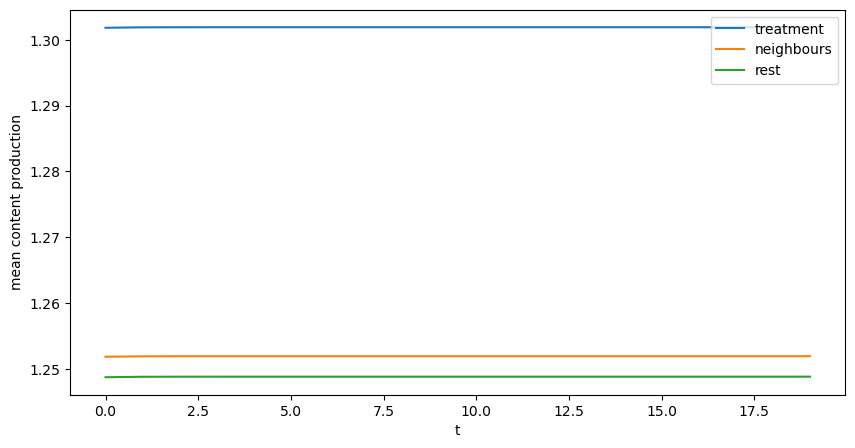

Total nodes: 10000
Treatment:   1000
Control:     9000
Neighbours:  7854
Rest:        1146
---------------------------------
c_base:       1.25
c_base_prime: 1.2502972644386683
c_graph:      1.256554569512079
c_treatment:  1.301921881479198
c_control:    1.251513757071288
c_neighbours: 1.2519101443484602
c_rest:       1.2487971552607209
---------------------------------
c_graph_prime:      1.005004653894224
c_treatment_prime:  1.0412898744233492
c_control_prime:    1.0009729627243213
c_neighbours_prime: 1.0012899971516103
c_rest_prime:       0.9988001979844202
---------------------------------
e_spillover = 0.0009729627243213468
e_treatment = 0.04027772297595189
e_dampening = 0.8055544595190378
e_intrinsic = 0.04128987442334919
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


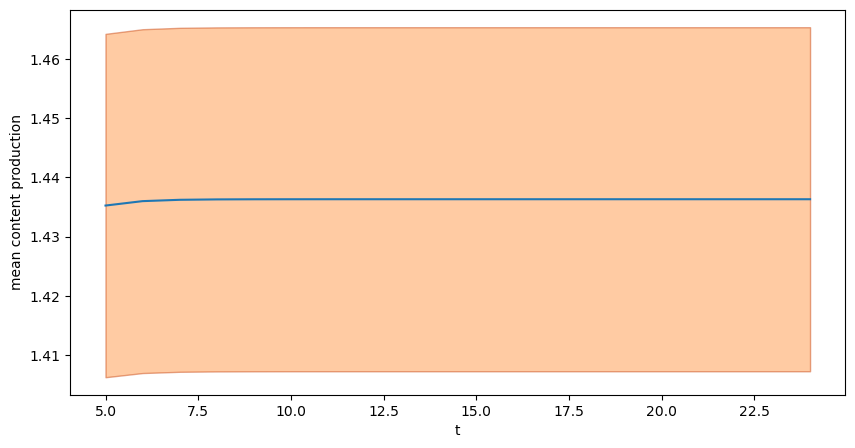

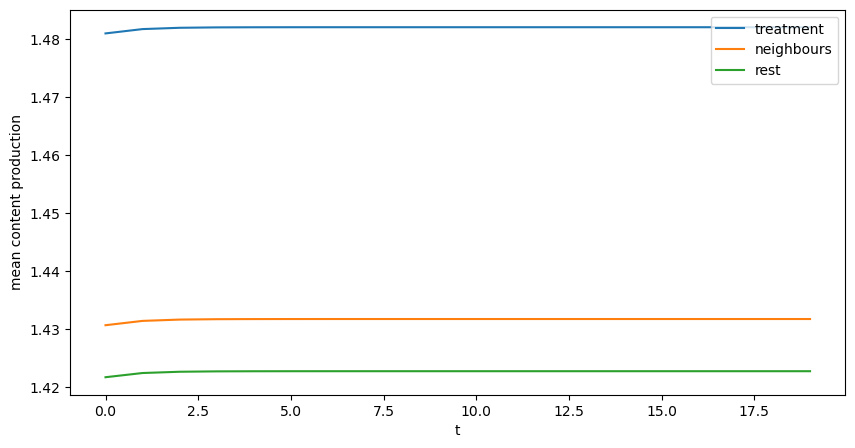

Total nodes: 10000
Treatment:   1000
Control:     9000
Neighbours:  8527
Rest:        473
---------------------------------
c_base:       1.4285714285714286
c_base_prime: 1.4291710498552475
c_graph:      1.4363166919937904
c_treatme

limit_output extension: Maximum message size of 10000 exceeded with 10518 characters

In [33]:
def calculate_model_metrics(n, k, p, N, num_simulations):
    model = DotMap()
    model.k = k
    model.p = p
    model.g = connected_watts_strogatz_graph(n, model.k, model.p).to_directed()
    model.ν_damp = 0.01
    model.ν = lambda posts: model.ν_damp * sum(posts)
    model.λ_int = lambda i: 1
    model.T = 25
    model.treatment_N = N
    model.nodes_treatment = set(random.sample(list(model.g.nodes), model.treatment_N))
    model.nodes_treatment_neighbours = set([
        v2 for (v1, v2) in model.g.edges if v1 in model.nodes_treatment and v2 not in model.nodes_treatment])
    model.nodes_rest = set(set(model.g.nodes) - (model.nodes_treatment | model.nodes_treatment_neighbours))
    model.Δλ = 0.05
    model.post_production = lambda i, λ: λ + model.Δλ * (1 if i in model.nodes_treatment else 0)
    _, posts_series = simulate_network(model, steady_state_cut=5)
    _, norand_treatment, _, norand_neighbours, norand_rest = group_post_productions(model, posts_series)
    return model_stats(model, norand_treatment, norand_neighbours, norand_rest)

n = 10_000
ks = [10, 20, 30, 40, 50]
p = 0.1
Ns = [100, 500, 1000, 5000, 9000]
results = [(N, k, calculate_model_metrics(n, k, p, N, num_simulations=1)) for N, k in product(Ns, ks)]

In [34]:
results

[(100,
  10,
  (1.1112259188416231,
   1.1117850279386319,
   1.1616687643489312,
   1.1112811518132752,
   1.112758335840128,
   1.111125814979909,
   4.970453866803837e-05,
   0.04534191230854456,
   0.9068382461708913,
   0.04539387054604638)),
 (100,
  20,
  (1.2502972644386683,
   1.250916382659561,
   1.3019736652174208,
   1.2504006525327138,
   1.252218376131045,
   1.2499931425928381,
   8.269081040657156e-05,
   0.041245190155847045,
   0.8249038031169409,
   0.04133129156445281)),
 (100,
  30,
  (1.4291710498552475,
   1.4298635523559329,
   1.4791974743800653,
   1.429365229911245,
   1.430776986110435,
   1.428869728144826,
   0.00013586901023288078,
   0.03486319901031498,
   0.6972639802062996,
   0.035003804848890985)),
 (100,
  40,
  (1.667744159742101,
   1.6685661213206906,
   1.7178443344540275,
   1.668068361592071,
   1.6699876154901914,
   1.6670898552962932,
   0.00019439543414145888,
   0.029840487361350254,
   0.5968097472270051,
   0.030040683649987354)),
 (1

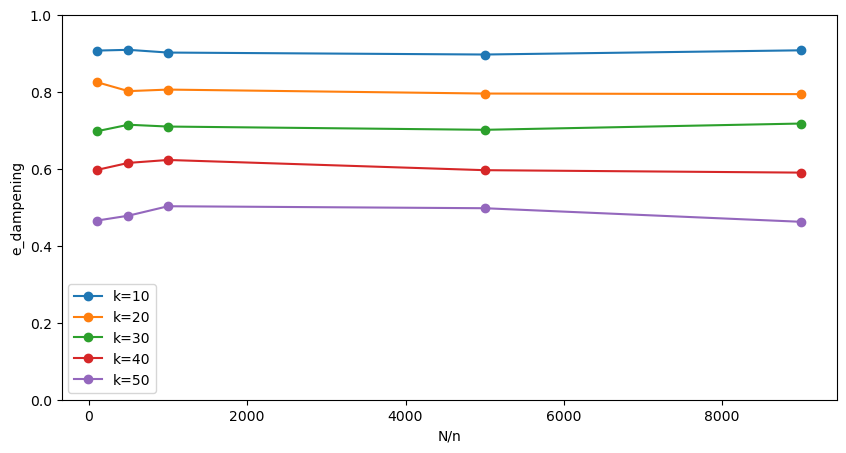

In [35]:
plt.figure(figsize=(10, 5))
plt.xlabel('N/n')
plt.ylabel('e_dampening')
for k in ks:
    plt.plot(Ns, [r[2][8] for r in results if r[1] == k], marker='o')
plt.legend([f'k={k}' for k in ks])
plt.ylim((0.0, 1.0))
plt.show() 

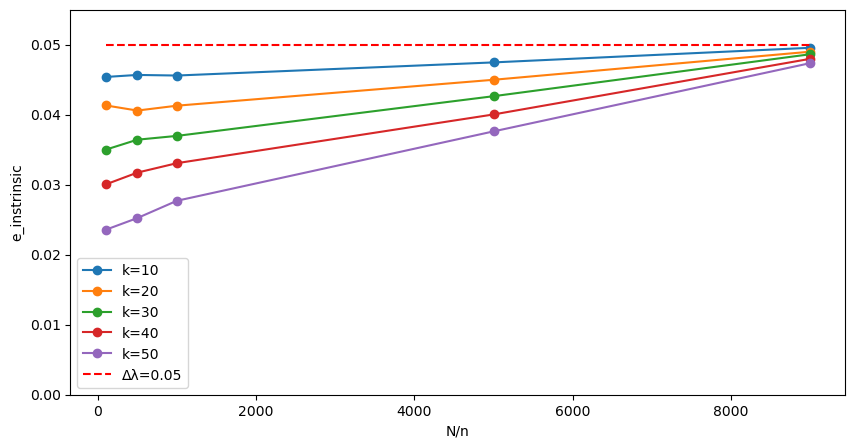

In [36]:
plt.figure(figsize=(10, 5))
plt.xlabel('N/n')
plt.ylabel('e_instrinsic')
for k in ks:
    plt.plot(Ns, [r[2][9] for r in results if r[1] == k], marker='o')
plt.plot(Ns, [0.05 for _ in Ns], 'r--')
plt.legend([f'k={k}' for k in ks] + ['Δλ=0.05'])
plt.ylim((0.0, 0.055))
plt.show() 

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


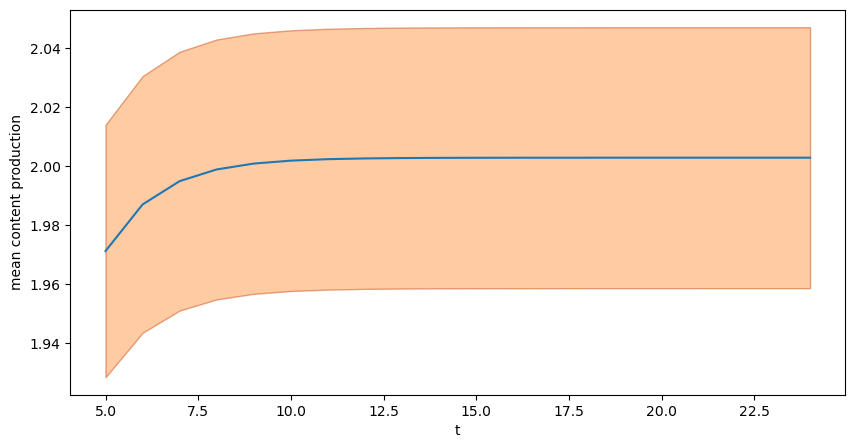

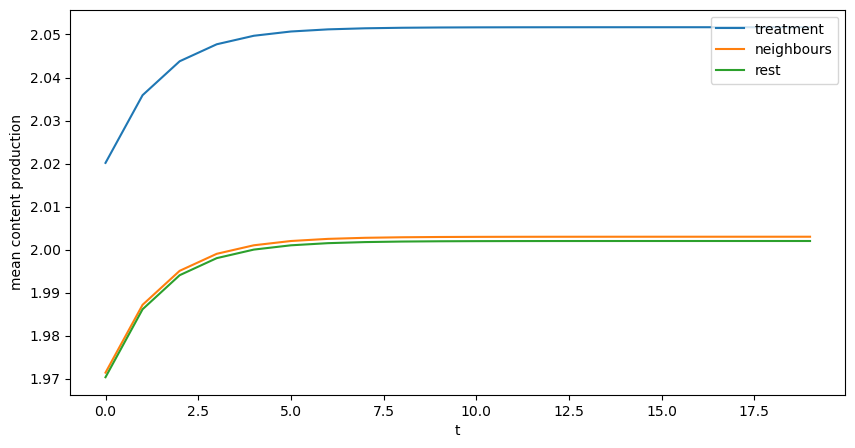

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  4019
Rest:        5881
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      2.002898868504846
c_treatment:  2.0516861215127546
c_control:    2.0024060679694125
c_neighbours: 2.002996841275242
c_rest:       2.0020023410664827
---------------------------------
c_graph_prime:      1.000503838459689
c_treatment_prime:  1.0248744318380527
c_control_prime:    1.0002576708498063
c_neighbours_prime: 1.0005527785906096
c_rest_prime:       1.0000559980033026
---------------------------------
e_spillover = 0.00025767084980632404
e_treatment = 0.02461041960051369
e_dampening = 0.4922083920102738
e_intrinsic = 0.024874431838052713
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


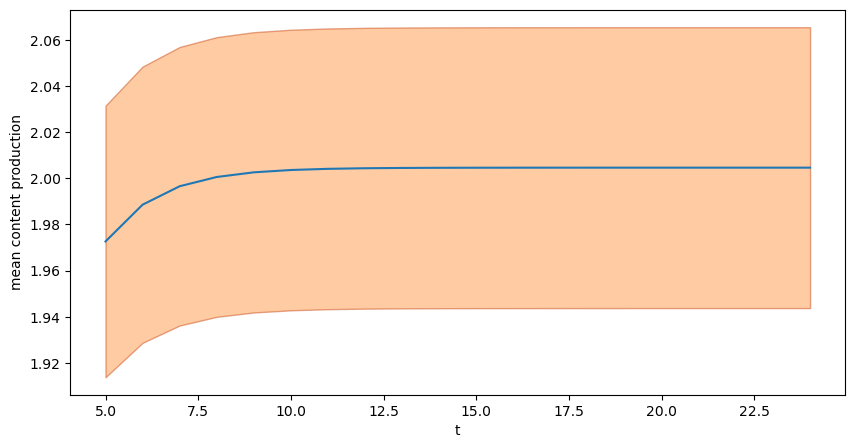

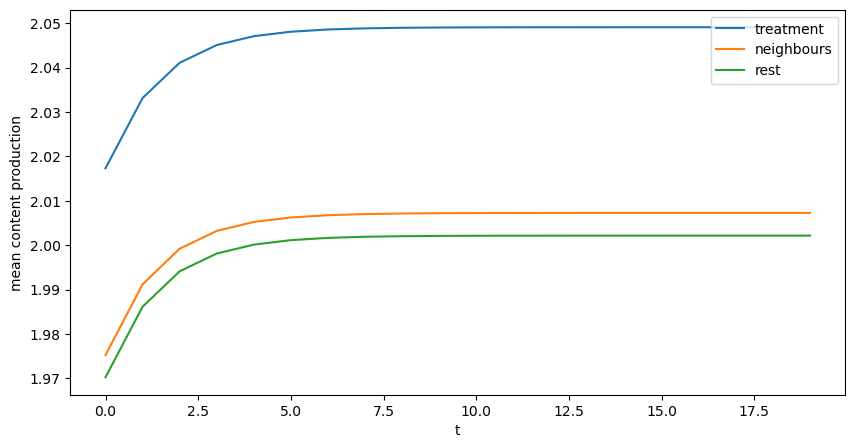

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  3906
Rest:        5994
---------------------------------
c_base:       2.0
c_base_prime: 2.003543894433098
c_graph:      2.0046117568012987
c_treatment:  2.0491015150724112
c_control:    2.0041623653036105
c_neighbours: 2.007258417008952
c_rest:       2.002144818096226
---------------------------------
c_graph_prime:      1.000532986759695
c_treatment_prime:  1.0227385188644464
c_control_prime:    1.0003086884556065
c_neighbours_prime: 1.0018539761400662
c_rest_prime:       0.9993016991837517
---------------------------------
e_spillover = 0.0003086884556064984
e_treatment = 0.022422908715778123
e_dampening = 0.44845817431556245
e_intrinsic = 0.022738518864446444
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


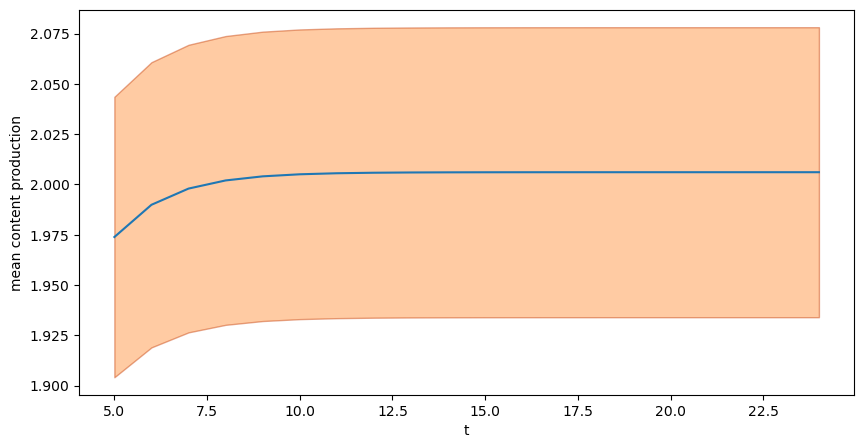

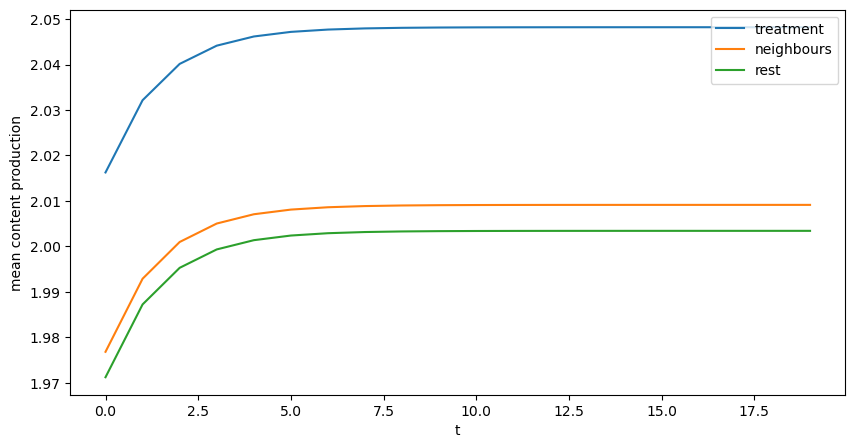

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  3890
Rest:        6010
---------------------------------
c_base:       2.0
c_base_prime: 2.0050963467954226
c_graph:      2.006095529230466
c_treatment:  2.0482104832433694
c_control:    2.0056701256545777
c_neighbours: 2.0091369822587803
c_rest:       2.0034261868541874
---------------------------------
c_graph_prime:      1.0004983214081657
c_treatment_prime:  1.0215022766945103
c_control_prime:    1.0002861602436572
c_neighbours_prime: 1.0020151826967396
c_rest_prime:       0.9991670425493995
---------------------------------
e_spillover = 0.0002861602436572408
e_treatment = 0.021210046978641595
e_dampening = 0.4242009395728319
e_intrinsic = 0.021502276694510325
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


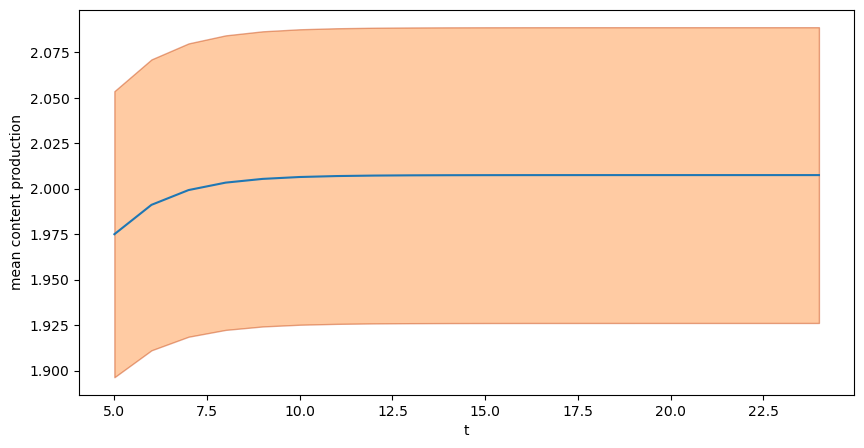

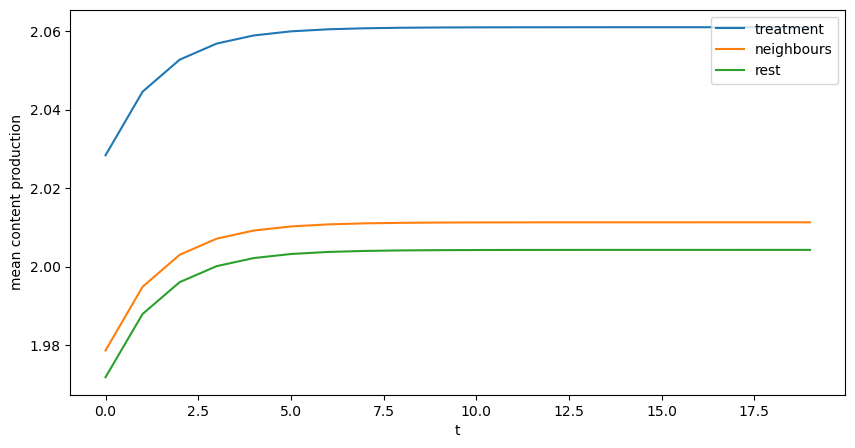

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  3750
Rest:        6150
---------------------------------
c_base:       2.0
c_base_prime: 2.006508606637987
c_graph:      2.007482612633136
c_treatment:  2.0609737871748113
c_control:    2.006942297738776
c_neighbours: 2.0113058565491673
c_rest:       2.0042815911470737
---------------------------------
c_graph_prime:      1.0004854232829736
c_treatment_prime:  1.0271442546304765
c_control_prime:    1.0002161421582514
c_neighbours_prime: 1.0023908444226501
c_rest_prime:       0.9988901041921545
---------------------------------
e_spillover = 0.00021614215825138672
e_treatment = 0.02692229342961805
e_dampening = 0.538445868592361
e_intrinsic = 0.02714425463047654
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


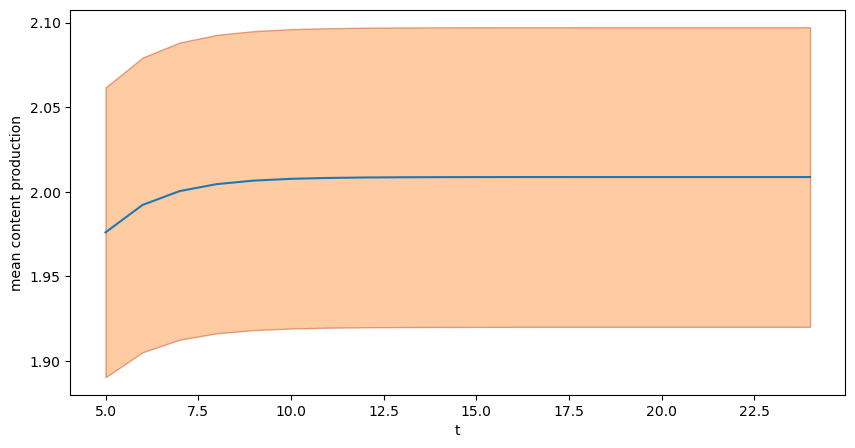

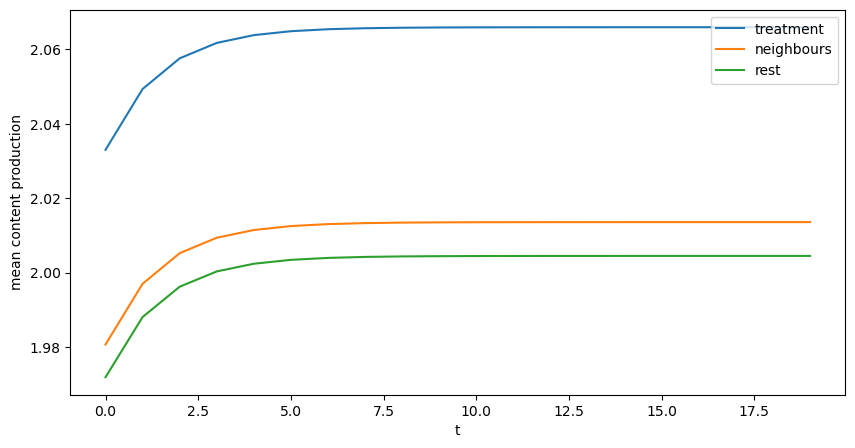

Total nodes: 10000
Treatment:   100
Control:     9900
Neighbours:  3952
Rest:        5948
---------------------------------
c_base:       2.0
c_base_prime: 2.007454108030194
c_graph:      2.008700009830176
c_treatment:  2.065987427376764
c_control:    2.0081213490468772
c_neighbours: 2.0135835513577787
c_rest:       2.004492125184624
---------------------------------
c_graph_prime:      1.0006206377495743
c_treatment_prime:  1.029157986283435
c_control_prime:    1.000332381703778
c_neighbours_prime: 1.0030533416943708
c_rest_prime:       0.9985245078162824
---------------------------------
e_spillover = 0.00033238170377791754
e_treatment = 0.02881602665962002
e_dampening = 0.5763205331924004
e_intrinsic = 0.029157986283435022
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


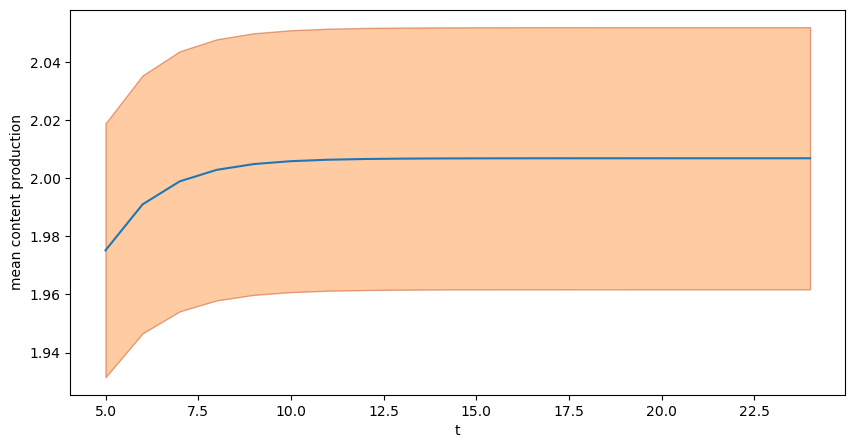

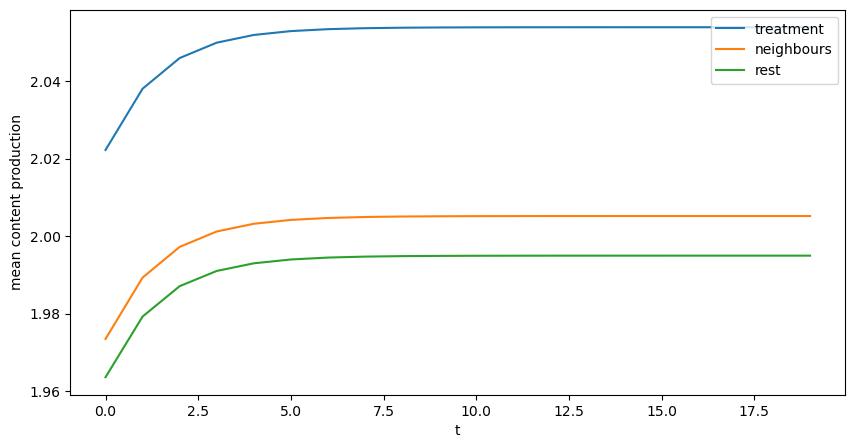

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  8784
Rest:        716
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      2.0068755452991667
c_treatment:  2.0538847041300423
c_control:    2.0044013790449102
c_neighbours: 2.0051718600975588
c_rest:       1.9949489969688452
---------------------------------
c_graph_prime:      1.0024902994136569
c_treatment_prime:  1.025972685165945
c_control_prime:    1.001254384374063
c_neighbours_prime: 1.0016392611458045
c_rest_prime:       0.996532655934149
---------------------------------
e_spillover = 0.001254384374062889
e_treatment = 0.02468733338664464
e_dampening = 0.4937466677328928
e_intrinsic = 0.025972685165944975
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


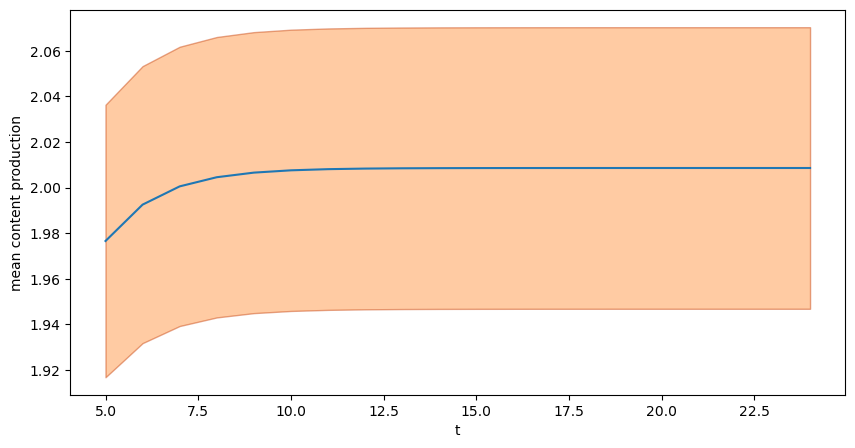

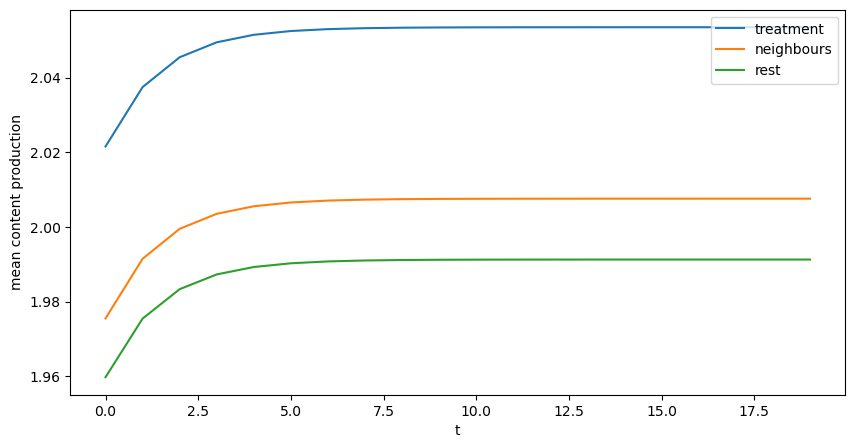

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  8735
Rest:        765
---------------------------------
c_base:       2.0
c_base_prime: 2.003543894433098
c_graph:      2.008630563794064
c_treatment:  2.0534928489735784
c_control:    2.006269390889879
c_neighbours: 2.0075821023224036
c_rest:       1.9912804570819063
---------------------------------
c_graph_prime:      1.0025388359971048
c_treatment_prime:  1.0249303020908427
c_control_prime:    1.001360337781645
c_neighbours_prime: 1.0020155325274012
c_rest_prime:       0.9938791271879464
---------------------------------
e_spillover = 0.0013603377816449047
e_treatment = 0.02353794475364701
e_dampening = 0.4707588950729402
e_intrinsic = 0.024930302090842682
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


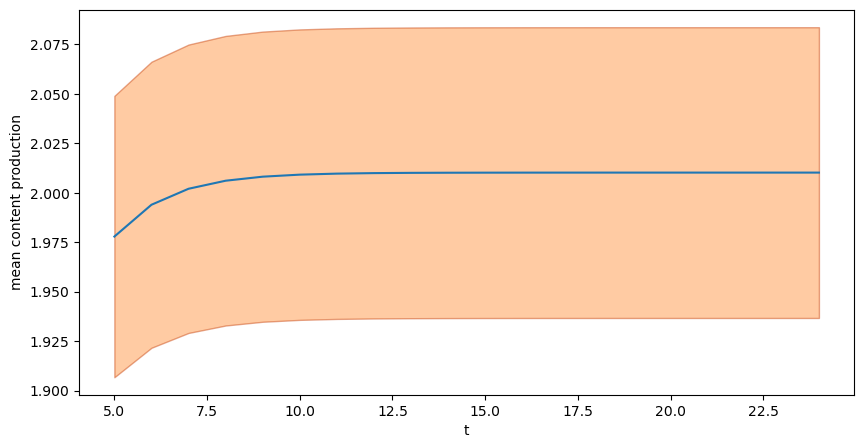

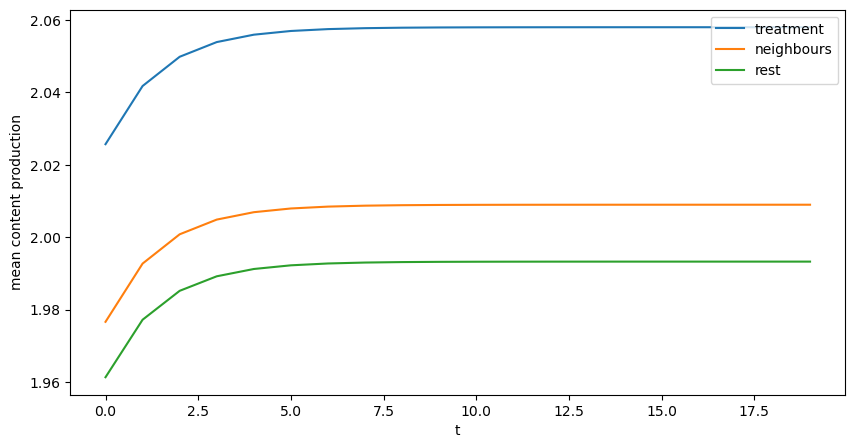

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  8691
Rest:        809
---------------------------------
c_base:       2.0
c_base_prime: 2.0050963467954226
c_graph:      2.0101779013505867
c_treatment:  2.0580333186681523
c_control:    2.007659195175978
c_neighbours: 2.008997597427802
c_rest:       1.9932808837166458
---------------------------------
c_graph_prime:      1.0025343193923253
c_treatment_prime:  1.0264012110726422
c_control_prime:    1.0012781671986244
c_neighbours_prime: 1.0019456674182337
c_rest_prime:       0.9941072841224511
---------------------------------
e_spillover = 0.0012781671986243914
e_treatment = 0.025090973414817475
e_dampening = 0.5018194682963495
e_intrinsic = 0.02640121107264215
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


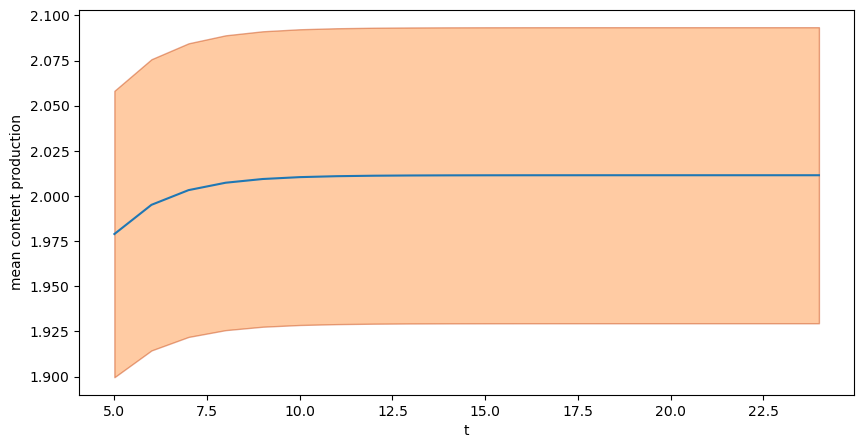

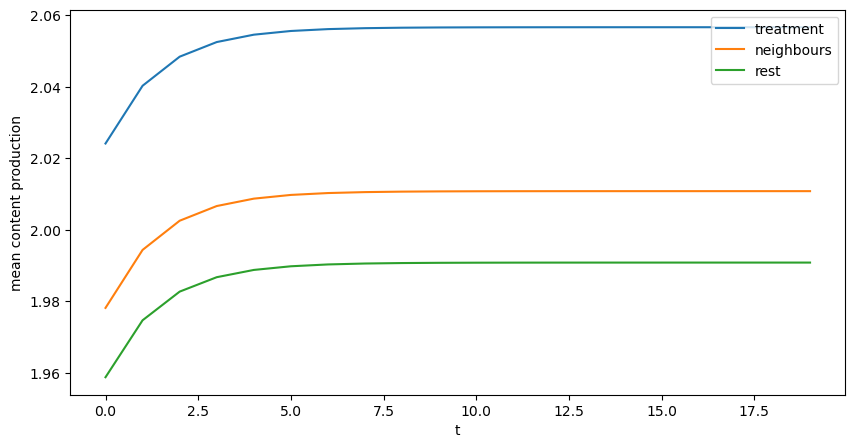

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  8700
Rest:        800
---------------------------------
c_base:       2.0
c_base_prime: 2.006508606637987
c_graph:      2.011493061825971
c_treatment:  2.0566038099405692
c_control:    2.0091188119252026
c_neighbours: 2.010799426917015
c_rest:       1.9908421238892415
---------------------------------
c_graph_prime:      1.0024841434377576
c_treatment_prime:  1.0249663535640245
c_control_prime:    1.0013008692205856
c_neighbours_prime: 1.0021384509714202
c_rest_prime:       0.9921921676802595
---------------------------------
e_spillover = 0.0013008692205855876
e_treatment = 0.02363473863940624
e_dampening = 0.4726947727881248
e_intrinsic = 0.024966353564024546
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


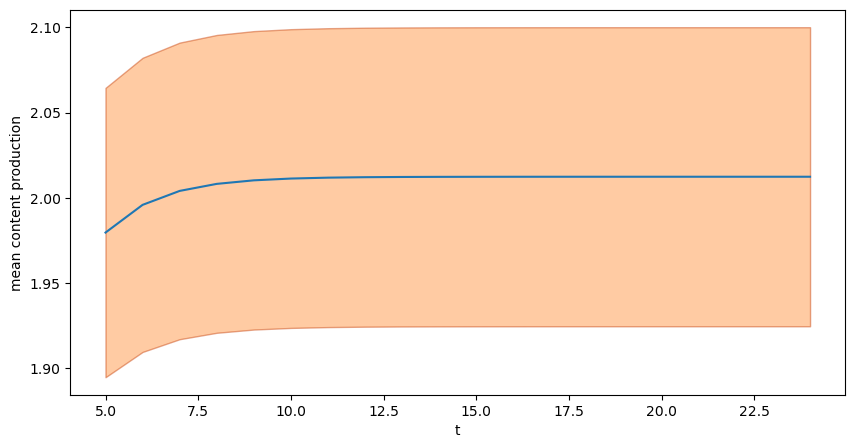

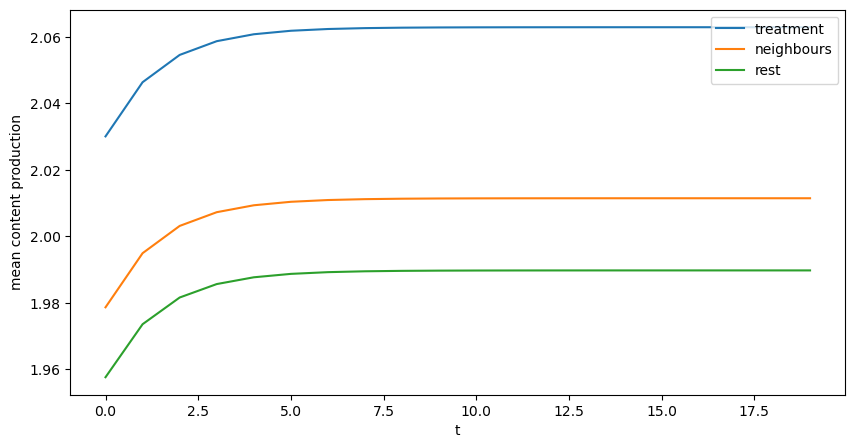

Total nodes: 10000
Treatment:   500
Control:     9500
Neighbours:  8751
Rest:        749
---------------------------------
c_base:       2.0
c_base_prime: 2.007454108030194
c_graph:      2.0124371502315435
c_treatment:  2.062925479329984
c_control:    2.0097798697526783
c_neighbours: 2.01149077589511
c_rest:       1.9897903642087242
---------------------------------
c_graph_prime:      1.0024822695479891
c_treatment_prime:  1.027632697095238
c_control_prime:    1.0011585628349762
c_neighbours_prime: 1.0020108394253042
c_rest_prime:       0.9912009227255499
---------------------------------
e_spillover = 0.0011585628349761734
e_treatment = 0.02644349780647648
e_dampening = 0.5288699561295296
e_intrinsic = 0.02763269709523808
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


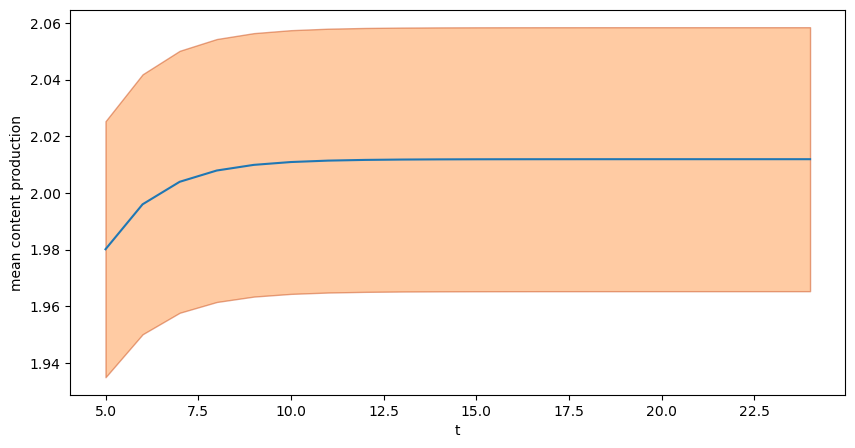

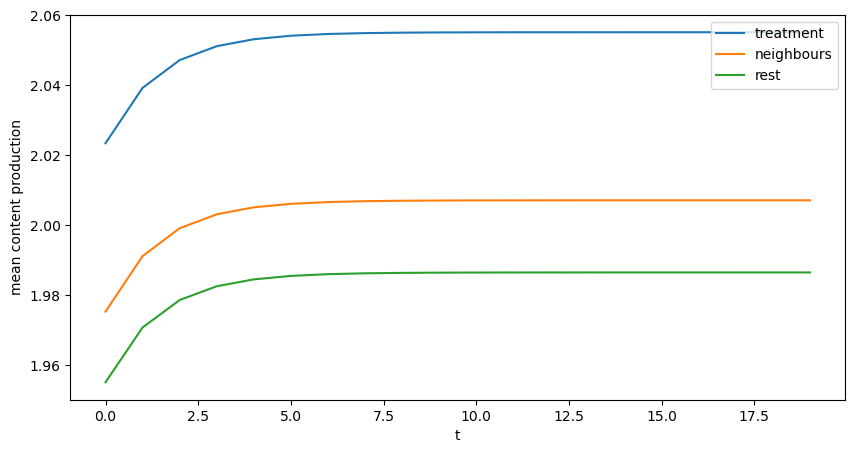

Total nodes: 10000
Treatment:   1000
Control:     9000
Neighbours:  8974
Rest:        26
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      2.011904350619308
c_treatment:  2.0551505190708257
c_control:    2.007099220791362
c_neighbours: 2.0071587109937084
c_rest:       1.986565948643024
---------------------------------
c_graph_prime:      1.0050023279063505
c_treatment_prime:  1.0266049950278897
c_control_prime:    1.0026020315595128
c_neighbours_prime: 1.0026317485745526
c_rest_prime:       0.9923450895223519
---------------------------------
e_spillover = 0.002602031559512774
e_treatment = 0.023940669091844002
e_dampening = 0.47881338183688005
e_intrinsic = 0.02660499502788971
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


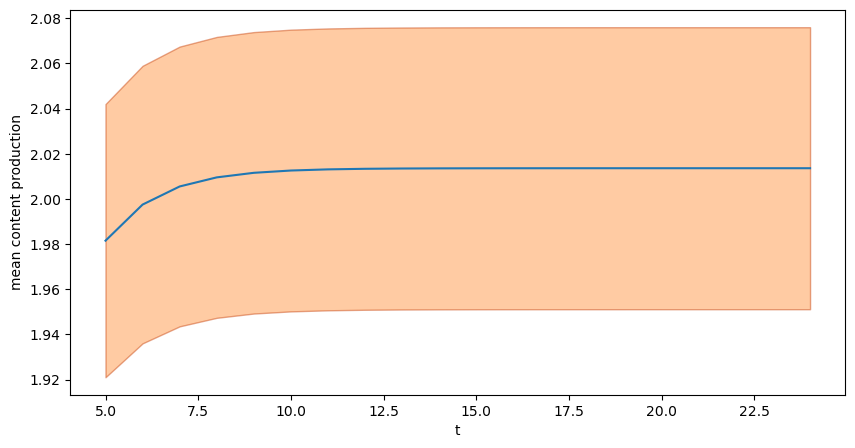

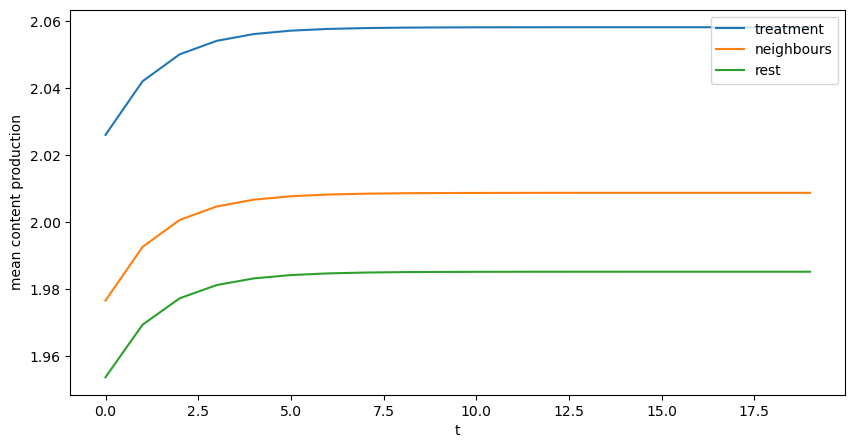

Total nodes: 10000
Treatment:   1000
Control:     9000
Neighbours:  8975
Rest:        25
---------------------------------
c_base:       2.0
c_base_prime: 2.003543894433098
c_graph:      2.0135900604213175
c_treatment:  2.058064937330563
c_control:    2.008648407431401
c_neighbours: 2.0087137038702485
c_rest:       1.9852069858852162
---------------------------------
c_graph_prime:      1.0050141980997438
c_treatment_prime:  1.0272123026847344
c_control_prime:    1.0025477420347446
c_neighbours_prime: 1.0025803325055742
c_rest_prime:       0.9908477630069242
---------------------------------
e_spillover = 0.0025477420347446156
e_treatment = 0.02460188140260655
e_dampening = 0.492037628052131
e_intrinsic = 0.027212302684734402
Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


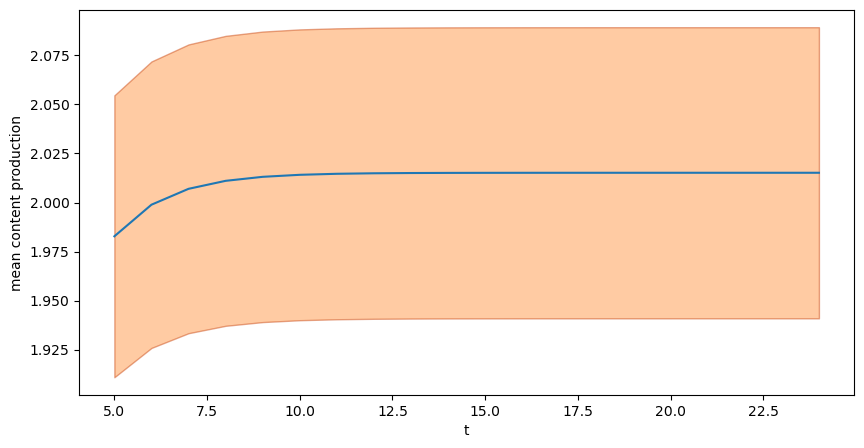

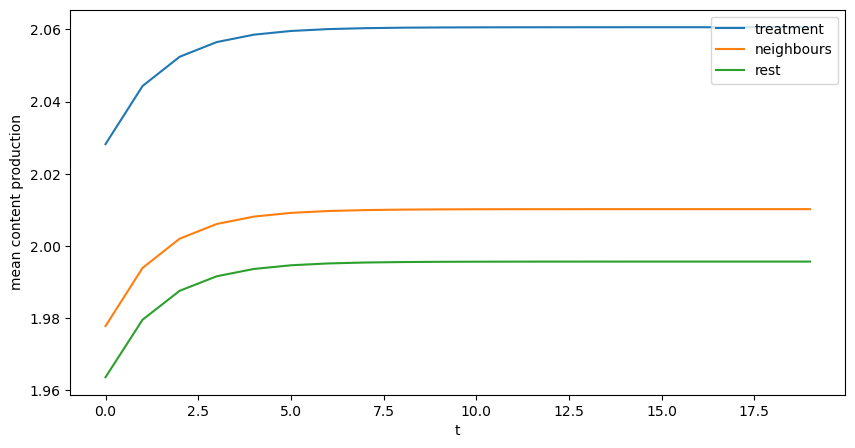

Total nodes: 10000
Treatment:   1000
Control:     9000
Neighbours:  8940
Rest:        60
---------------------------------
c_base:       2.0
c_base_prime: 2.0050963467954226
c_graph:      2.0151710339137408
c_treatment:  2.0606191899975315
c_control:    2.0101212387933196
c_neighbours: 2.010218092785029
c_rest:       1.9956899940286117
-------------

limit_output extension: Maximum message size of 10000 exceeded with 10387 characters

In [37]:
n = 10_000
k = 50
ps = [0.1, 0.2, 0.3, 0.4, 0.5]
Ns = [100, 500, 1000, 5000, 9000]
results = [(N, p, calculate_model_metrics(n, k, p, N, num_simulations=1)) for N, p in product(Ns, ps)]

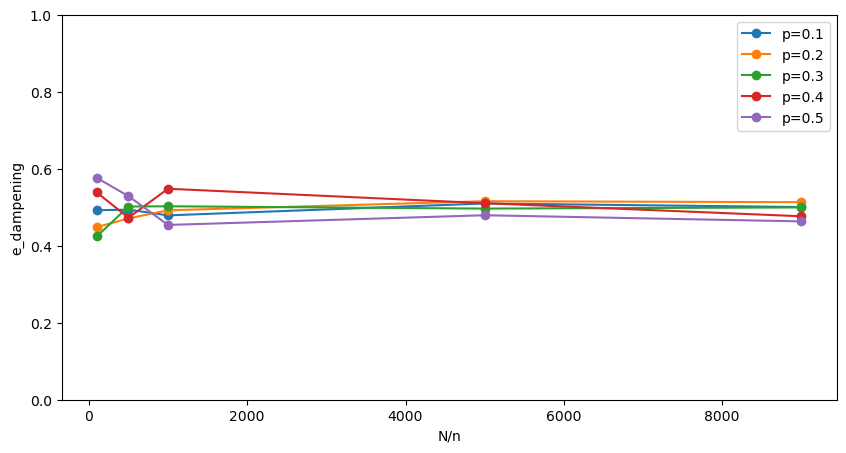

In [38]:
plt.figure(figsize=(10, 5))
plt.xlabel('N/n')
plt.ylabel('e_dampening')
for p in ps:
    plt.plot(Ns, [r[2][8] for r in results if r[1] == p], marker='o')
plt.legend([f'p={p}' for p in ps])
plt.ylim((0.0, 1.0))
plt.show() 

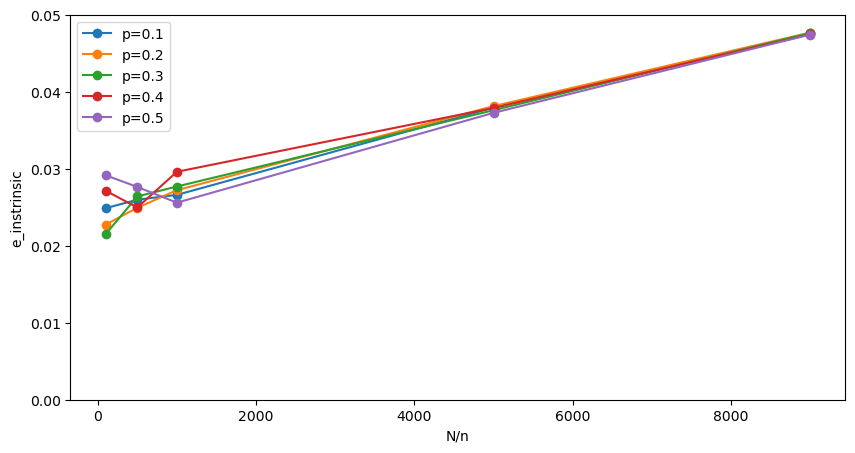

In [39]:
plt.figure(figsize=(10, 5))
plt.xlabel('N/n')
plt.ylabel('e_instrinsic')
for p in ps:
    plt.plot(Ns, [r[2][9] for r in results if r[1] == p], marker='o')
plt.legend([f'p={p}' for p in ps])
plt.ylim((0.0, 0.05))
plt.show() 

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


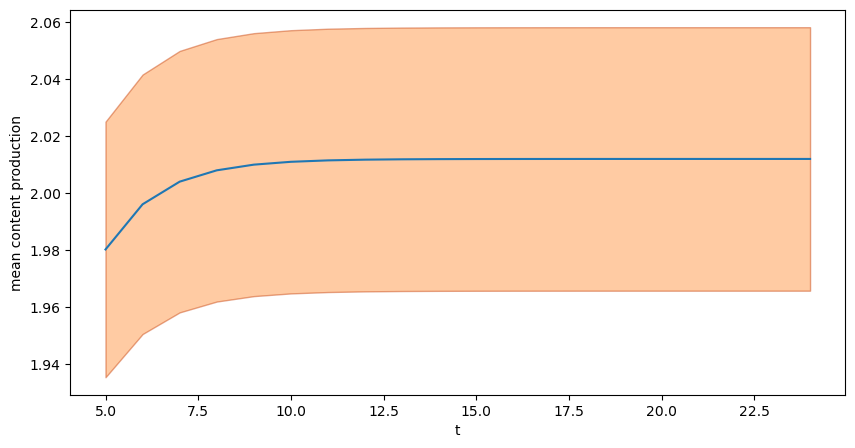

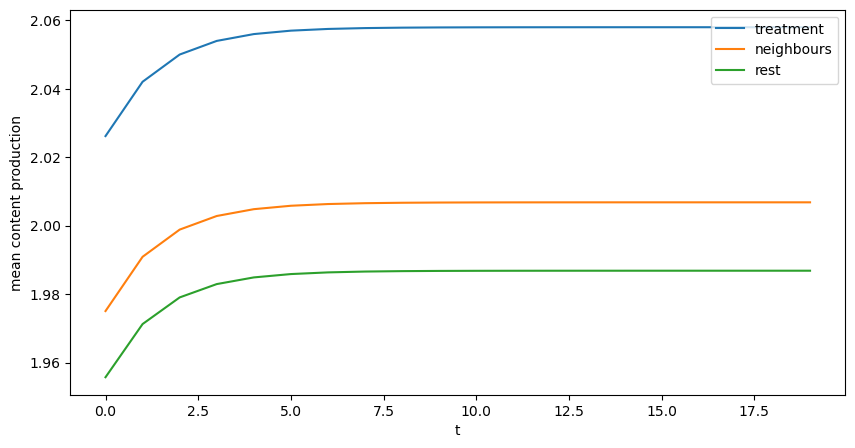

Total nodes: 10000
Treatment:   1000
Control:     9000
Neighbours:  8959
Rest:        41
---------------------------------
c_base:       2.0
c_base_prime: 2.001890239210256
c_graph:      2.011859075087425
c_treatment:  2.0579703526788498
c_control:    2.0067355997994887
c_neighbours: 2.006826592950051
c_rest:       1.9868524867290682
---------------------------------
c_graph_prime:      1.0049797115156032
c_treatment_prime:  1.0280135805501092
c_control_prime:    1.0024203927339914
c_neighbours_prime: 1.0024658463501688
c_rest_prime:       0.992488223286847
---------------------------------
e_spillover = 0.0024203927339914166
e_treatment = 0.025531391820865945
e_dampening = 0.5106278364173189
e_intrinsic = 0.028013580550109163


In [40]:
model = DotMap()
model.k = 50
model.p = 0.1
model.g = connected_watts_strogatz_graph(n=10_000, k=model.k, p=model.p).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.treatment_N = 1000
model.nodes_treatment = set(random.sample(list(model.g.nodes), model.treatment_N))
model.nodes_treatment_neighbours = set([
    v2 for (v1, v2) in model.g.edges if v1 in model.nodes_treatment and v2 not in model.nodes_treatment])
model.nodes_rest = set(set(model.g.nodes) - (model.nodes_treatment | model.nodes_treatment_neighbours))
model.Δλ = 0.05
model.post_production = lambda i, λ: λ + model.Δλ * (1 if i in model.nodes_treatment else 0)
_, posts_series = simulate_network(model, steady_state_cut=5)
_, norand_treatment, _, norand_neighbours, norand_rest = group_post_productions(model, posts_series)
_ = model_stats(model, norand_treatment, norand_neighbours, norand_rest)

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


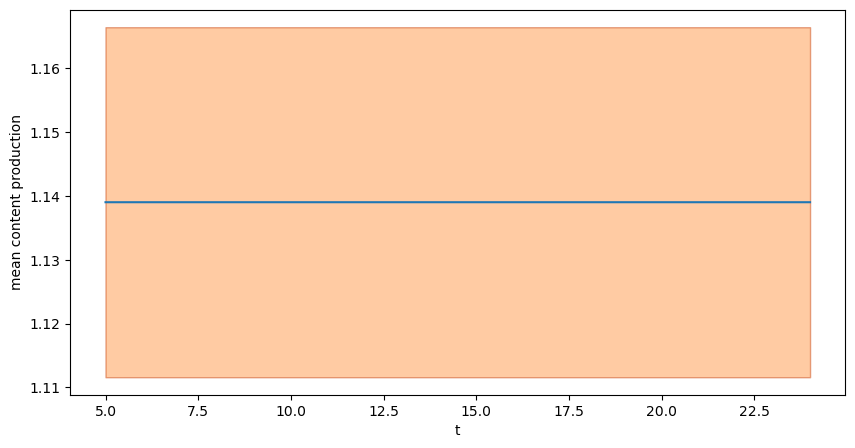

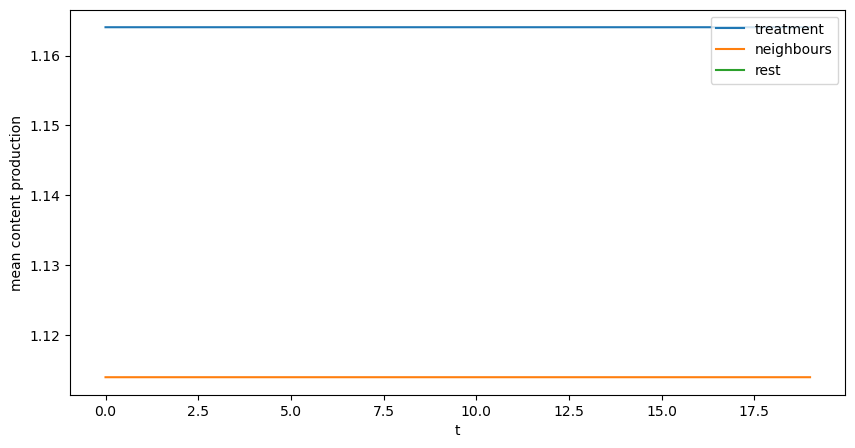

Total nodes: 10000
Treatment:   5000
Control:     5000
Neighbours:  5000
Rest:        0
---------------------------------
c_base:       1.1111111111111112
c_base_prime: 1.1112259188416231
c_graph:      1.1390097324886446
c_treatment:  1.1640567336540226
c_control:    1.1139627313232665
c_neighbours: 1.1139627313232665
c_rest:       0
---------------------------------
c_graph_prime:      1.0250028488140235
c_treatment_prime:  1.0475428208761293
c_control_prime:    1.0024628767519177
c_neighbours_prime: 1.0024628767519177
c_rest_prime:       0.0
---------------------------------
e_spillover = 0.0024628767519176975
e_treatment = 0.04496919055025295
e_dampening = 0.8993838110050589
e_intrinsic = 0.047542820876129266


(1.1112259188416231,
 1.1390097324886446,
 1.1640567336540226,
 1.1139627313232665,
 1.1139627313232665,
 0,
 0.0024628767519176975,
 0.04496919055025295,
 0.8993838110050589,
 0.047542820876129266)

In [41]:
model = DotMap()
model.k = 10
model.p = 0.1
model.g = connected_watts_strogatz_graph(n=10_000, k=model.k, p=model.p).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.treatment_N = 5_000
model.nodes_treatment = set(random.sample(list(model.g.nodes), model.treatment_N))
model.nodes_treatment_neighbours = set([
    v2 for (v1, v2) in model.g.edges if v1 in model.nodes_treatment and v2 not in model.nodes_treatment])
model.nodes_rest = set(set(model.g.nodes) - (model.nodes_treatment | model.nodes_treatment_neighbours))
model.Δλ = 0.05
model.post_production = lambda i, λ: λ + model.Δλ * (1 if i in model.nodes_treatment else 0)
_, posts_series = simulate_network(model, steady_state_cut=5)
_, norand_treatment, _, norand_neighbours, norand_rest = group_post_productions(model, posts_series)
model_stats(model, norand_treatment, norand_neighbours, norand_rest)

In [42]:
2.077491883855823/2.0264730598288456-1

0.02517616692683111

Simulation at t = 0
Simulation at t = 10
Simulation at t = 20


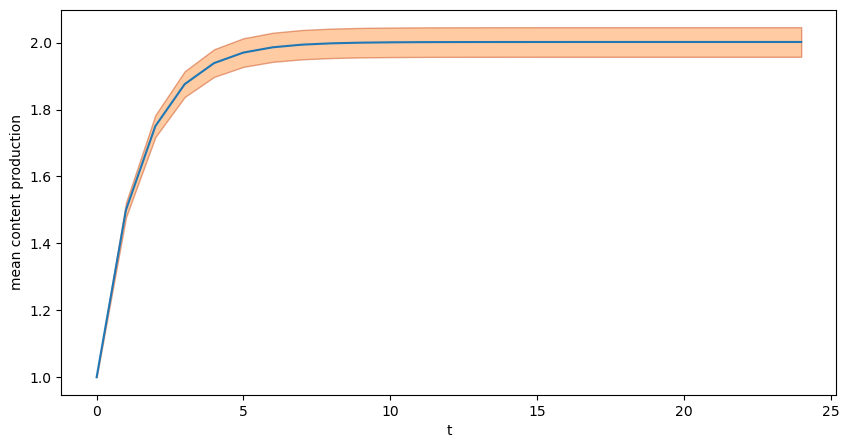

In [43]:
model = DotMap()
model.g = connected_watts_strogatz_graph(n=500_000, k=50, p=0.1).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.post_production = lambda i, λ: λ
avg_posts, _ = simulate_network(model, steady_state_cut=0)

In [44]:
model = DotMap()
model.g = connected_watts_strogatz_graph(n=10_000, k=50, p=0.1).to_directed()
model.ν_damp = 0.01
model.ν = lambda posts: model.ν_damp * sum(posts)
model.λ_int = lambda i: 1
model.T = 25
model.treatment_N = 1000
model.nodes_treatment = set(random.sample(list(model.g.nodes), model.treatment_N))
model.nodes_treatment_neighbours = set([
    v2 for (v1, v2) in model.g.edges if v1 in model.nodes_treatment and v2 not in model.nodes_treatment])
model.nodes_rest = set(set(model.g.nodes) - (model.nodes_treatment | model.nodes_treatment_neighbours))
model.Δλ = 0.05
model.post_production = lambda i, λ: λ + model.Δλ * (1 if i in model.nodes_treatment else 0)

In [45]:
k_prime = sum([len(list(model.g.neighbors(i))) for i in model.nodes_rest])/len(model.nodes_rest)
k_prime

49.88

In [46]:
model.λ_int(0)/(1 - k * model.ν_damp),
model.λ_int(0)/(1 - k_prime * model.ν_damp)

1.9952114924181965

In [47]:
avg_posts[-1], c_base_map[(0.1, 50, 0.01)]

(2.0019128837466056, 2.001890239210256)

In [48]:
c_base_map[(0.1, 10, 0.01)]

1.1112259188416231